In [2]:
import pandas as pd
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pyranges as pr
import subprocess

In [3]:
dry = False

if dry == True:
    wgbs_bed_path = './test_data/mm39_ENCSR893RHD_modifications_mergeDups_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

else:
    wgbs_bed_path = './data/mm39_ENCSR893RHD_merged.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'

    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

In [4]:
def mergeMethods(bis_df, nano_df):
    bis_df, nano_df = map(lambda df: df.drop(columns=["method", "readCount", "modification_type"]), [bis_df, nano_df])
    wide_merged = pd.merge(
        bis_df, nano_df, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Bisulphite", "_Nanopore"]
        )
    long_merged = pd.wide_to_long(wide_merged, stubnames=["readCount", "percentMeth"], i=["chromosome", "chromStart", "chromEnd"], 
                                  j="method", sep="_", suffix="\D+")
    return wide_merged.reset_index(drop=True), long_merged.reset_index()

def calcPearson(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.pearsonr(x, y)

def calcKS(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.ks_2samp(x, y, method="asymp")

In [5]:
two_mod_wide, two_mod_long = mergeMethods(wgbs_df, nano_2mod_df)
mc_df_wide, mc_df_long  = mergeMethods(oxbs_df, nano_mc_df)
hmc_df_wide, hmc_df_long = mergeMethods(tab_df, nano_hmc_df)

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


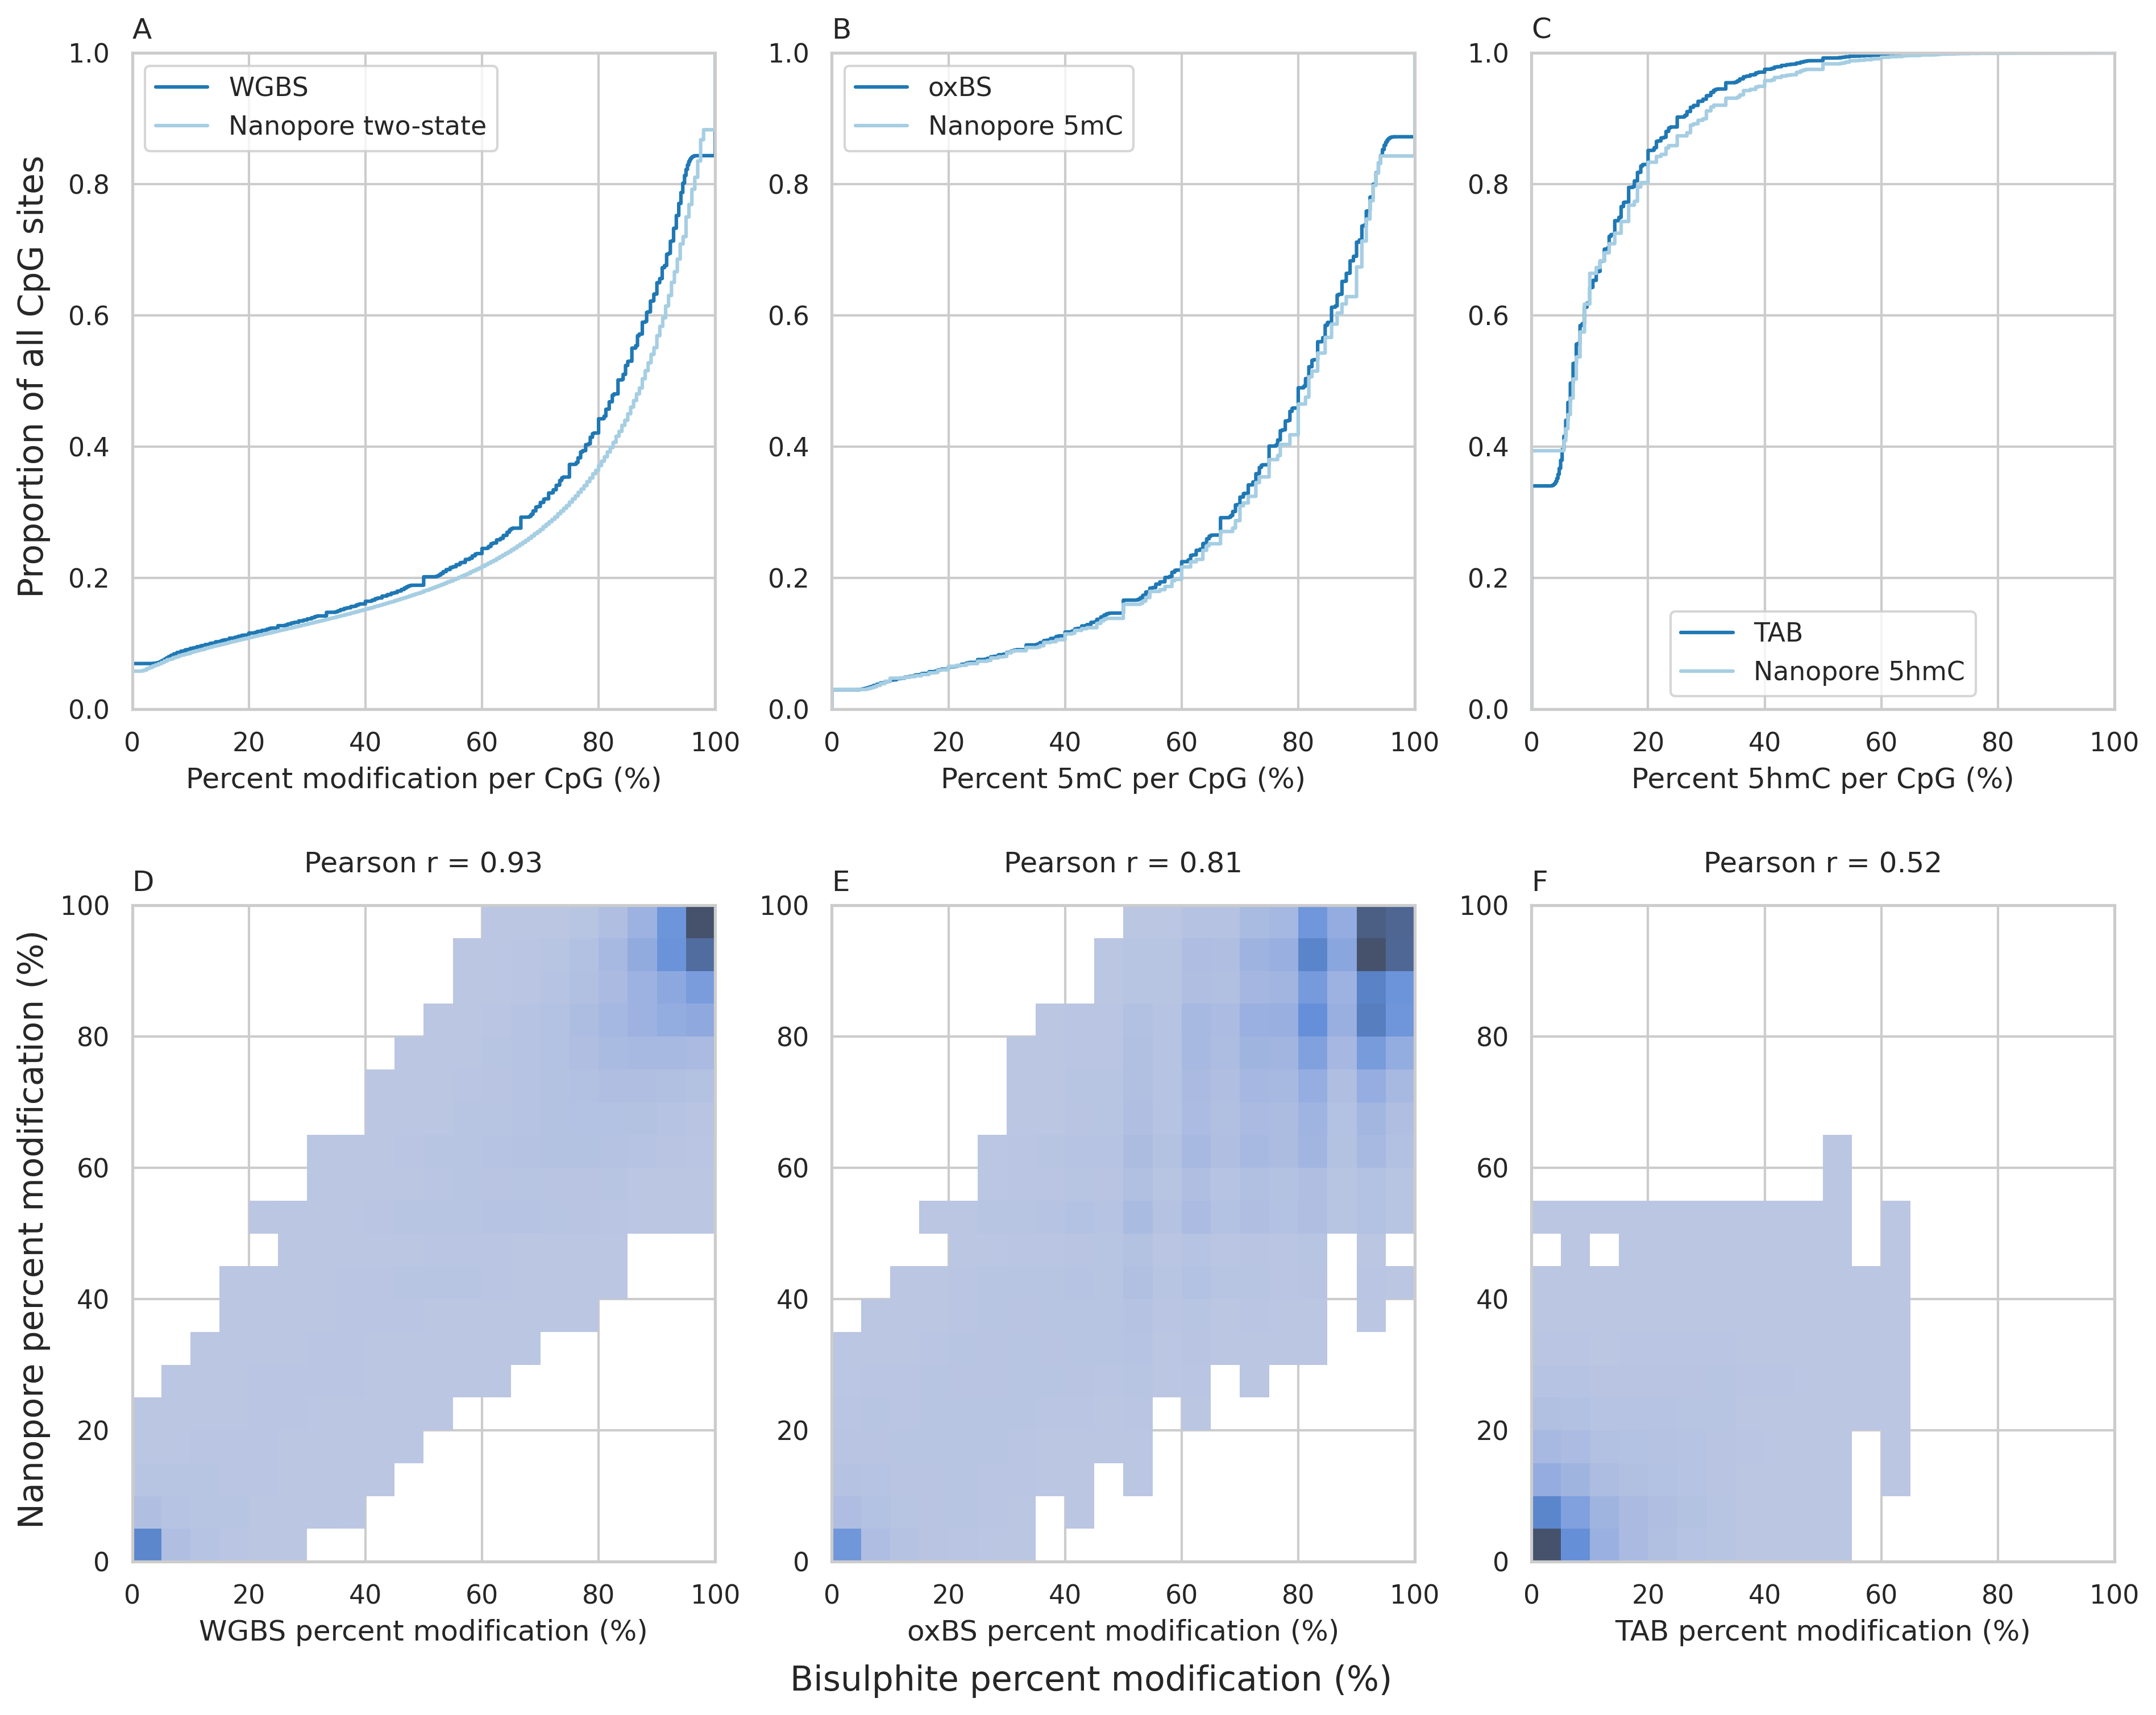

In [123]:
sns.set_theme(style="whitegrid")

fig1 = plt.figure(dpi=300, figsize=(15, 10)) 
gs1 = GridSpec(2, 1, fig1)

fig11 = fig1.add_subfigure(gs1[0, :])
gs11 = GridSpec(1, 3, fig11)
fig11.supylabel("Proportion of all CpG sites", x=0.08)

ax11 = fig11.add_subplot(gs11[0, 0])
ax12 = fig11.add_subplot(gs11[0, 1])
ax13 = fig11.add_subplot(gs11[0, 2])

sns.ecdfplot(two_mod_long, x="percentMeth", hue="method", palette="Paired", ax=ax11)
sns.move_legend(ax11, "upper left", title=None, labels=["WGBS", "Nanopore two-state"])
# ax11.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(two_mod_wide)[0]), ha="center")
ax11.set_ylabel(None)
ax11.set_xlabel("Percent modification per CpG (%)")
ax11.set_title("A", loc="left")
ax11.set_xlim([0, 100])

sns.ecdfplot(mc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax12)
sns.move_legend(ax12, "upper left", title=None, labels=["oxBS", "Nanopore 5mC"])
# ax12.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(mc_df_wide)[0]), ha="center")
ax12.set_ylabel(None)
ax12.set_xlabel("Percent 5mC per CpG (%)")
ax12.set_title("B", loc="left")
ax12.set_xlim([0, 100])

sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax13)
sns.move_legend(ax13, "lower center", title=None, labels=["TAB", "Nanopore 5hmC"])
# ax13.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(hmc_df_wide)[0]), ha="center")
ax13.set_ylabel(None)
ax13.set_xlabel("Percent 5hmC per CpG (%)")
ax13.set_xlim([0, 100])
ax13.set_title("C", loc="left")

fig12 = fig1.add_subfigure(gs1[1, :])
fig12.supxlabel("Bisulphite percent modification (%)", y=-0.05)
fig12.supylabel("Nanopore percent modification (%)", x=0.08)
gs12 = GridSpec(1, 3, fig12)

ax14 = fig12.add_subplot(gs12[0, 0])
ax15 = fig12.add_subplot(gs12[0, 1])
ax16 = fig12.add_subplot(gs12[0, 2])

sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax14)
ax14.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(two_mod_wide)[0]), ha="center")
ax14.set_xlim((0, 100))
ax14.set_ylim((0, 100))
ax14.set_xlabel("WGBS percent modification (%)")
ax14.set_ylabel(None)
ax14.set_title("D", loc="left")

sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax15)
ax15.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(mc_df_wide)[0]), ha="center")
ax15.set_xlim((0, 100))
ax15.set_ylim((0, 100))
ax15.set_xlabel("oxBS percent modification (%)")
ax15.set_ylabel(None)
ax15.set_title("E", loc="left")

sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax16)
ax16.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax16.set_xlim((0, 100))
ax16.set_ylim((0, 100))
ax16.set_xlabel("TAB percent modification (%)")
ax16.set_ylabel(None)
ax16.set_title("F", loc="left")

fig1.show()

In [6]:
def ROCmain(wide_df, ax, label):

    def ROCbinariser():
        binariser = preprocessing.Binarizer(threshold=50)
        wide_df["binarised"] = binariser.fit_transform(np.reshape(wide_df["percentMeth_Bisulphite"].to_numpy(), (-1, 1)))
        return wide_df

    def ROC():
        binarised_df = ROCbinariser()
        fpr, tpr, threshold = metrics.roc_curve(binarised_df["binarised"], binarised_df["percentMeth_Nanopore"])
        return fpr, tpr
    
    def plotROC(ax, label):
        fpr, tpr = ROC()
        return ax.plot(fpr, tpr, "-", label=label, lw=2)

    return plotROC(ax, label)

def merge3Mod(): 
    merged_df = pd.merge(mc_df_wide, hmc_df_wide, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_5mC", "_5hmC"])
    return merged_df
    
def defineTruthset():
    truth_list = np.select(
        [merge3Mod()["percentMeth_Bisulphite_5hmC"].gt(50), 
         merge3Mod()["percentMeth_Bisulphite_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return truth_list

def definePredictions():
    prediction_list = np.select(
        [merge3Mod()["percentMeth_Nanopore_5hmC"].gt(50), 
         merge3Mod()["percentMeth_Nanopore_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return prediction_list
    
def binBenchmark(wide_df):
    wide_df["bin"] = pd.cut(wide_df["percentMeth_Bisulphite"], 51, labels=np.arange(0, 102, 2))
    return wide_df

def calcChiSquare(wide_df):
    x = pd.cut(wide_df["percentMeth_Bisulphite"], 21, labels=np.arange(0, 105, 5)).value_counts()
    y = pd.cut(wide_df["percentMeth_Nanopore"], 21, labels=np.arange(0, 105, 5)).value_counts()
    return stats.chisquare(x, y)

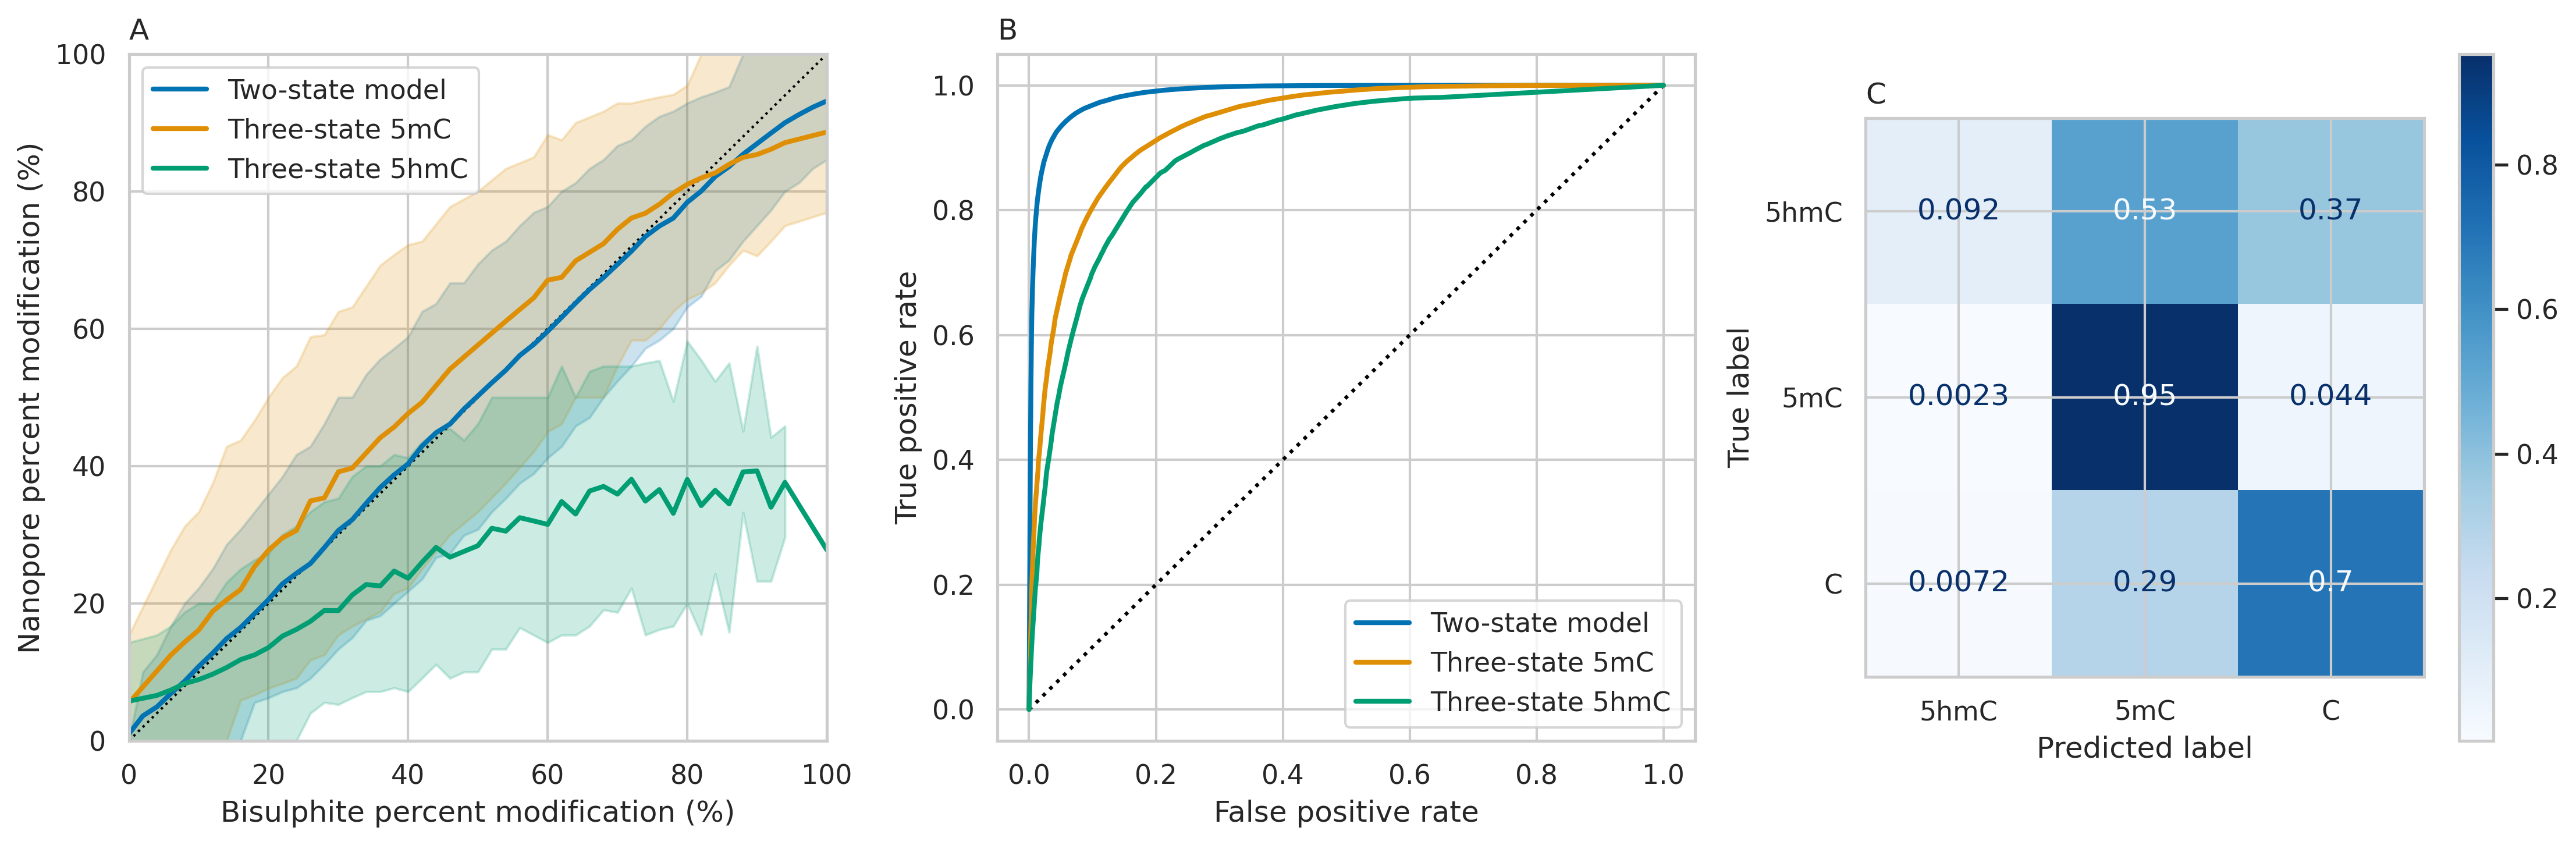

In [15]:
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig2 = plt.figure(dpi=300, figsize=(15, 5)) 
gs2 = GridSpec(1, 3, fig2)

ax21 = fig2.add_subplot(gs2[0, 0])
ax21.plot(np.arange(0, 105, 5), np.arange(0, 105, 5), linestyle=":", lw=1, color="black")
sns.lineplot(binBenchmark(two_mod_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Two-state model", linewidth=2, ax=ax21)
sns.lineplot(binBenchmark(mc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5mC", linewidth=2, ax=ax21)
sns.lineplot(binBenchmark(hmc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5hmC", linewidth=2, ax=ax21)
ax21.legend()
sns.move_legend(ax21, "upper left")
ax21.set_ylim((0, 100))
ax21.set_xlim((0, 100))
ax21.set_xlabel("Bisulphite percent modification (%)")
ax21.set_ylabel("Nanopore percent modification (%)")
ax21.set_title("A", loc="left")

ax24 = fig2.add_subplot(gs2[0, 1])
ax24.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "black", linestyle=":")
ROCmain(two_mod_wide, ax24, "Two-state model")
ROCmain(mc_df_wide, ax24, "Three-state 5mC")
ROCmain(hmc_df_wide, ax24, "Three-state 5hmC")
ax24.set_xlabel("False positive rate")
ax24.set_ylabel("True positive rate")
ax24.legend()
sns.move_legend(ax24, "lower right")
ax24.set_title("B", loc="left")

ax25 = fig2.add_subplot(gs2[0, 2])
ConfusionMatrixDisplay.from_predictions(defineTruthset(), definePredictions(), normalize="true", cmap="Blues", ax=ax25)
ax25.set_title("C", loc="left")

fig2.tight_layout()

In [ ]:
def threeModDFtoPyrange():
    data = merge3Mod()

    pyrange = pr.from_dict({
        "Chromosome" : data["chromosome"],
        "Start" : data["chromStart"],
        "End" : data["chromEnd"],
        "Strand" : data["strand_5hmC"],
        "percentMeth_Nanopore_5hmC" : data["percentMeth_Nanopore_5hmC"], 
        "percentMeth_Bisulphite_5hmC" : data["percentMeth_Bisulphite_5hmC"]
        }
        )
    return pyrange
    
three_mod_pr = threeModDFtoPyrange()

In [71]:


def intersectWithGene():
    pyrange = three_mod_pr
    gene_ref = pd.read_csv('./feature_references/revised/GENCODE_Basic_mm39_Genes_merged.bed', sep="\t", 
                           names=["Chromosome", "Start", "End", "geneName", "Strand"])    
    return pyrange.join(pr.PyRanges(gene_ref), strandedness="same")

def convertToGeneDF():
    pyrange = intersectWithGene()
    gene_df = pyrange.as_df().groupby(["geneName"])[["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"]].agg([np.mean, "count"])
    return gene_df.reset_index()

def geneLog2MeanDF():
    gene_df = convertToGeneDF()
    nanopore_mean = np.mean(gene_df["percentMeth_Nanopore_5hmC"]["mean"])
    bisulphite_mean = np.mean(gene_df["percentMeth_Bisulphite_5hmC"]["mean"])

    with np.errstate(divide="ignore"):
        gene_df["Log2FromMean_Nanopore"] = np.log2(
            np.divide(gene_df["percentMeth_Nanopore_5hmC"]["mean"],
                    nanopore_mean)
        )
        gene_df["Log2FromMean_Bisulphite"] = np.log2(
            np.divide(gene_df["percentMeth_Bisulphite_5hmC"]["mean"],
                    bisulphite_mean)
        )
    gene_df = gene_df.replace(-np.inf, np.nan)
    return gene_df.dropna()    

def makeRefDF(path, feature_type):
    columns = ["Chromosome","Start","End","Name","Score","Strand","feature_type"]
    df = pd.read_csv(path, sep="\t", names=columns)
    df["feature_type"] = feature_type
    return df

def makeFeatureRefDF():
    gene_feature_list = subprocess.check_output(["ls", "./feature_references/revised/gene_features/"]).decode("utf-8").split("\n") 
    gene_feature_list.pop(-1)

    df_list = []
    for file in gene_feature_list:
        path = "./feature_references/revised/gene_features/" + file
        columns = ["Chromosome","Start","End","Name","Score","Strand"]
        df = pd.read_csv(path, sep="\t", names=columns)
        df["feature_type"] = file.split("_")[3]
        df_list.append(df)

    feature_reference_df = pd.concat(df_list)
    return feature_reference_df

def makeCGIrefDF():
    cgi_feature_list = subprocess.check_output(["ls", "./feature_references/revised/cgi/"]).decode("utf-8").split("\n") 
    cgi_feature_list.pop(-1)

    cgi_df_list = []
    for file in cgi_feature_list:
        path = "./feature_references/revised/cgi/" + file
        columns = ["Chromosome","Start","End","Name","feature_type"]
        df = pd.read_csv(path, sep="\t", names=columns)
        cgi_df_list.append(df)

    cgi_reference_df = pd.concat(cgi_df_list)
    return cgi_reference_df

def meltMethod(input_df):
    df_melt = input_df.melt(
        ["Chromosome", "Start", "End", "Strand", "feature_type"], 
        ["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"], 
        "method", 
        value_name="percentMeth"
                    )
    return df_melt

def replaceMethod(input_df):
    df_with_replacement = input_df.replace(["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"], ["Nanopore 5hmC", "TAB"])
    return df_with_replacement

def categoriseGeneFeatures(input_df):
    categorised_features = input_df.copy()
    categorised_features["feature_type"] = pd.Categorical(
        categorised_features["feature_type"], 
        ["Intergenic", "Promoter", "5UTR", "TSS", "Intron", "Exon", "3UTR", "TTS"])
    return categorised_features
        
def categoriseCGI(input_df):
    categorised_features = input_df.copy()
    categorised_features["feature_type"] = pd.Categorical(
        categorised_features["feature_type"], ["Open sea", "Upstream shelf", "Upstream shore", "CGI", "Downstream shore", "Downstream shelf"])
    return categorised_features
        
def intersectWithFeatures(input_df, categorise=None):

    if categorise == "Gene features":
        ref_features = pr.PyRanges(makeFeatureRefDF())
        feature_intersect = input_df.join(ref_features)
        feature_intersect_df = meltMethod(feature_intersect.as_df())
        feature_intersect_df = replaceMethod(feature_intersect_df)
        feature_intersect_df = categoriseGeneFeatures(feature_intersect_df)

    elif categorise == "CGI":
        ref_features = pr.PyRanges(makeCGIrefDF())
        feature_intersect = input_df.join(ref_features)
        feature_intersect_df = meltMethod(feature_intersect.as_df())
        feature_intersect_df = replaceMethod(feature_intersect_df)
        feature_intersect_df = categoriseCGI(feature_intersect_df)
        
    return feature_intersect_df

def featureLinePlotMain():
    input_df = three_mod_pr
    output_df = intersectWithFeatures(input_df, "Gene features")
    return output_df

def cgiLinePlotMain():
    input_df = three_mod_pr
    output_df = intersectWithFeatures(input_df, "CGI")
    return output_df

def clusterPyrangeToDF(pyrange):
    tiled_pr = pyrange.tile(1000, strand=False).cluster(slack=-1, strand=False)
    cluster_pr = tiled_pr.merge(slack=-1, count=True, strand=False)
    cluster_pr = cluster_pr.insert(tiled_pr.apply(f=lambda df: df.groupby("Cluster")[["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"]].mean(), as_pyranges=False, strand=False))
    return cluster_pr.as_df()

def log2FromMean(df):
    nano_mean = np.mean(df["percentMeth_Nanopore_5hmC"])
    bisulphite_mean = np.mean(df["percentMeth_Bisulphite_5hmC"])

    with np.errstate(divide="ignore"):
        df["Log2FromMean_Bisulphite"], df["Log2FromMean_Nanopore"] = np.log2(np.divide(df["percentMeth_Bisulphite_5hmC"], bisulphite_mean)), np.log2(np.divide(df["percentMeth_Nanopore_5hmC"], nano_mean))

    return df.replace(-np.inf, np.nan).dropna()

def tileMain():
    return log2FromMean(clusterPyrangeToDF(three_mod_pr))

In [78]:
tile_df = tileMain() 
tile_df = tile_df.loc[tile_df["Count"] >= 10]

In [8]:
log2_mean_df = geneLog2MeanDF()

In [9]:
def testGroupHelper():
    gene_df = log2_mean_df.copy().sort_index(axis=1)
    gene_df["Count"] = gene_df["percentMeth_Bisulphite_5hmC"]["count"]
    gene_df["Difference"] = np.subtract(gene_df["Log2FromMean_Bisulphite"], gene_df["Log2FromMean_Nanopore"])
    gene_df["Average"] = gene_df[["Log2FromMean_Bisulphite", "Log2FromMean_Nanopore"]].mean(axis=1)
    # gene_df = gene_df.loc[gene_df["percentMeth_Bisulphite_5hmC"]["count"] > 20]
    return gene_df.drop(columns=["percentMeth_Bisulphite_5hmC", "percentMeth_Nanopore_5hmC"])

cpg_threshold = 25
number_target_genes = 10

def defineNegativeControl():
    df = testGroupHelper()
    df = df.loc[df["Count"] >= cpg_threshold]
    df = df.nsmallest(50, "Average")
    df = df.nsmallest(number_target_genes, "Difference")
    return df 

def definePositiveControl():
    df = testGroupHelper()
    df = df.loc[df["Count"] >= cpg_threshold]
    df = df.nlargest(50, "Average")
    df = df.nsmallest(number_target_genes, "Difference")
    return df 

def defineNanoporePositive():
    df = testGroupHelper()
    df = df.loc[df["Count"] >= cpg_threshold]
    df = df.loc[df["Log2FromMean_Bisulphite"] <= 0]
    df = df.nlargest(number_target_genes, "Log2FromMean_Nanopore")
    return df 

def defineTabPositive():
    df = testGroupHelper()
    df = df.loc[df["Count"] >= cpg_threshold]
    df = df.loc[df["Log2FromMean_Nanopore"] <= 0]
    df = df.nlargest(number_target_genes, "Log2FromMean_Bisulphite")
    return df 

Text(0, 0.5, 'Nanopore enrichment score')

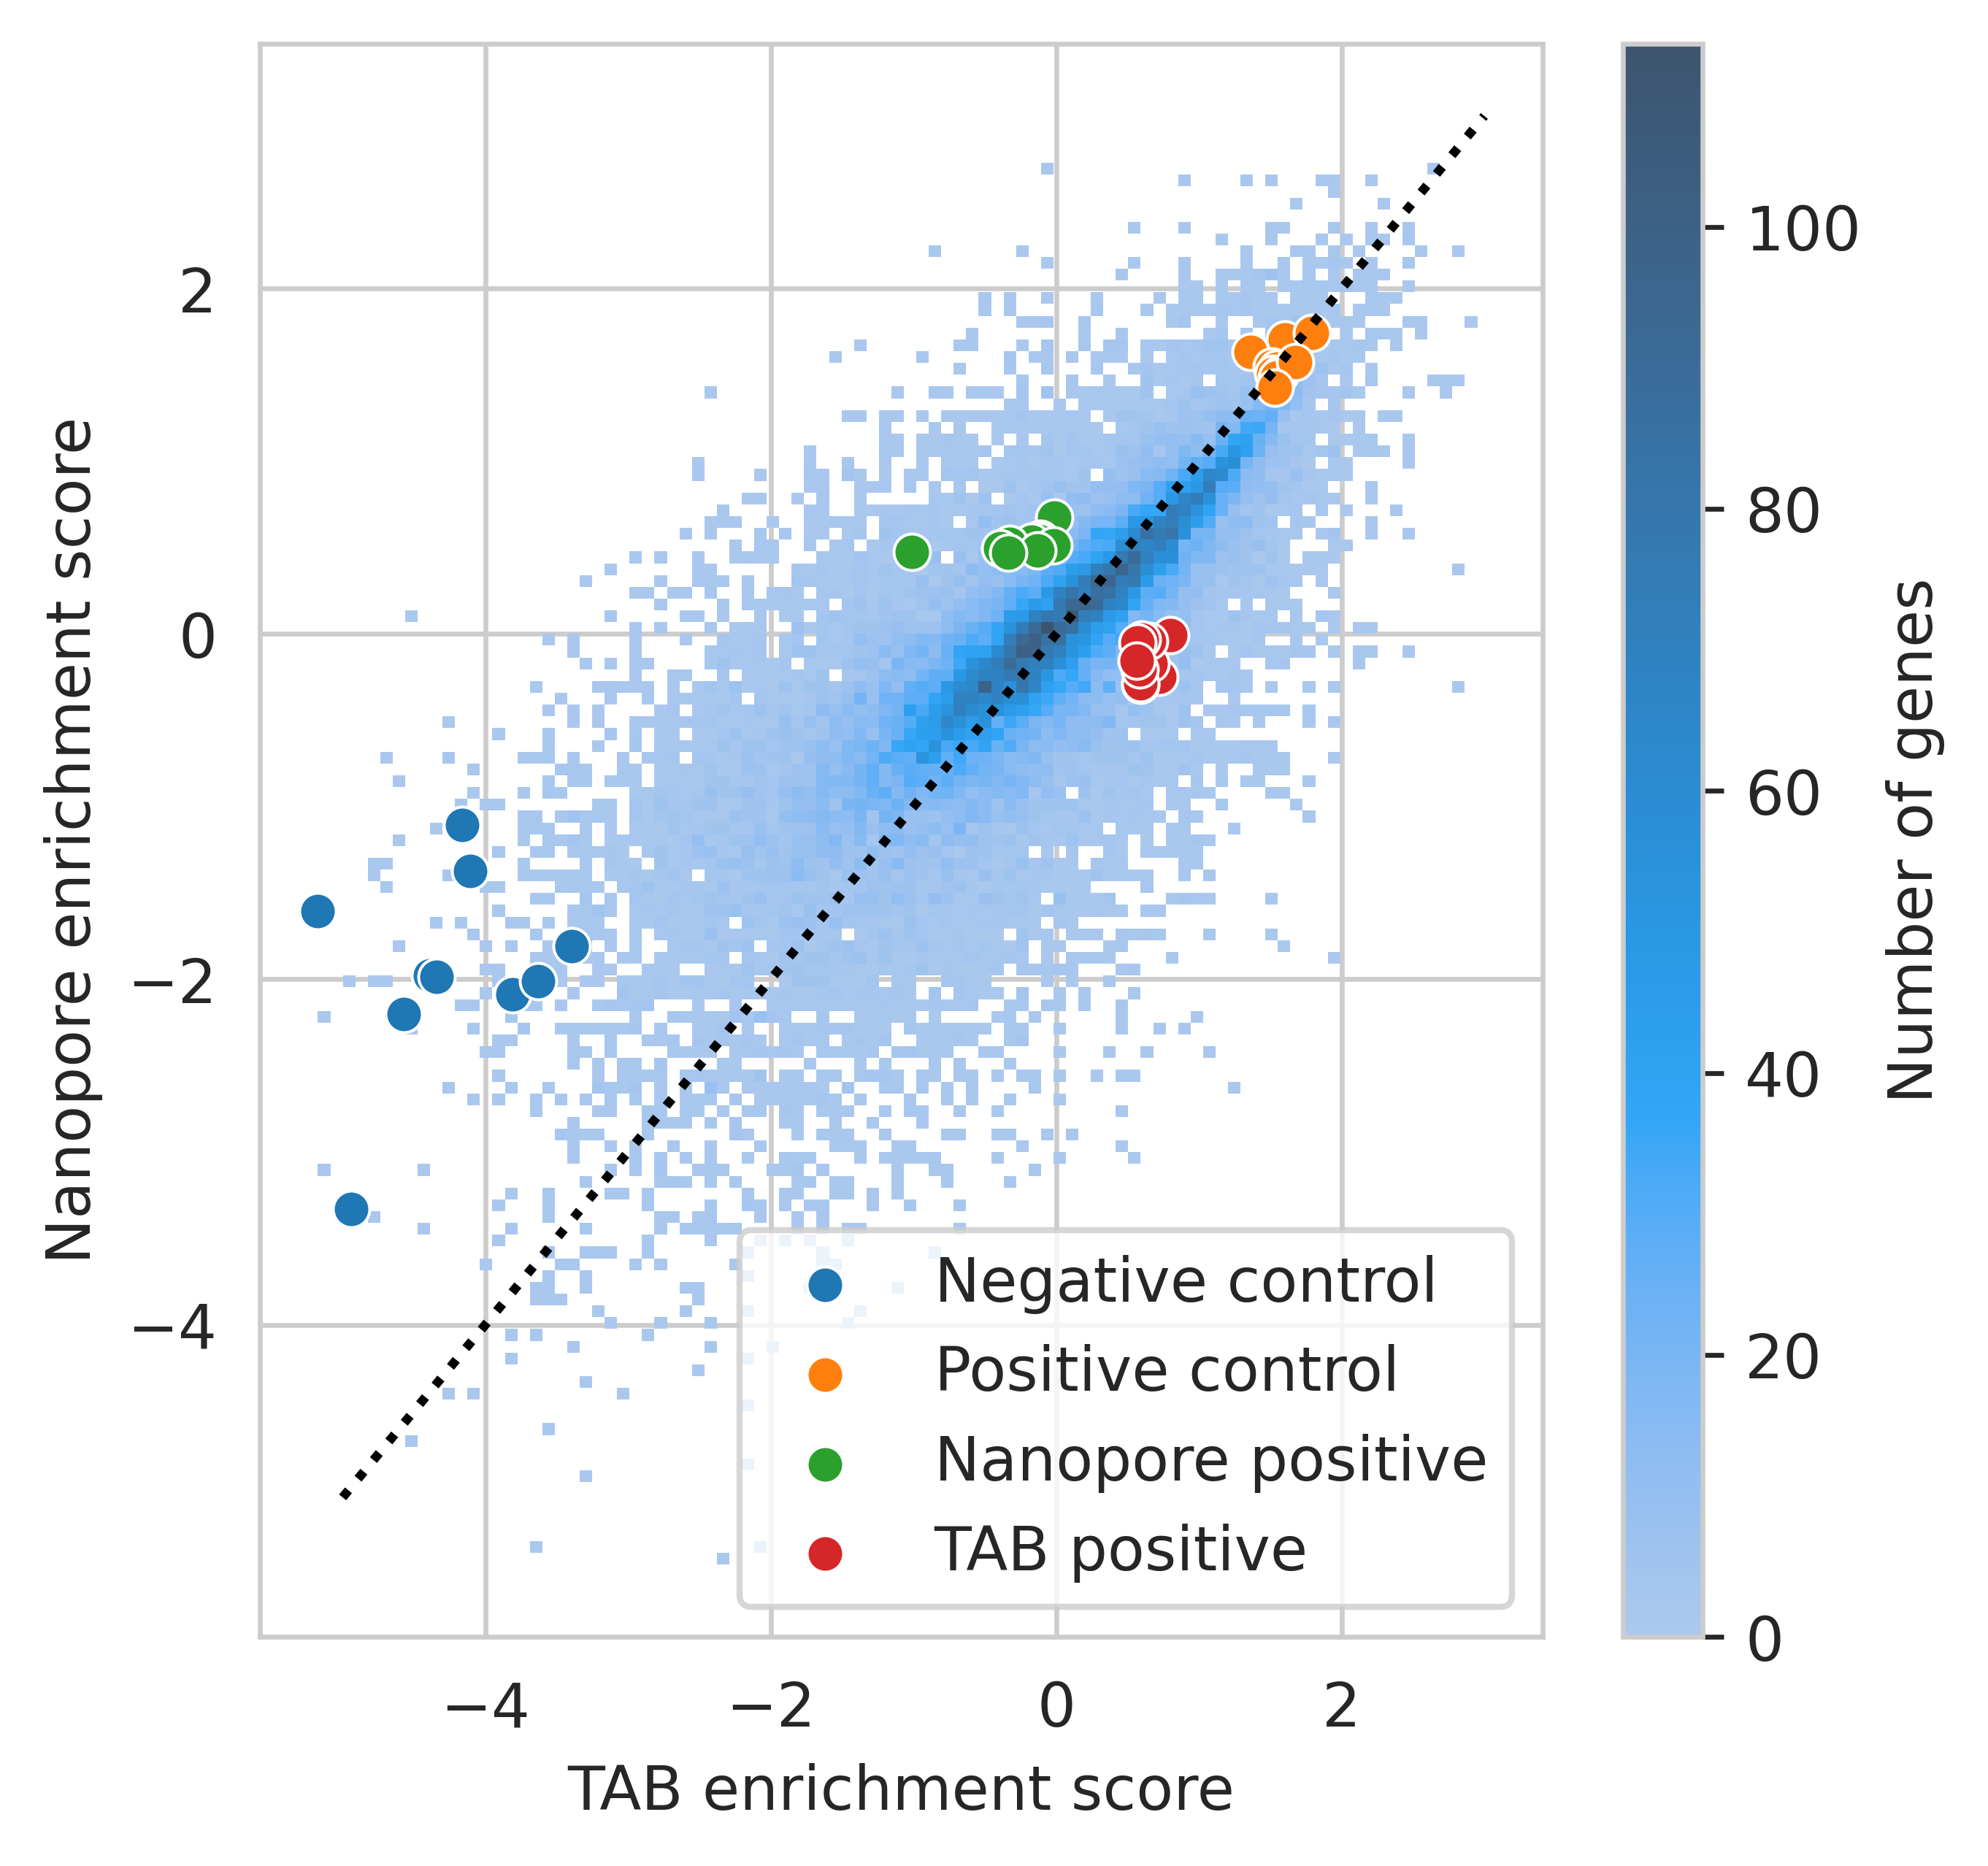

In [98]:
fig = plt.figure(figsize=((12)/2.54, (12)/2.54), dpi=600, facecolor="None")
ax = fig.add_subplot()
sns.set_style("whitegrid")

sns.histplot(log2_mean_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="count",
             cbar_kws={"label" : "Number of genes", 
                       "format" : "%d"},
             ax=ax)

ax.plot(np.arange(-5, 4, 1), np.arange(-5, 4, 1), color="black", linestyle=":")
sns.scatterplot(defineNegativeControl(), x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", label="Negative control", ax=ax)
sns.scatterplot(definePositiveControl(), x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", label="Positive control", ax=ax)
sns.scatterplot(defineNanoporePositive(), x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", label="Nanopore positive", ax=ax)
sns.scatterplot(defineTabPositive(), x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", label="TAB positive", ax=ax)
ax.legend(loc="lower right")
ax.set_xlabel("TAB enrichment score")
ax.set_ylabel("Nanopore enrichment score")


# Output list of possible target genes

In [74]:
import mygene
import openpyxl

def splitENSIDSeries(df):
    df["ENSID"] = df["geneName"].apply(lambda s: s.split(",").pop(0).split(".")[0])
    return df

def getEntrezName(df):
    df = splitENSIDSeries(df)
    mg = mygene.MyGeneInfo()
    query = pd.DataFrame(mg.querymany(df["ENSID"], scopes="ensembl.transcript", fields="symbol"))
    df["EntrezName"] = list(query["symbol"])
    return df[["EntrezName", "Log2FromMean_Bisulphite", "Log2FromMean_Nanopore", "Difference", "Count"]]

writer = pd.ExcelWriter('./outputs/target_genes.xlsx', engine="openpyxl")

df_list = [getEntrezName(defineNegativeControl()), getEntrezName(definePositiveControl()), getEntrezName(defineNanoporePositive()), getEntrezName(defineTabPositive())]

sheet_names = ["negative_control", "positive_control", "nanopore_positive", "tab_positive"]

for i in np.arange(0, 4, 1):
    sheet = sheet_names[i]
    df_list[i].to_excel(writer, sheet)
writer.close()


INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


In [134]:
featureLinePlot_df = featureLinePlotMain()
cgiLinePlot_df = cgiLinePlotMain() 

KeyboardInterrupt: 

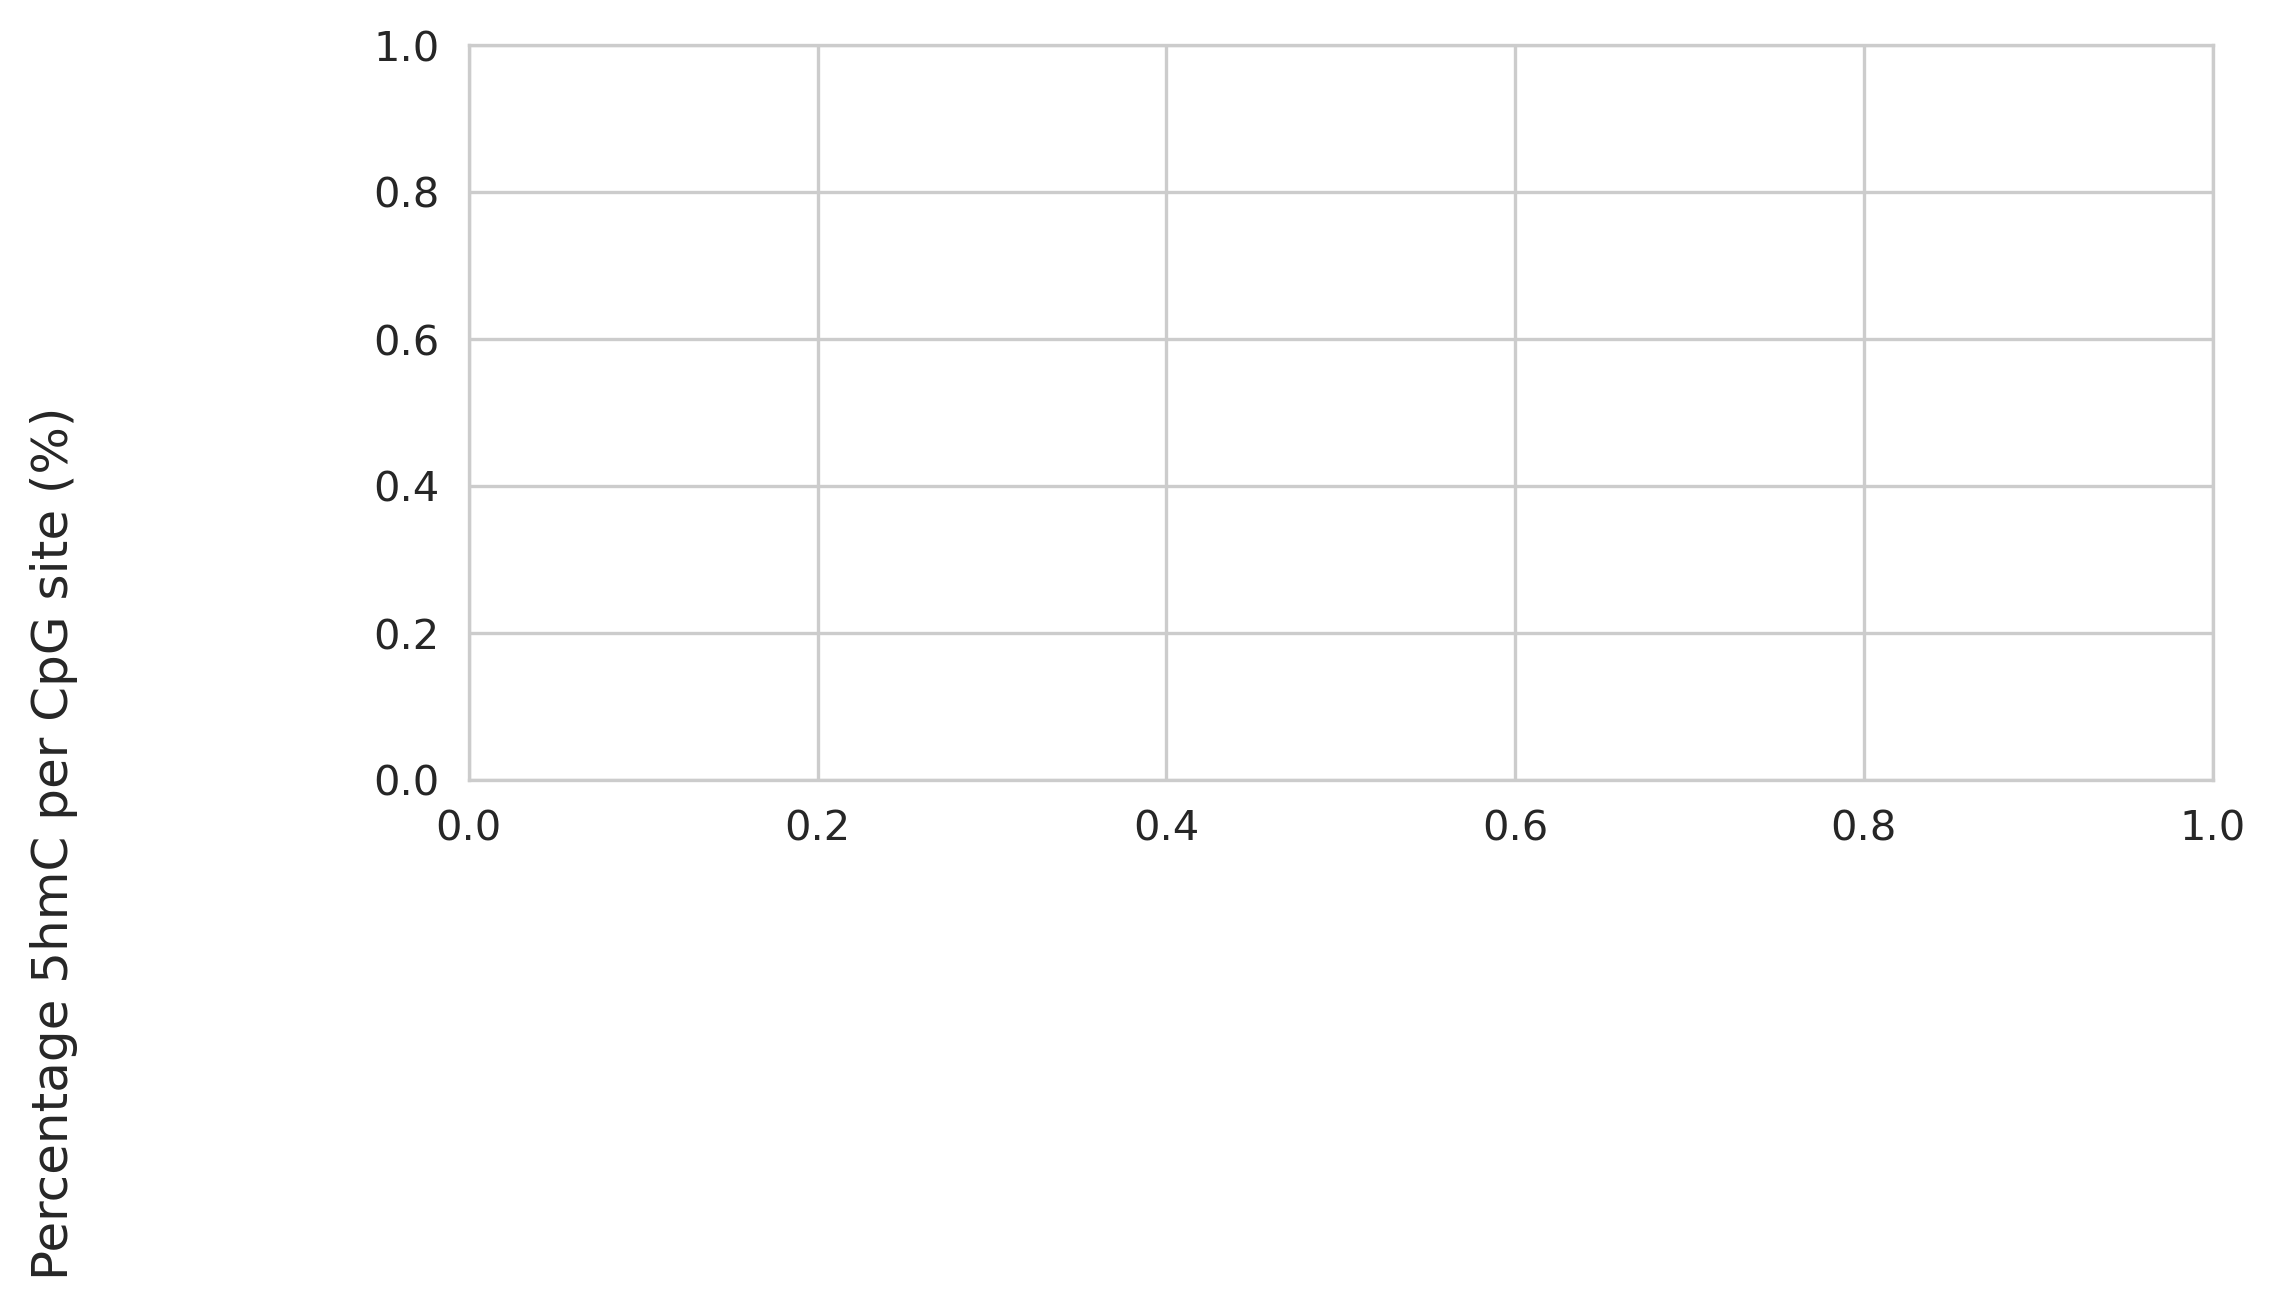

In [87]:
fig3 = plt.figure(dpi=300, figsize=(15, 7))
gs3 = GridSpec(1, 2, fig3)

fig32 = fig3.add_subfigure(gs3[:, 0])
fig32.supylabel("Percentage 5hmC per CpG site (%)", x=-0.07)
gs32 = GridSpec(2, 1, fig32)

ax32 = fig32.add_subplot(gs32[0, :])

sns.barplot(featureLinePlot_df, x="feature_type", y="percentMeth", hue="method", capsize=0.05, errwidth=1, ax=ax32)
ax32.set_xlabel("CpG context (genomic)")
ax32.set_ylabel(None)
ax32.set_ylim((0, 15))
ax32.set_title("A", loc="left")
sns.move_legend(ax32, "lower right", title=None)

ax33 = fig32.add_subplot(gs32[1, :])

sns.lineplot(cgiLinePlot_df, x="feature_type", y="percentMeth", hue="method", style="method", errorbar=("ci", 50), err_style="band", ax=ax33)
ax33.set_xlabel("CpG context (relative to CGI)")
ax33.set_ylabel(None)
ax33.set_ylim((0, 15))
ax33.set_title("B", loc="left")
# ax33.tick_params("x", rotation=10, zorder=10)
ax33.set_xticklabels(["Open\nsea", "Upstream\nshelf", "Upstream\nshore", 
                      "Island", "Downstream\nshore", "Downstream\nshelf"])
sns.move_legend(ax33, "lower right", title=None)

fig31 = fig3.add_subfigure(gs3[0, 1])
ax31 = fig31.add_subplot()

sns.histplot(log2_mean_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="count",
             cbar_kws={"label" : "Number of genes", 
                       "format" : "%d",
                       "shrink" : 0.3},
                       ax=ax31
             )
ax31.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")

ax31.set_aspect(1)
ax31.set_ylim((-5.5, 3))
ax31.set_xlim((-5.5, 3))
ax31.set_xlabel("TAB enrichment score")
ax31.set_ylabel("Nanopore enrichment score")
ax31.set_title("C", loc="left")

gene_rho, gene_p = stats.spearmanr(log2_mean_df["Log2FromMean_Nanopore"], log2_mean_df["Log2FromMean_Bisulphite"])
ax31.text(-0.5, 2.6, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")


fig3.tight_layout(pad=4)

# PowerPoint style figures

These figures have been modified for standard PowerPoint dimensions to be used in presentations.

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


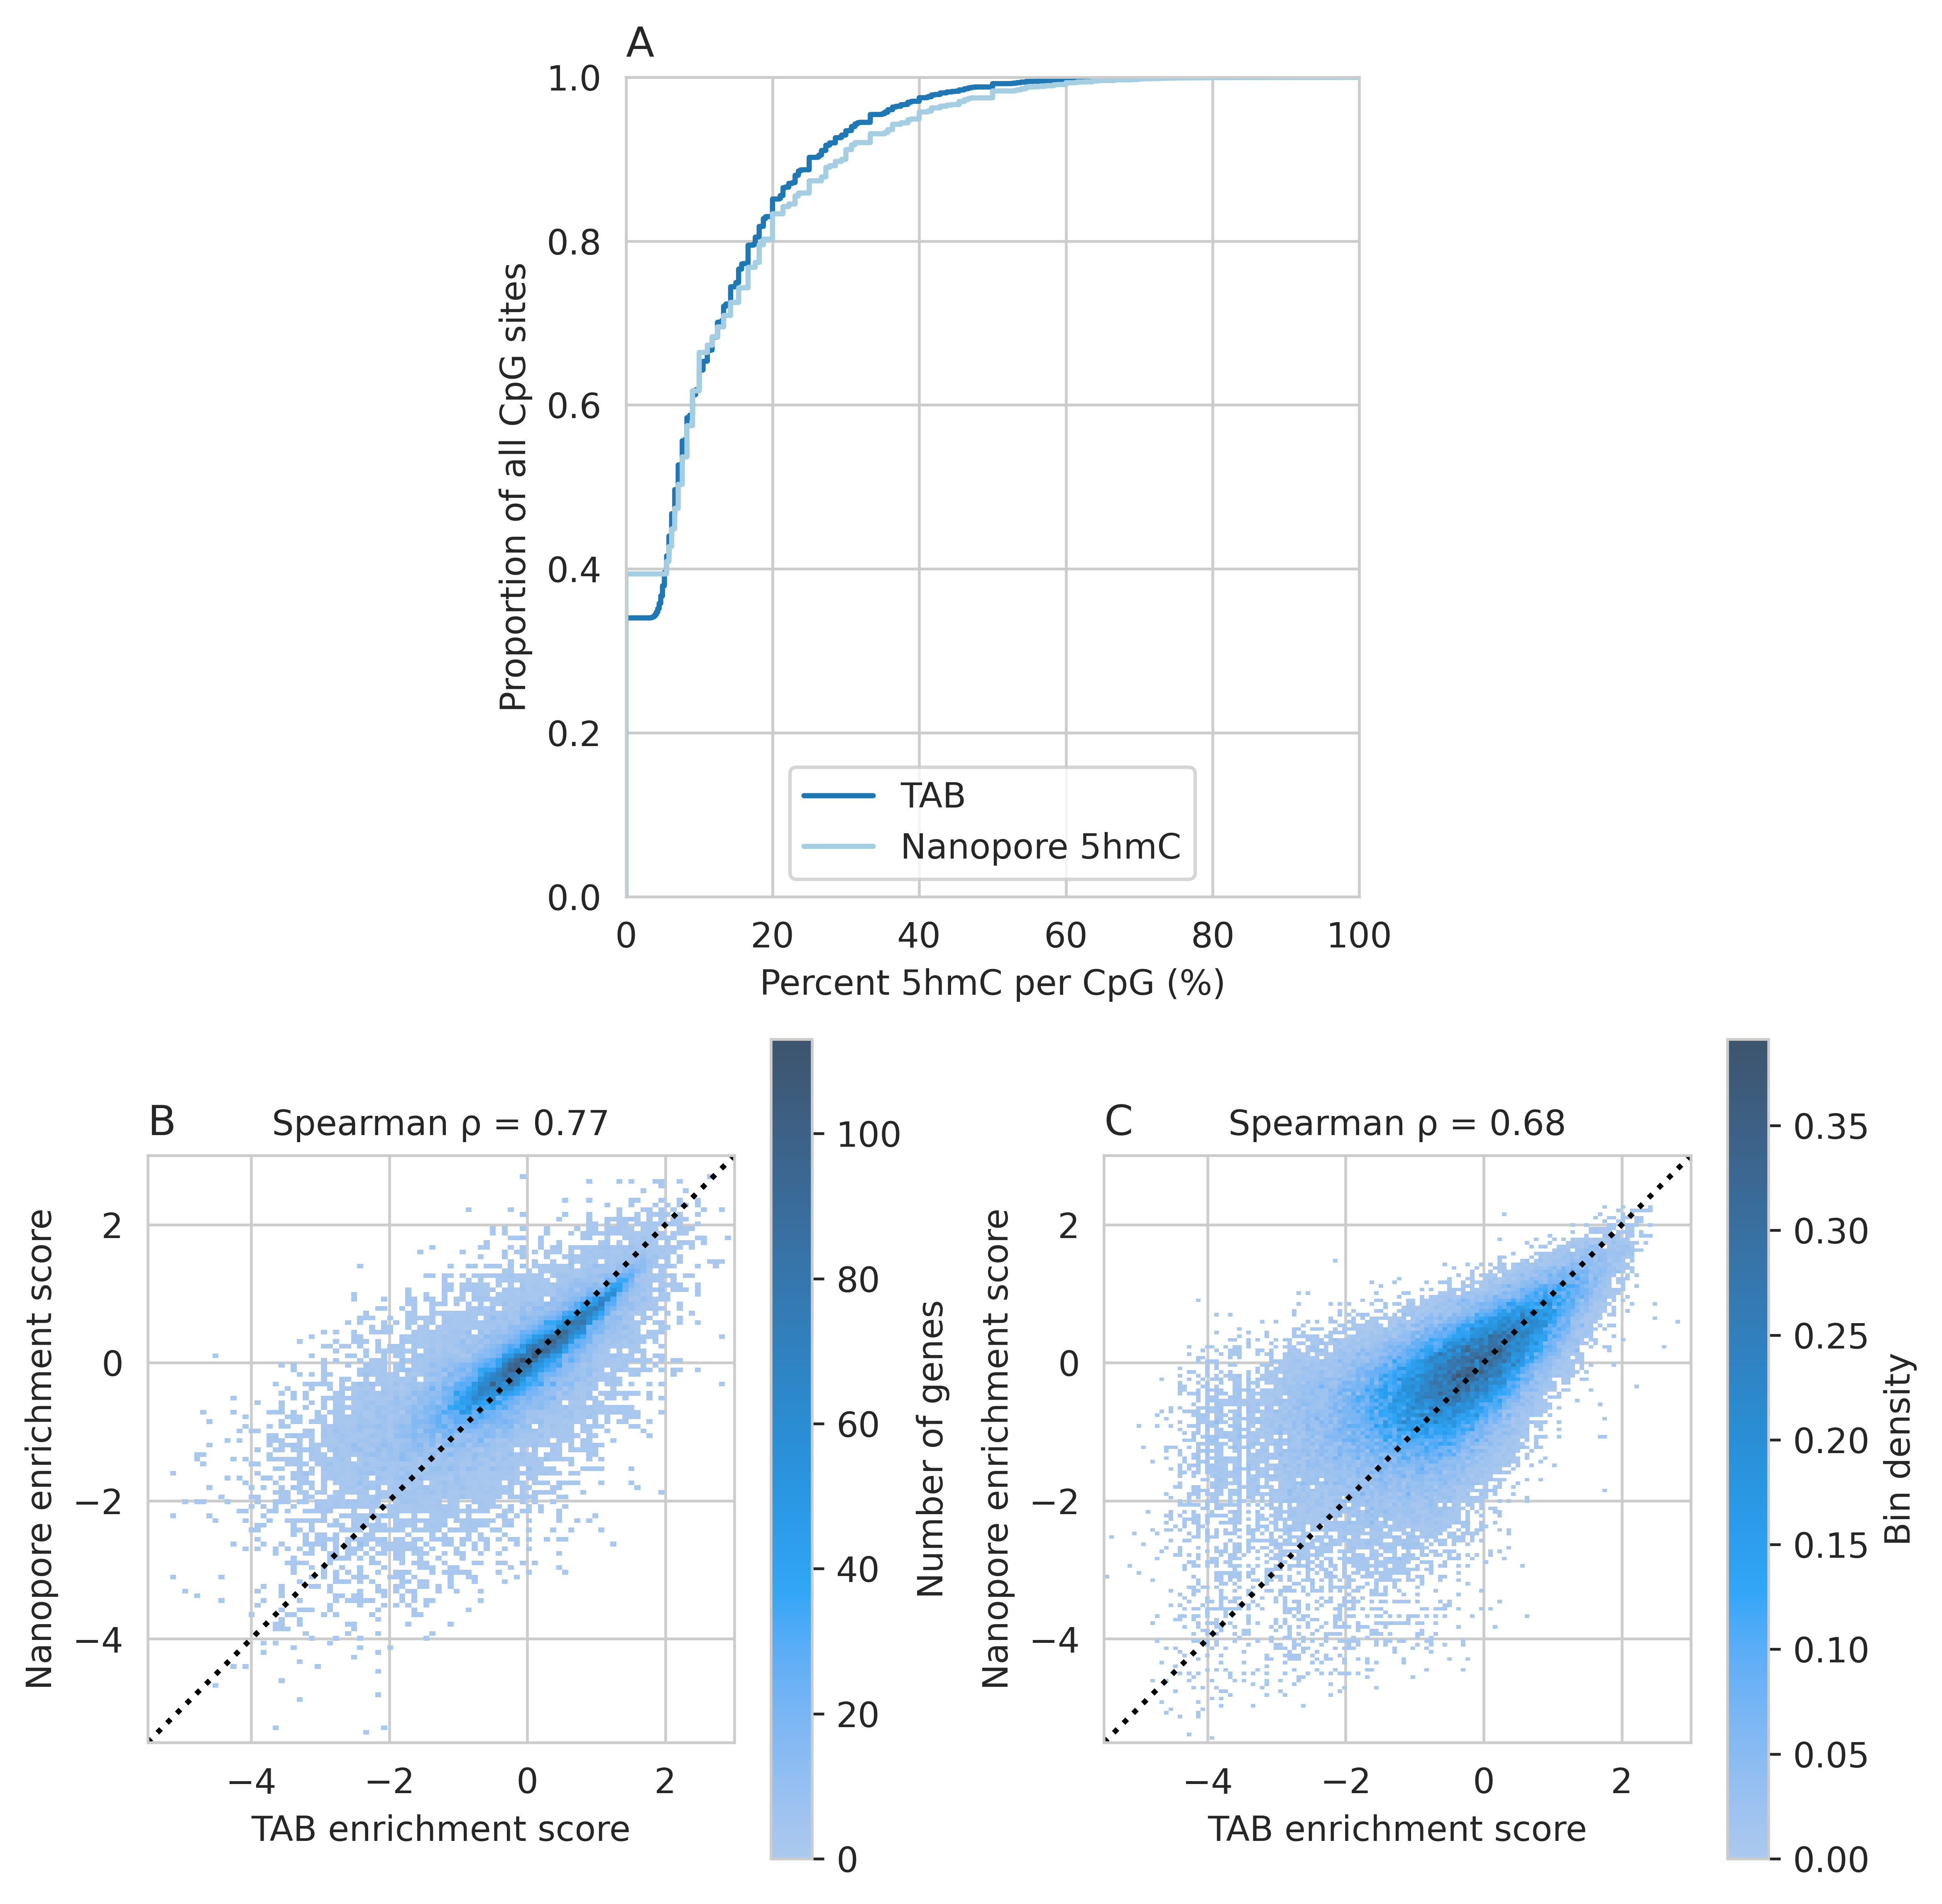

In [82]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=((20)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs = GridSpec(2, 4, fig)

ax1 = fig.add_subplot(gs[0, 1:3])
sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax1)
sns.move_legend(ax1, "lower center", title=None, labels=["TAB", "Nanopore 5hmC"])
ax1.set_ylabel("Proportion of all CpG sites")
ax1.set_xlabel("Percent 5hmC per CpG (%)")
ax1.set_xlim([0, 100])
ax1.set_title("A", loc="left")

ax2 = fig.add_subplot(gs[1, :2])
ax2.set_aspect("equal", adjustable="box")

sns.histplot(log2_mean_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="count",
             cbar_kws={"label" : "Number of genes", 
                       "format" : "%d"},
                       ax=ax2)
ax2.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")
ax2.set_ylim((-5.5, 3))
ax2.set_xlim((-5.5, 3))

gene_rho, gene_p = stats.spearmanr(log2_mean_df["Log2FromMean_Nanopore"], log2_mean_df["Log2FromMean_Bisulphite"])
ax2.text(3-(5.5+3)/2, 3.3, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")

ax2.set_xlabel("TAB enrichment score")
ax2.set_ylabel("Nanopore enrichment score")
ax2.set_title("B", loc="left")

ax3 = fig.add_subplot(gs[1, 2:])
ax3.set_aspect("equal", adjustable="box")

sns.histplot(tile_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="density",
            cbar_kws={"label" : "Bin density"},
            ax=ax3)

tile_rho, tile_p = stats.spearmanr(tile_df["Log2FromMean_Nanopore"], tile_df["Log2FromMean_Bisulphite"])

ax3.text(3-(5.5+3)/2, 3.3, "Spearman \u03C1 = {rho:.2f}".format(rho=tile_rho), ha="center")
ax3.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")
ax3.set_title("C", loc="left")
ax3.set_ylim((-5.5, 3))
ax3.set_xlim((-5.5, 3))
ax3.set_xlabel("TAB enrichment score")
ax3.set_ylabel("Nanopore enrichment score")

fig.tight_layout()

In [81]:
gene_p, tile_p

(0.0, 0.0)

In [143]:
featureLinePlot_df

Chromosome     Start       End Strand feature_type  \
0                           chr1   3051030   3051031      +   Intergenic   
1                           chr1   3073014   3073015      +   Intergenic   
2                           chr1   3078767   3078768      +   Intergenic   
3                           chr1   3083062   3083063      +   Intergenic   
4                           chr1   3085676   3085677      +   Intergenic   
...                          ...       ...       ...    ...          ...   
13706377  chrX_GL456233v2_random    543780    543781      -   Intergenic   
13706378  chrX_GL456233v2_random    546349    546350      -   Intergenic   
13706379  chrX_GL456233v2_random    547551    547552      -   Intergenic   
13706380  chrX_GL456233v2_random    550106    550107      -   Intergenic   
13706381                    chrY  89282800  89282801      +   Intergenic   

                 method  percentMeth  
0         Nanopore 5hmC         0.00  
1         Nanopore 5hmC        12.50  
2         Nanopore 5hmC         0.00  
3         Nanopore 5hmC        30.77  
4         Nanopore 5hmC         0.00  
...                 ...          ...  
13706377            TAB         0.00  
13706378            TAB         0.00  
13706379            TAB         0.00  
13706380            TAB         0.00  
13706381            TAB         0.00  

[13706382 rows x 7 columns]

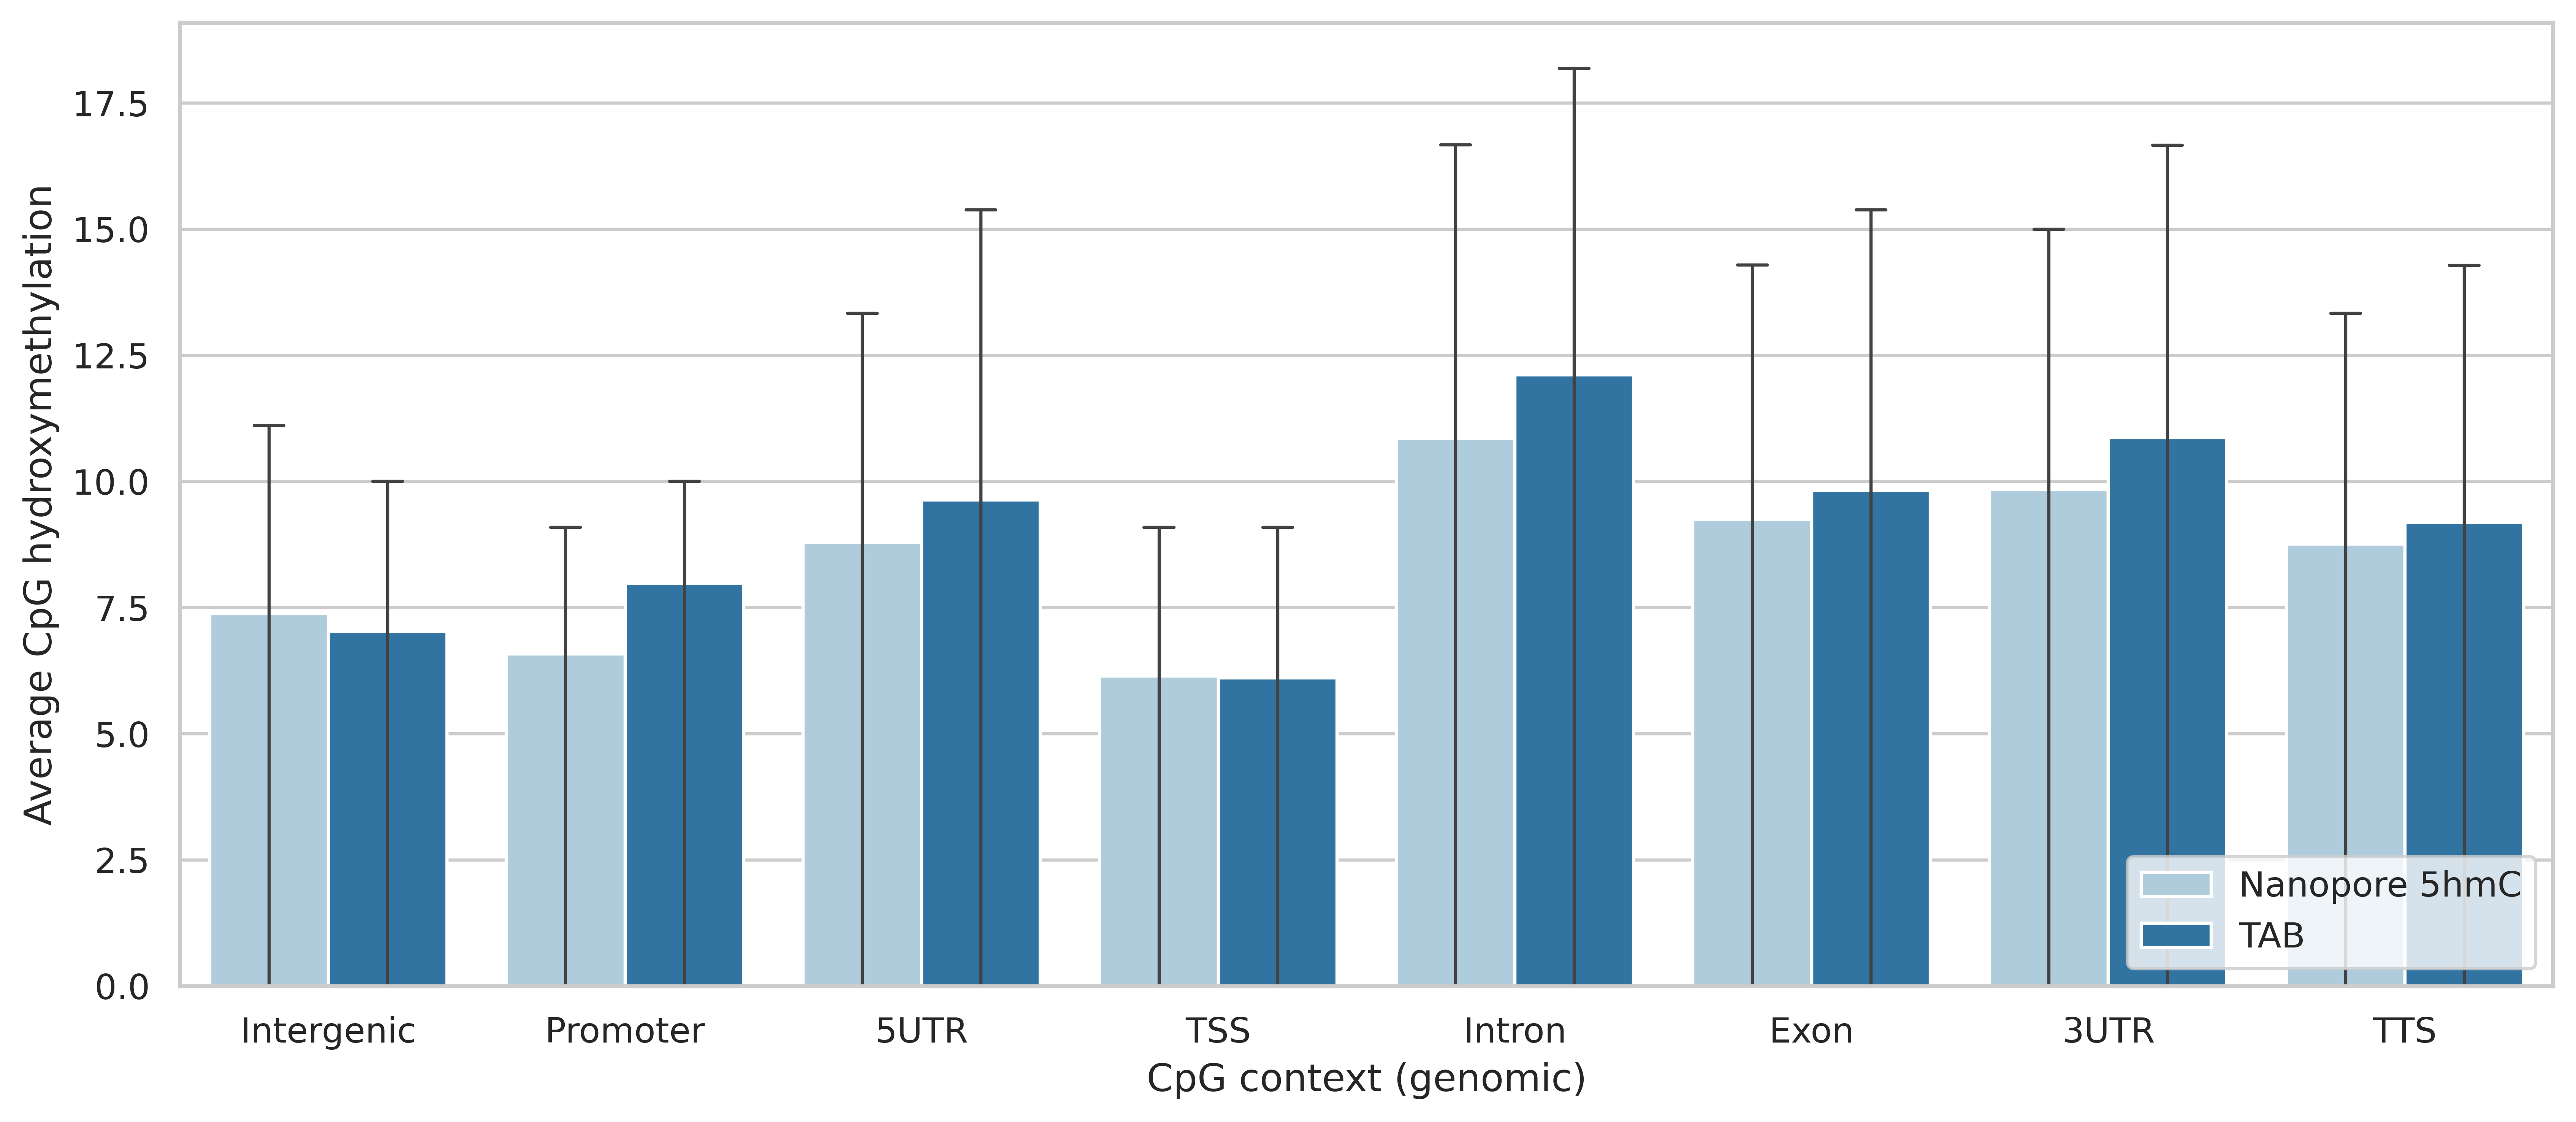

In [142]:
fig = plt.figure(figsize=((29.1)/2.54, (12.9)/2.54), dpi=600, facecolor="None")
gs = GridSpec(1, 1, fig)
sns.set_style("whitegrid")
sns.set_palette("Paired")

ax32 = fig.add_subplot(gs[0, :])

sns.barplot(featureLinePlot_df, x="feature_type", y="percentMeth", hue="method", errorbar=("pi", 50), capsize=0.1, errwidth=1, ax=ax32)
ax32.set_xlabel("CpG context (genomic)")
ax32.set_ylabel("Average CpG hydroxymethylation")
# ax32.set_ylim((0, 40))
sns.move_legend(ax32, "lower right", title=None)    

fig.tight_layout()

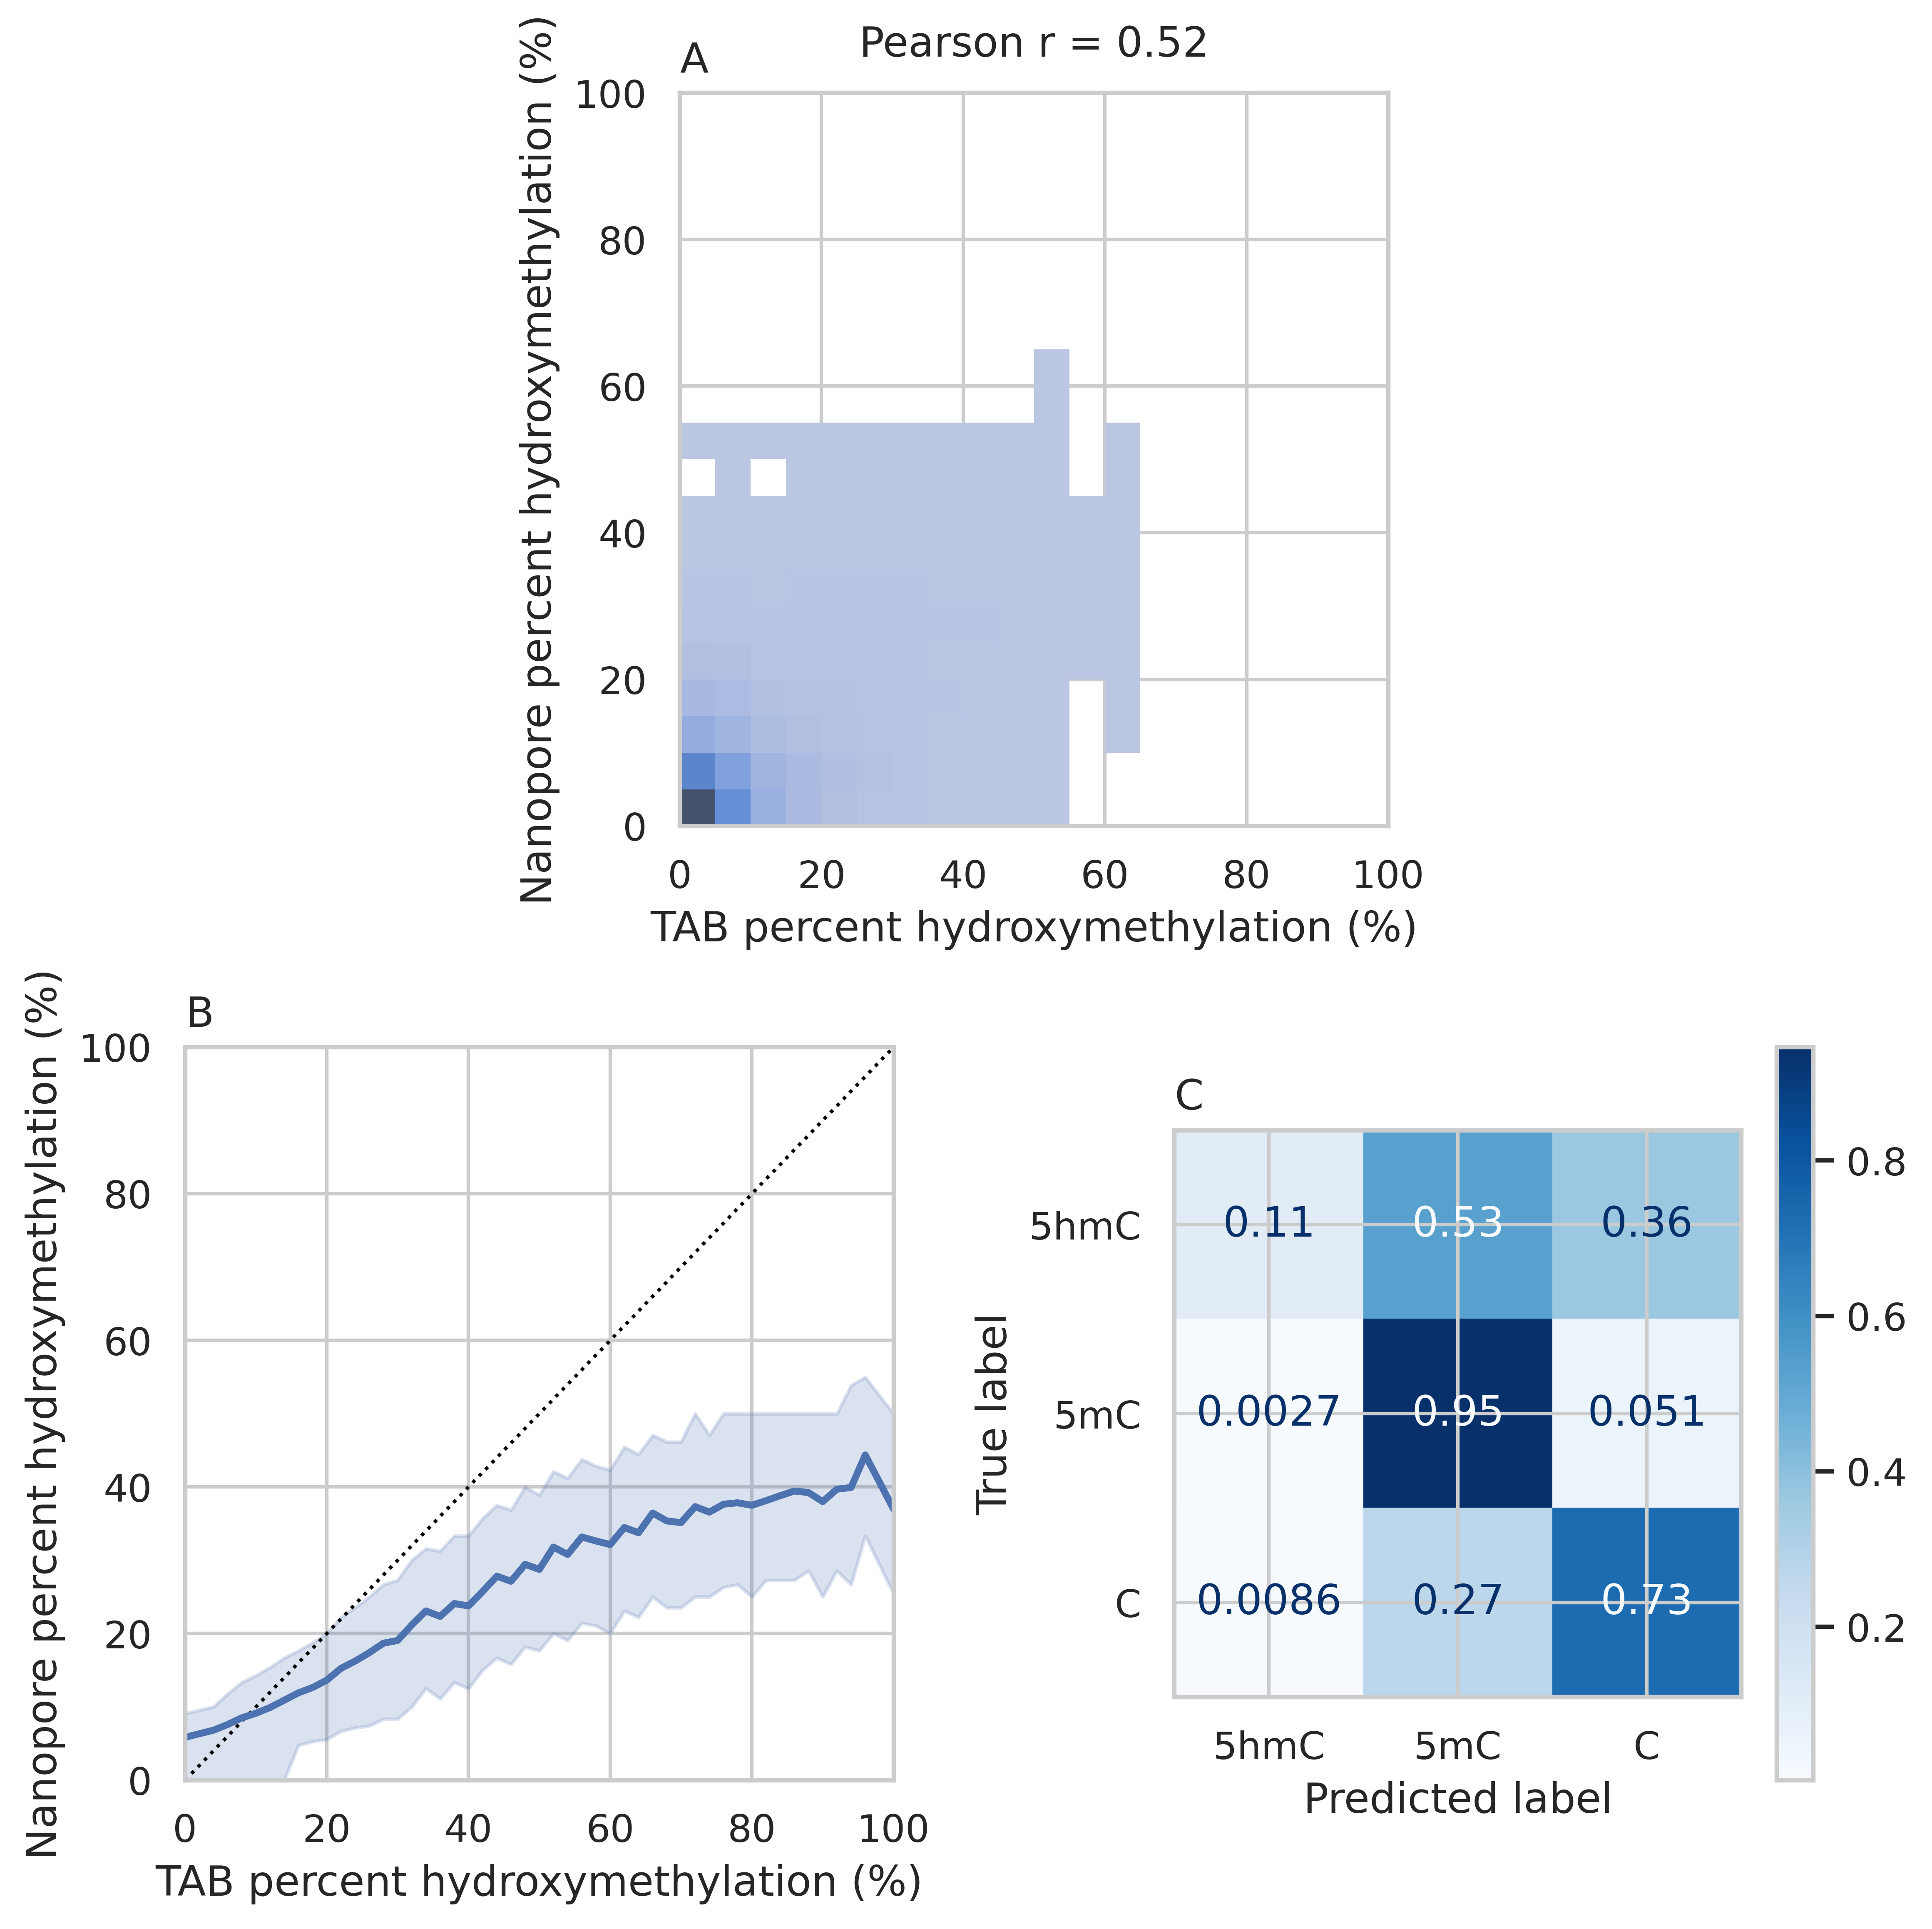

In [130]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=((20)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs = GridSpec(2, 4, fig)

ax1 = fig.add_subplot(gs[0, 1:3])
sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax1)
ax1.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax1.set_xlim((0, 100))
ax1.set_ylim((0, 100))
ax1.set_ylabel("Nanopore percent hydroxymethylation (%)")
ax1.set_xlabel("TAB percent hydroxymethylation (%)")
ax1.set_title("A", loc="left")

ax2 = fig.add_subplot(gs[1, :2])
ax2.plot(np.arange(0, 105, 5), np.arange(0, 105, 5), linestyle=":", lw=1, color="black")
sns.lineplot(binBenchmark(hmc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 50), err_style="band", linewidth=2, ax=ax2)
ax2.set_ylim((0, 100))
ax2.set_xlim((0, 100))
ax2.set_xlabel("TAB percent hydroxymethylation (%)")
ax2.set_ylabel("Nanopore percent hydroxymethylation (%)")
ax2.set_title("B", loc="left")

ax3 = fig.add_subplot(gs[1, 2:])
ConfusionMatrixDisplay.from_predictions(defineTruthset(), definePredictions(), normalize="true", cmap="Blues", ax=ax3)
ax3.set_title("C", loc="left")

fig.tight_layout()

In [6]:
import pyBigWig # required for bigWig output of pr 

def makeChromSizes():
    init = pd.read_csv('./feature_references/revised/mm39.chrom.sizes', sep="\t", names=["Chromosome", "End", "Start"])
    init["Start"] = 0
    init = init[["Chromosome", "Start", "End"]]
    return pr.PyRanges(init).sort()

In [ ]:
# three_mod_pr.to_bigwig('./outputs/nanopore_5hmC_chr1.bw', chromosome_sizes=makeChromSizes(), value_col="percentMeth_Nanopore_5hmC")

# Read level information at imprinted and non-imprinted sites

In [2]:
from modbampy import ModBam
import pandas as pd
import pyranges as pr
import numpy as np

In [92]:
# tiled_genome = pr.genomicfeatures.tile_genome(makeChromSizes(), 1000)
grb10_pr = pr.PyRanges(chromosomes="chr11", starts=[11878499], ends=[11989420], int64=True)
tiled_grb10_df = grb10_pr.tile(3000).as_df()
tiled_grb10_dict = tiled_grb10_df.to_dict("index")


In [117]:
with ModBam('./data/prom_R10.4.1_E8.2_WGS_brain_DH_grb10.bam') as bam:
    tile_list = []
    tile_id = 1
    for tile in tiled_grb10_dict.values():
        read_list = []
        for read in bam.reads(tile["Chromosome"], tile["Start"], tile["End"]):
            read_sites = []
            for mod_position in read.mod_sites:
                mod_position_info = [tile_id, tile["Chromosome"], tile["Start"], tile["End"]]
                for datum in mod_position:
                    mod_position_info.append(datum)
                read_sites.append(mod_position_info)
            read_list.extend(read_sites)
        tile_list.extend(read_list)
        tile_id += 1 
names=["tile", "chromosome", "chromStart", "chromEnd", "read", "refPos", "qPos", "refStrand", "modStrand", "base", "mod", "score"]
tile_df = pd.DataFrame(tile_list, columns=names)
    
def filterTile(tile): 
    # tile_df.loc[tile_df["refStrand"] == "-", "refPos"] = tile_df["refPos"].sub(2, axis=0)
    one_tile_df = tile_df.loc[(tile_df["tile"] == tile) & (tile_df["refPos"].ge(tile_df["chromStart"])) & (tile_df["refPos"].lt(tile_df["chromEnd"]))] 
    
    tile_df_pivot1 = one_tile_df.pivot(index=["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], columns="mod", values="score").reset_index()
    tile_df_pivot1["c"] = 255 - tile_df_pivot1[["h", "m"]].sum(axis=1)
    tile_df_melt = pd.melt(tile_df_pivot1, ["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], ["h", "m", "c"], "mod", "score")
    tile_df_melt = tile_df_melt.loc[tile_df_melt["score"] >= 0.66*255]
    tile_df_melt.loc[tile_df_melt["refStrand"] == "-", "refPos"] = tile_df_melt["refPos"].sub(1, axis=0)

    return tile_df_melt.reset_index(drop=True)

def pivotToHeatmap(df):
    df = df.pivot(index="read", columns=["refPos"], values="mod")
    df[df == "c"] = 0
    df[df == "h"] = 2
    df[df == "m"] = 1
    
    return df

def NADropper(df):
    new_df = df.dropna(thresh=len(df)*0.2, axis="columns") # removes CpGs present in fewer than 20% of reads
    new_df = new_df.dropna(thresh=len(new_df.columns)*0.50, axis="index") # removes reads with fewer than x% of CpGs
    return new_df

def makeHeatmap(tile):

    data = NADropper(pivotToHeatmap(filterTile(tile)))

    fig = sns.clustermap(data.fillna(-1), 
                mask=data.isna(), 
                xticklabels=10, yticklabels=False,
                col_cluster=False, row_cluster=True, 
                cmap=sns.color_palette("Blues", 3),
                cbar_kws={"ticks" : [0, 1, 2],
                        "orientation" : "horizontal"},
                figsize=(10, 10))

    fig.ax_cbar.set_position([0.40, 0.85, 0.3, 0.03])
    fig.ax_cbar.set_xticks([0.33, 1, 1.66])
    fig.ax_cbar.set_xticklabels(["C", "5mC", "5hmC"])
    fig.ax_cbar.set_title("Modification type", fontdict={"fontsize" : 10})
    fig.ax_heatmap.set_ylabel("Read")
    fig.ax_heatmap.set_xlabel("CpG position")

    return fig

In [114]:
tile_df.groupby("tile")[["chromStart", "chromEnd"]].first()

chromStart  chromEnd
tile                      
1       11877000  11880000
2       11880000  11883000
3       11883000  11886000
4       11886000  11889000
5       11889000  11892000
6       11892000  11895000
7       11895000  11898000
8       11898000  11901000
9       11901000  11904000
10      11904000  11907000
11      11907000  11910000
12      11910000  11913000
13      11913000  11916000
14      11916000  11919000
15      11919000  11922000
16      11922000  11925000
17      11925000  11928000
18      11928000  11931000
19      11931000  11934000
20      11934000  11937000
21      11937000  11940000
22      11940000  11943000
23      11943000  11946000
24      11946000  11949000
25      11949000  11952000
26      11952000  11955000
27      11955000  11958000
28      11958000  11961000
29      11961000  11964000
30      11964000  11967000
31      11967000  11970000
32      11970000  11973000
33      11973000  11976000
34      11976000  11979000
35      11979000  11982000
36      11982000  11985000
37      11985000  11988000
38      11988000  11991000

In [116]:
tile_df.loc[tile_df["tile"] == 33].sort_values("refPos")

tile chromosome  chromStart  chromEnd  \
181252    33      chr11    11973000  11976000   
194576    33      chr11    11973000  11976000   
194577    33      chr11    11973000  11976000   
194578    33      chr11    11973000  11976000   
194579    33      chr11    11973000  11976000   
...      ...        ...         ...       ...   
188252    33      chr11    11973000  11976000   
188254    33      chr11    11973000  11976000   
188255    33      chr11    11973000  11976000   
188256    33      chr11    11973000  11976000   
188257    33      chr11    11973000  11976000   

                                        read    refPos   qPos refStrand  \
181252  7891376e-f9d7-4df9-b0cc-17a12e55e44d        -1      4         -   
194576  5c502d71-defd-466a-82fc-97caa5fdc7cf        -1   9579         -   
194577  5c502d71-defd-466a-82fc-97caa5fdc7cf        -1   9579         -   
194578  5c502d71-defd-466a-82fc-97caa5fdc7cf        -1   9621         -   
194579  5c502d71-defd-466a-82fc-97caa5fdc7cf        -1   9621         -   
...                                      ...       ...    ...       ...   
188252  5a278f8c-c195-4f35-b652-5ccc540a8215  11986032  12834         +   
188254  5a278f8c-c195-4f35-b652-5ccc540a8215  11986037  12839         +   
188255  5a278f8c-c195-4f35-b652-5ccc540a8215  11986037  12839         +   
188256  5a278f8c-c195-4f35-b652-5ccc540a8215  11986134  12936         +   
188257  5a278f8c-c195-4f35-b652-5ccc540a8215  11986134  12936         +   

        modStrand base mod  score  
181252          0    C   h      2  
194576          0    C   h     70  
194577          0    C   m    185  
194578          0    C   h      0  
194579          0    C   m    255  
...           ...  ...  ..    ...  
188252          0    C   h    254  
188254          0    C   h     71  
188255          0    C   m      1  
188256          0    C   h      5  
188257          0    C   m      0  

[18868 rows x 12 columns]

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/matrix.py:715: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self._figure = plt.figure(figsize=figsize)


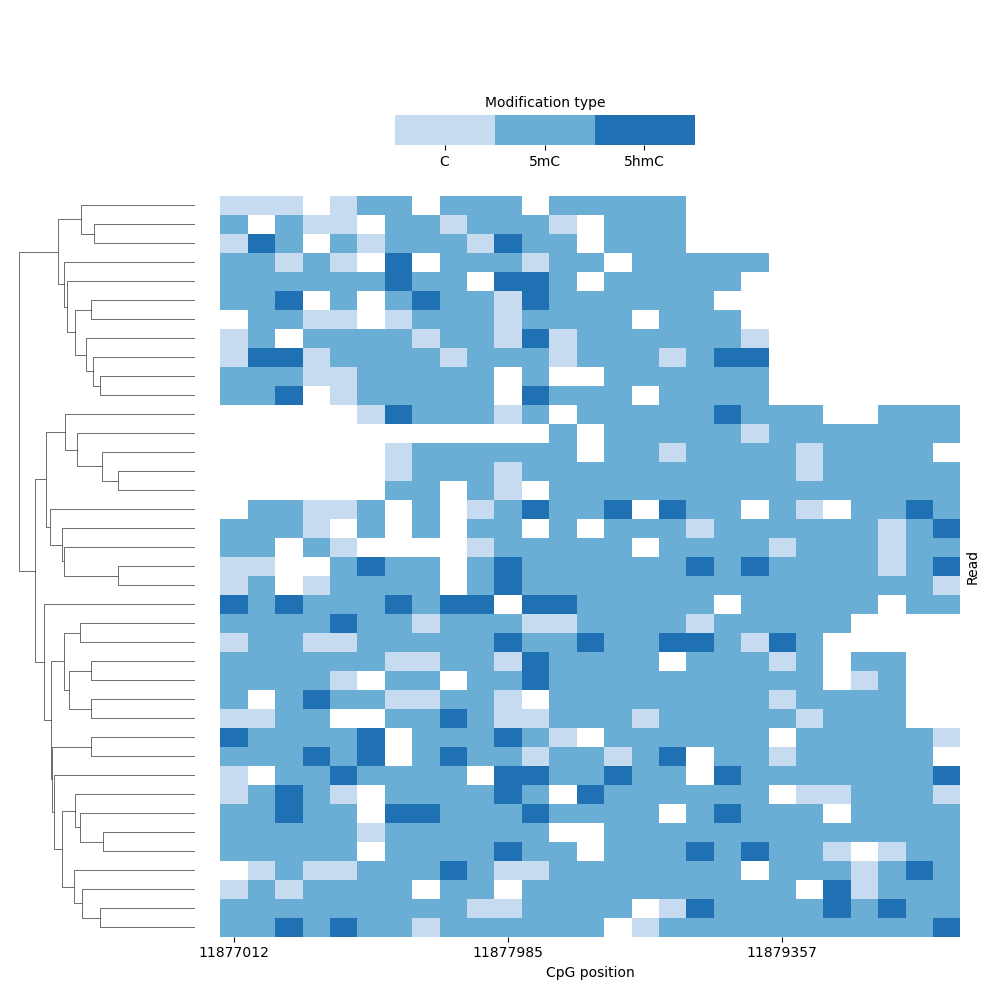

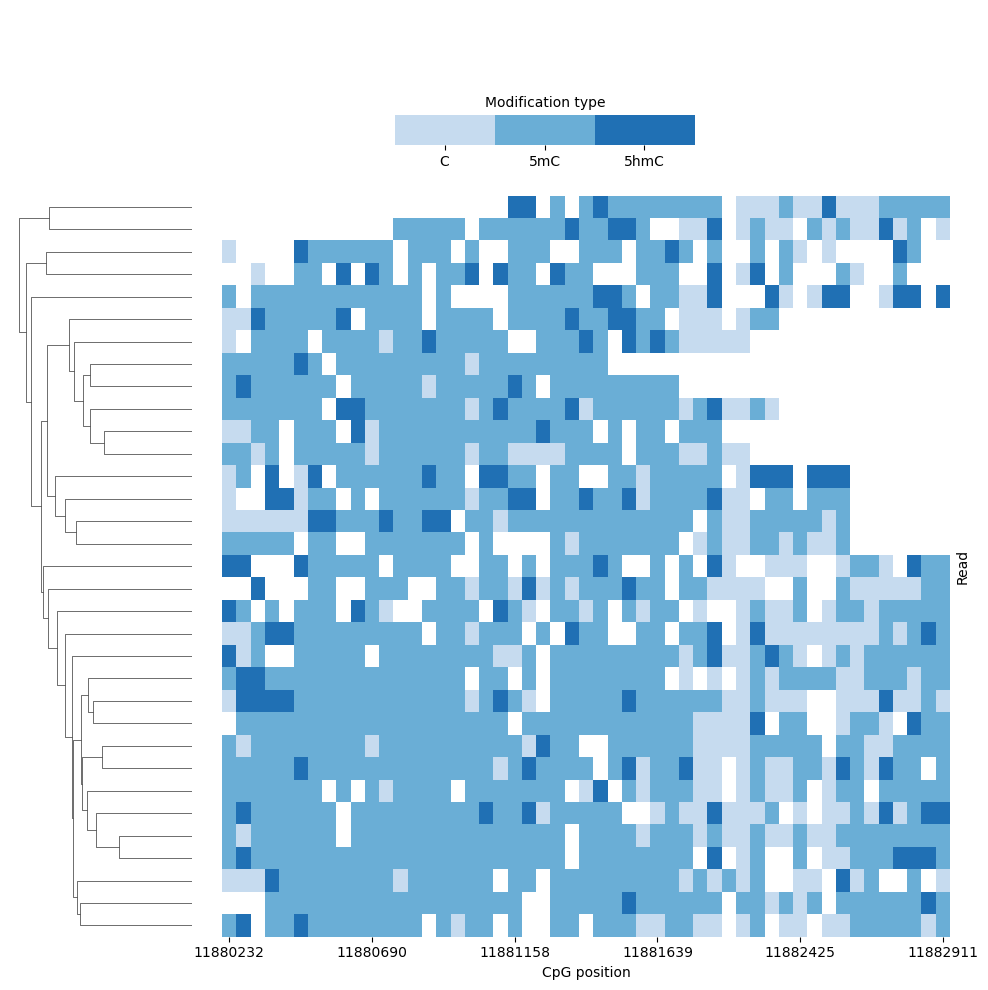

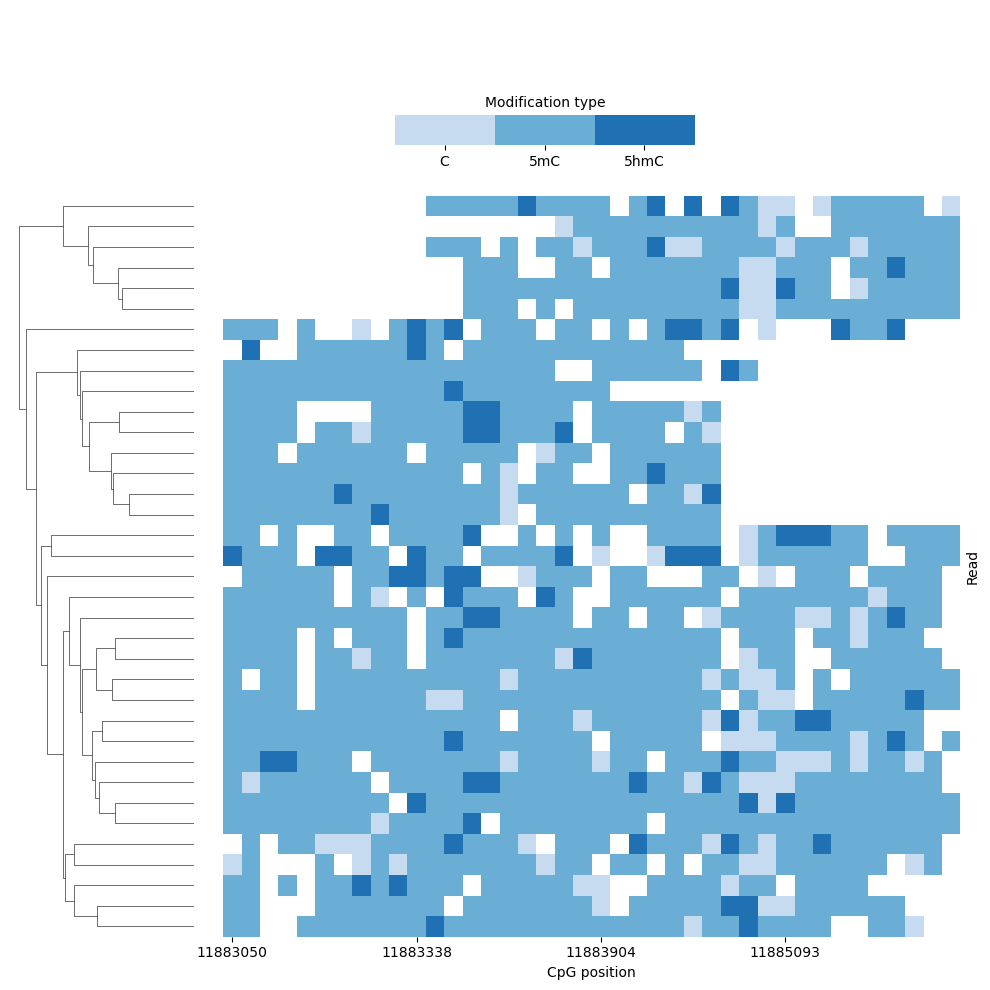

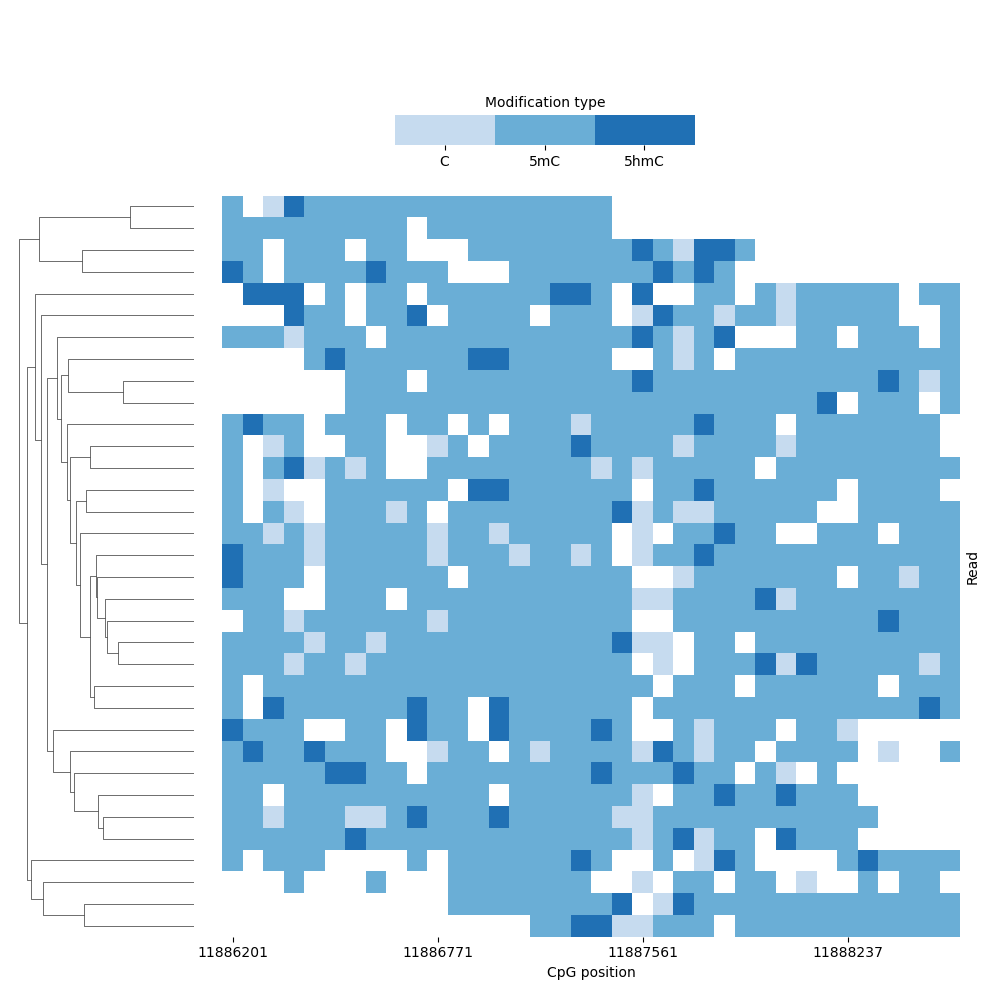

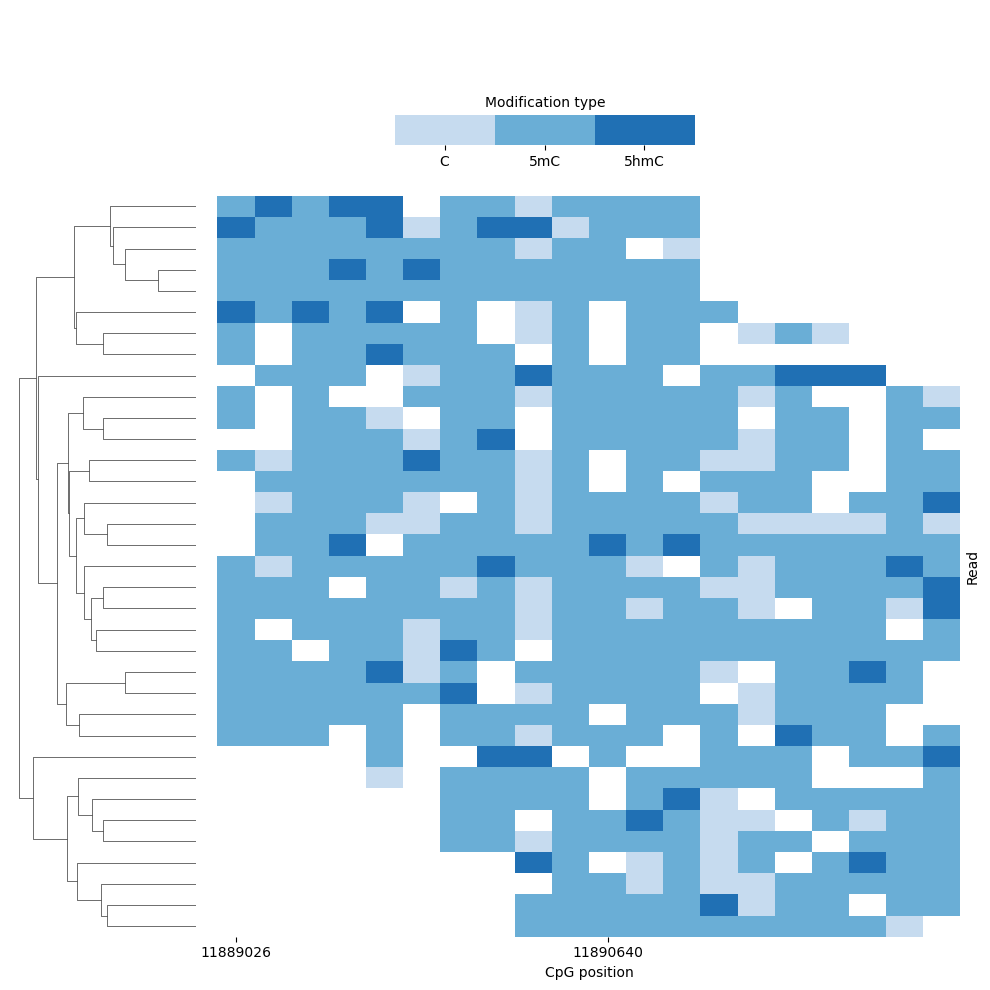

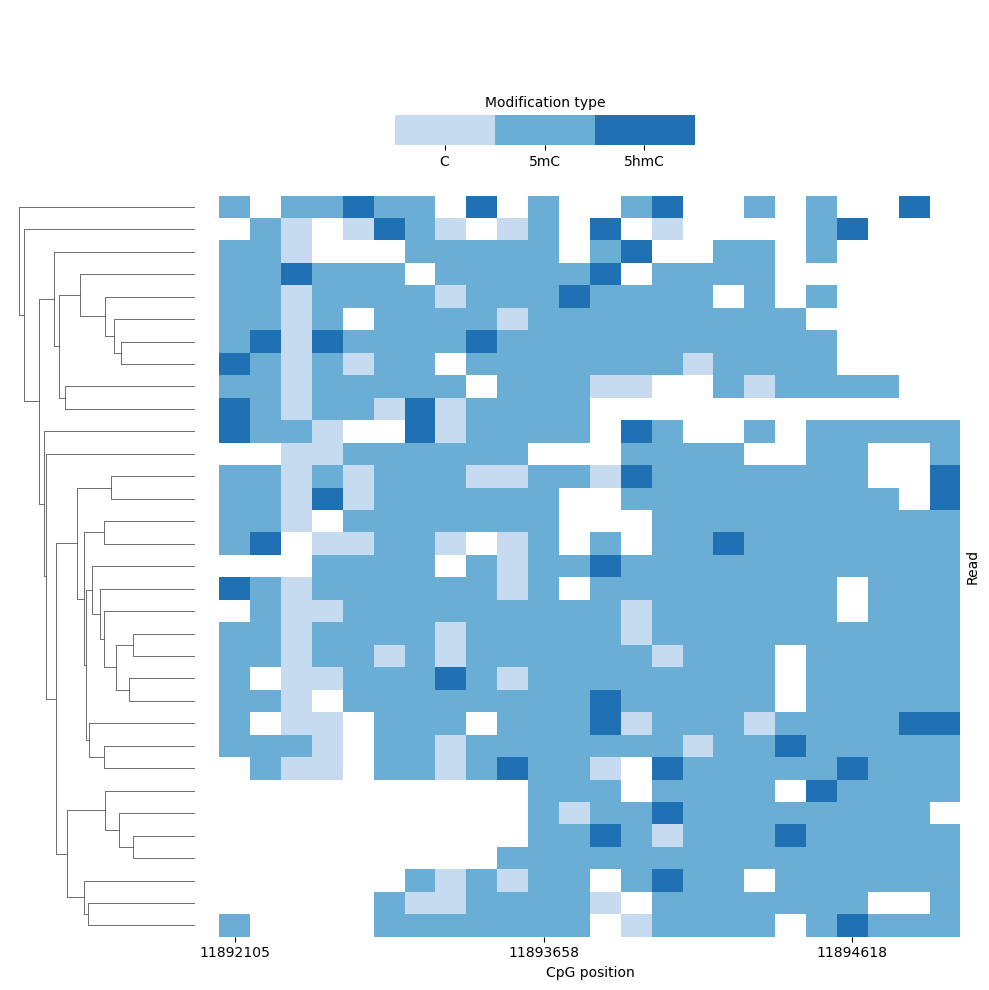

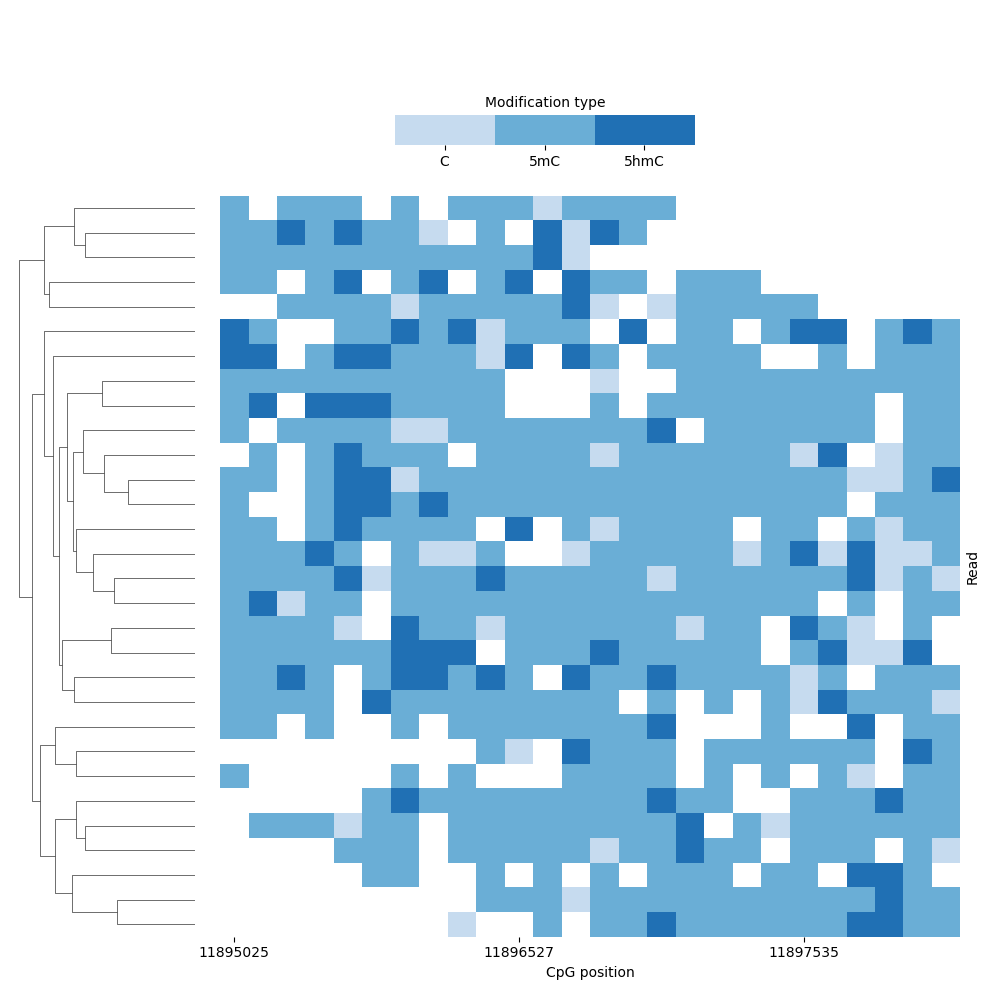

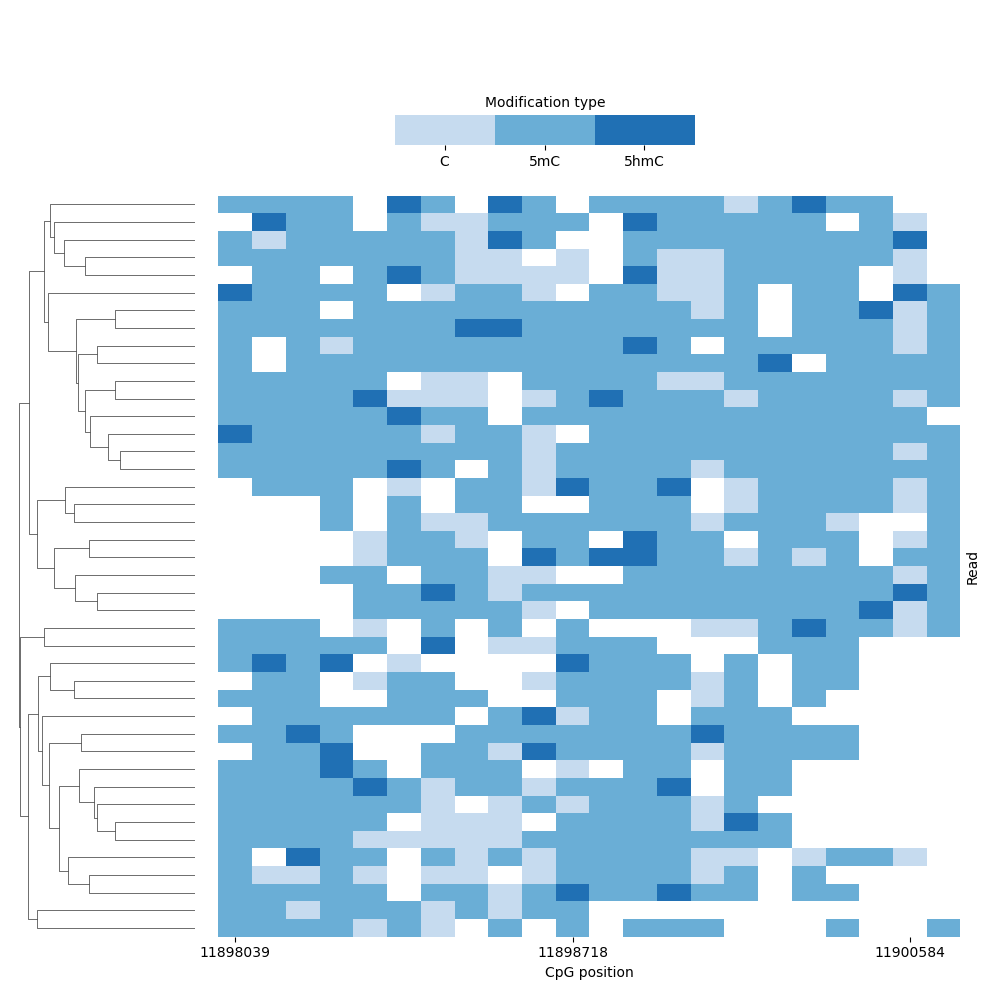

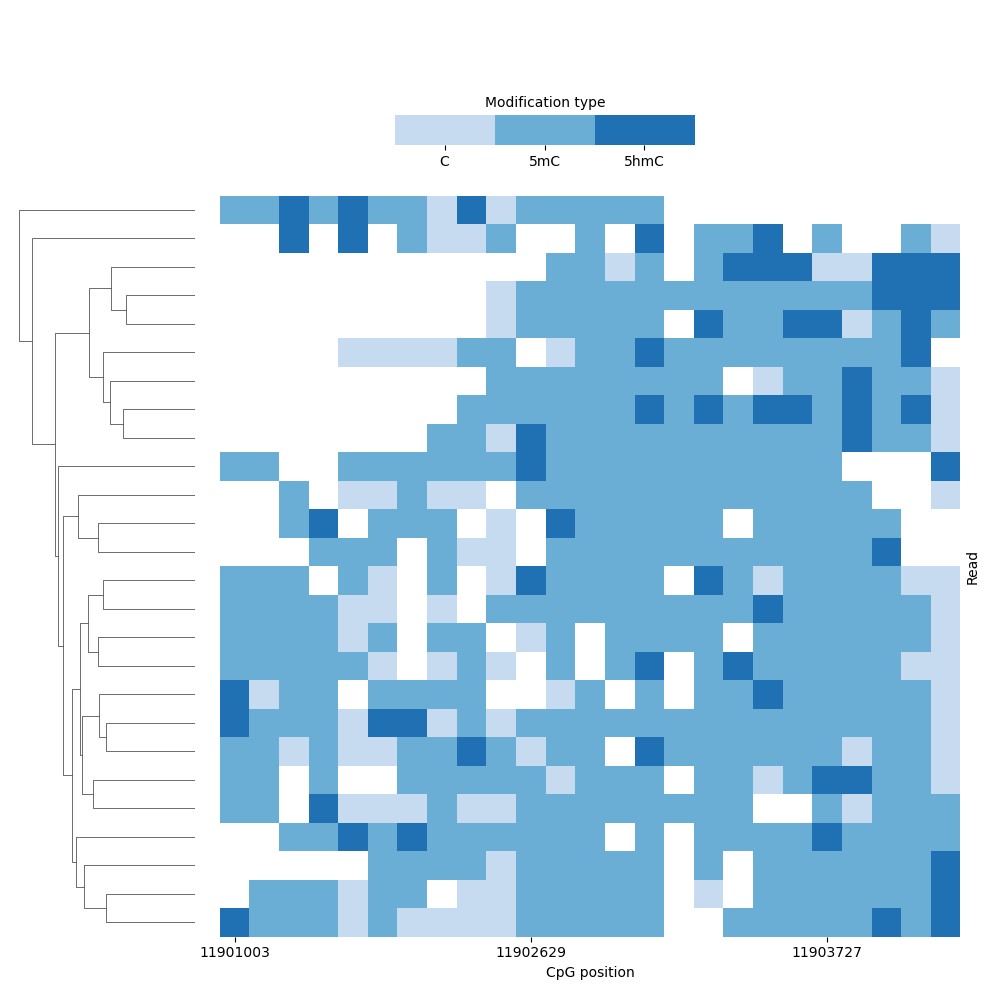

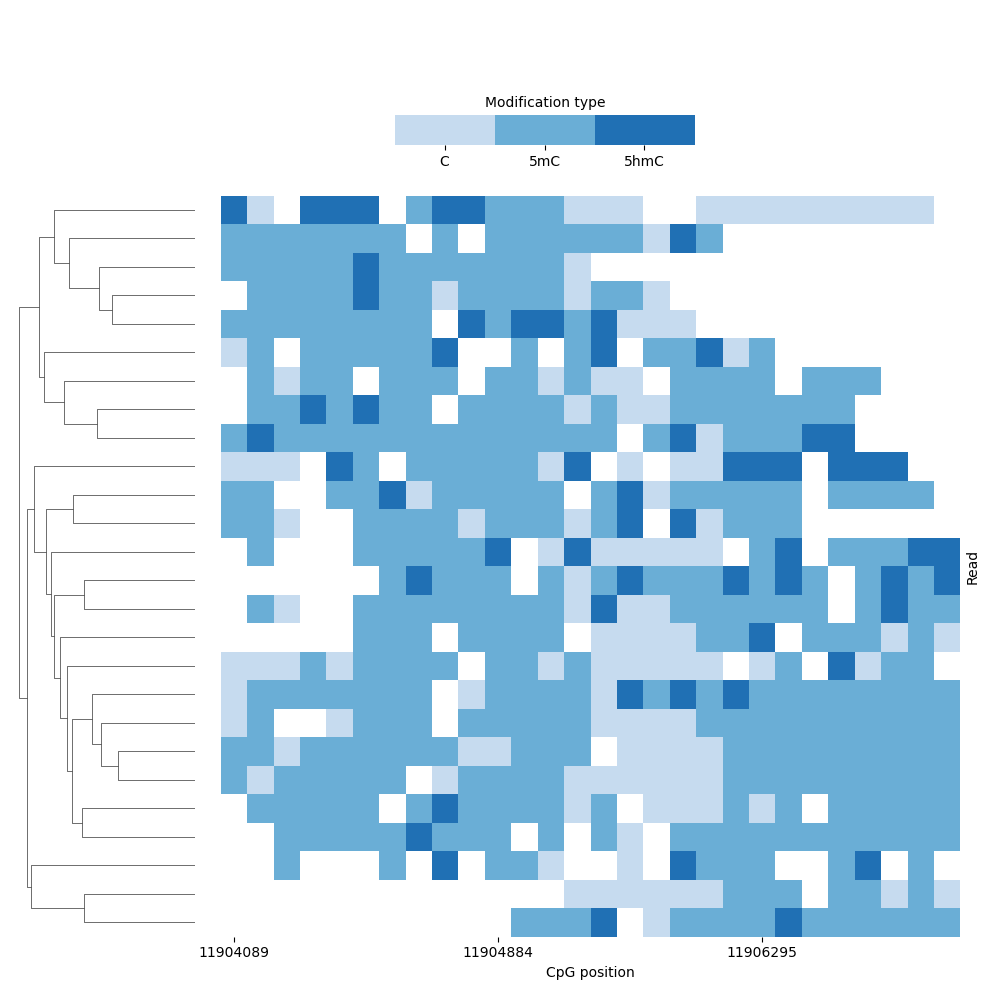

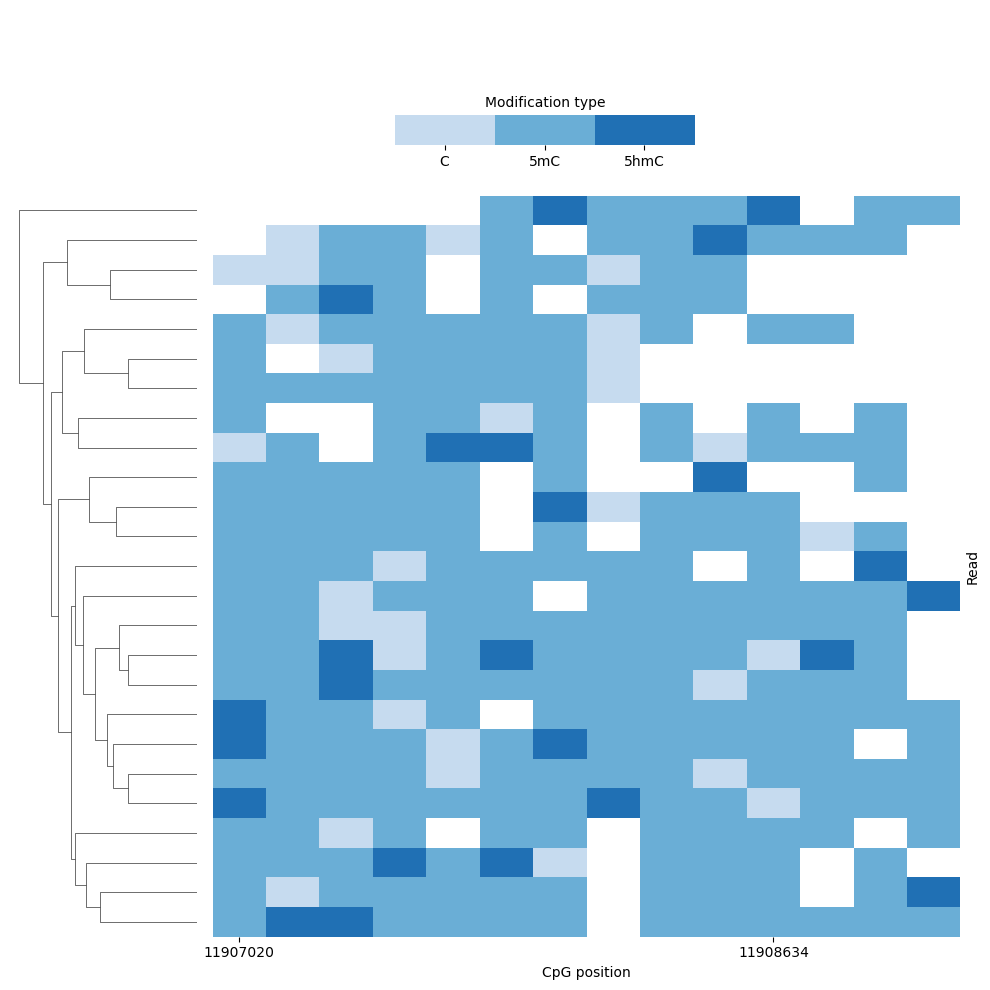

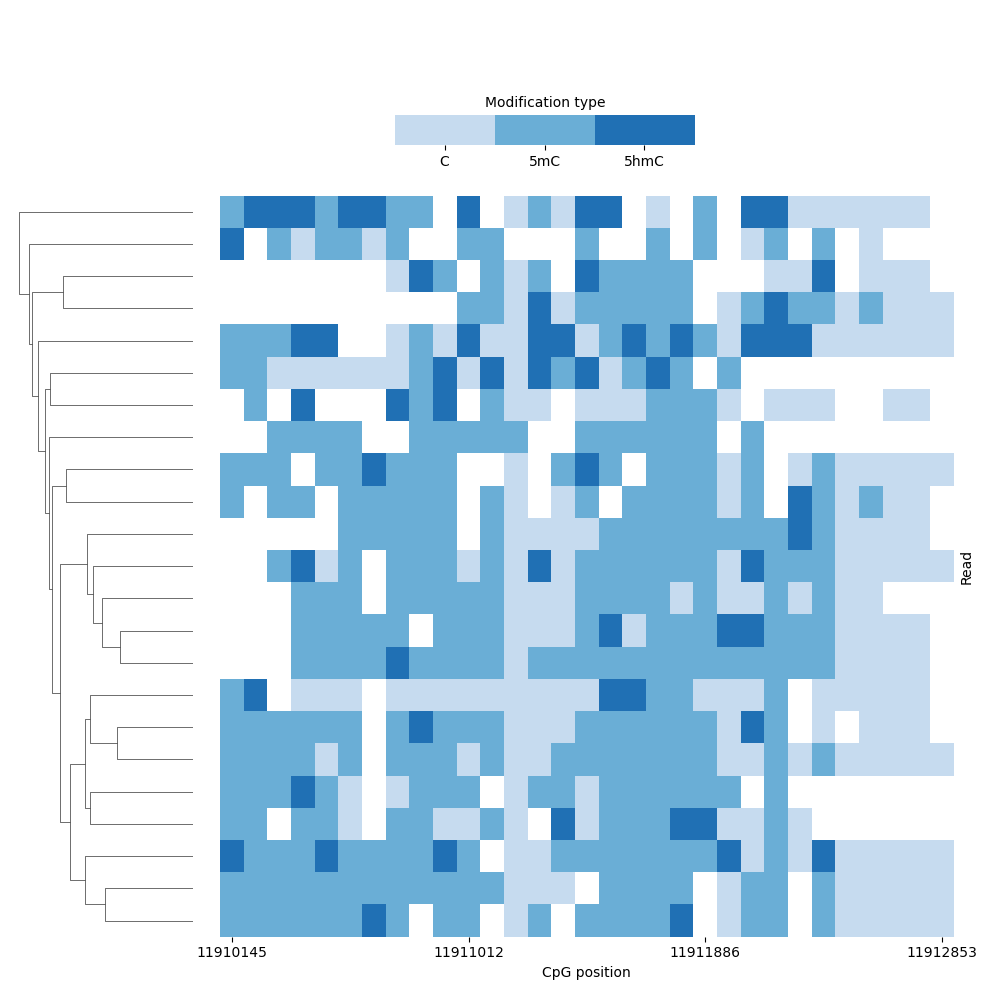

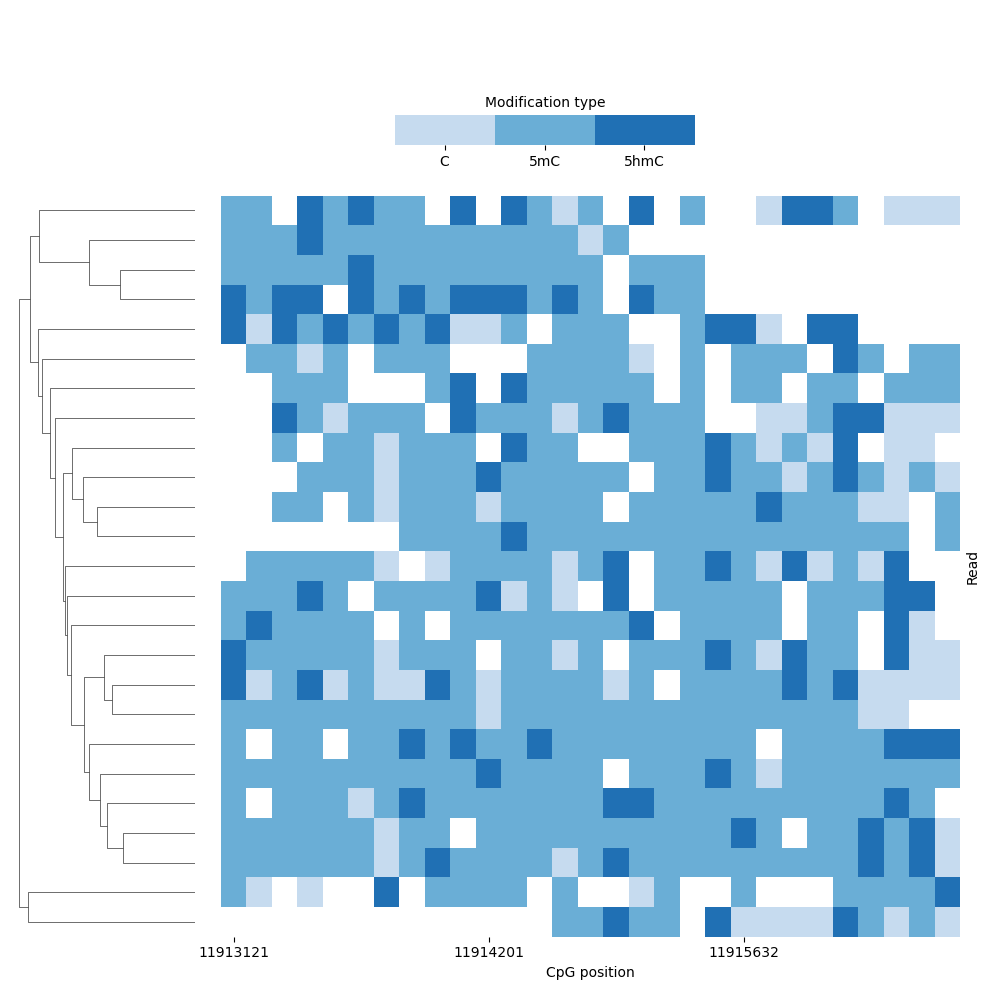

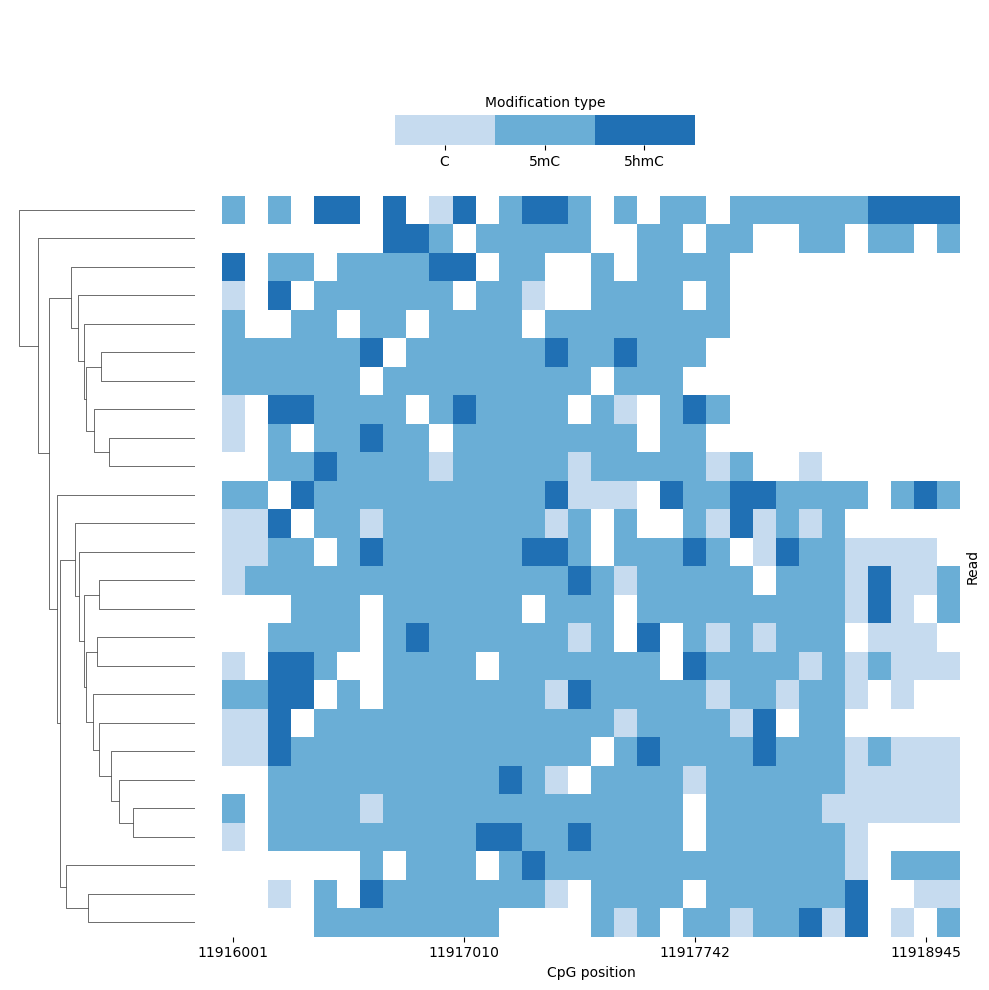

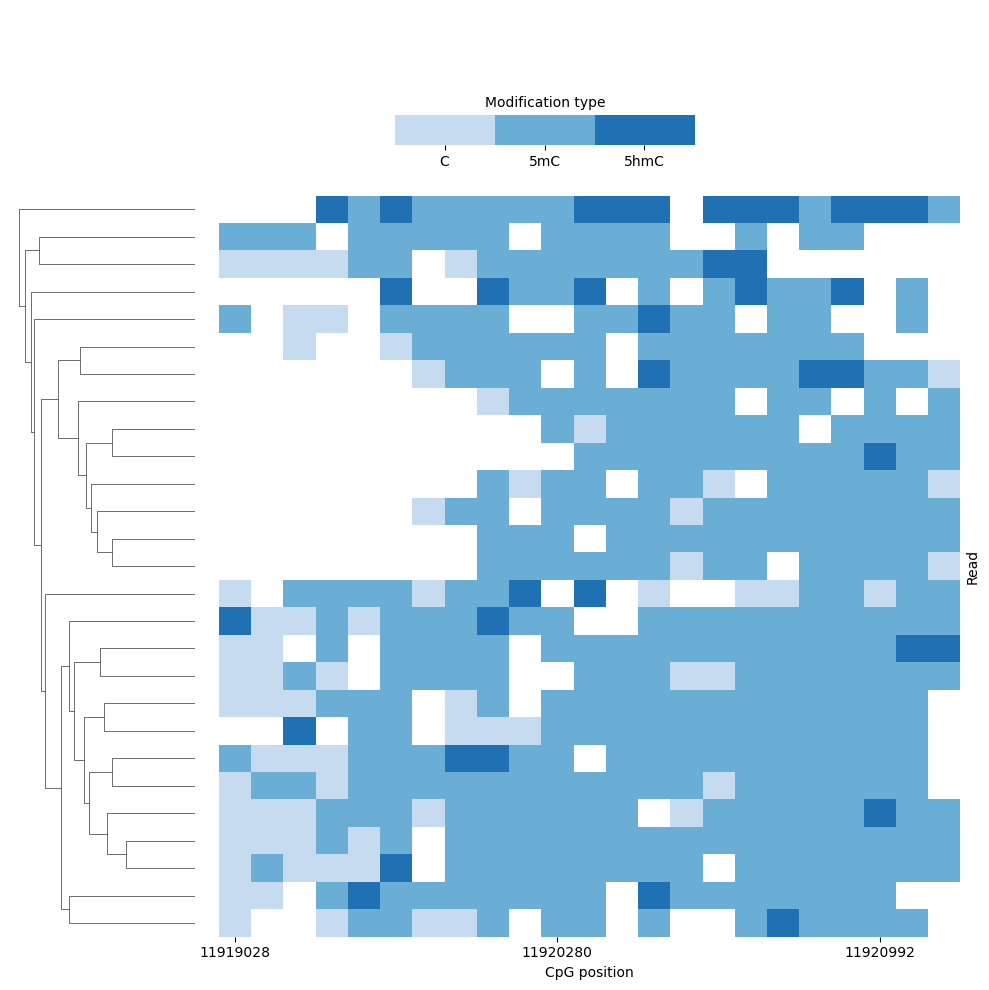

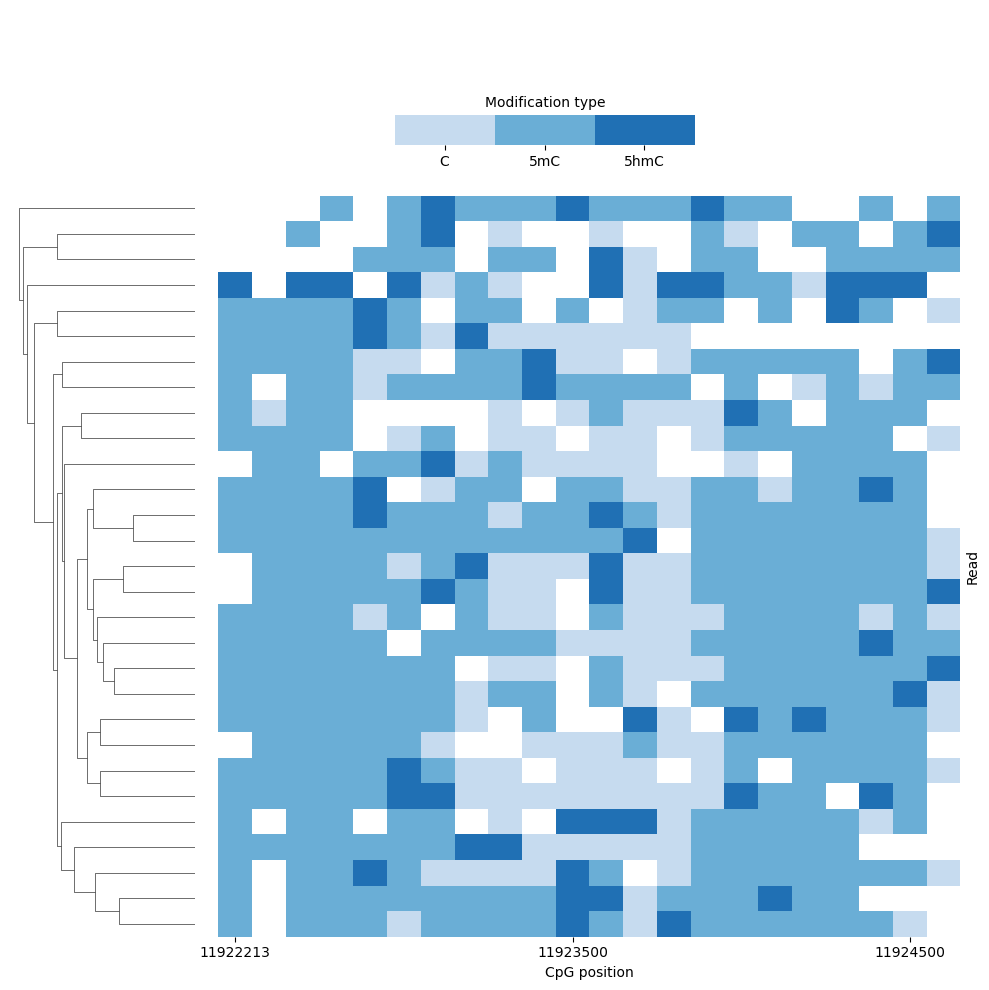

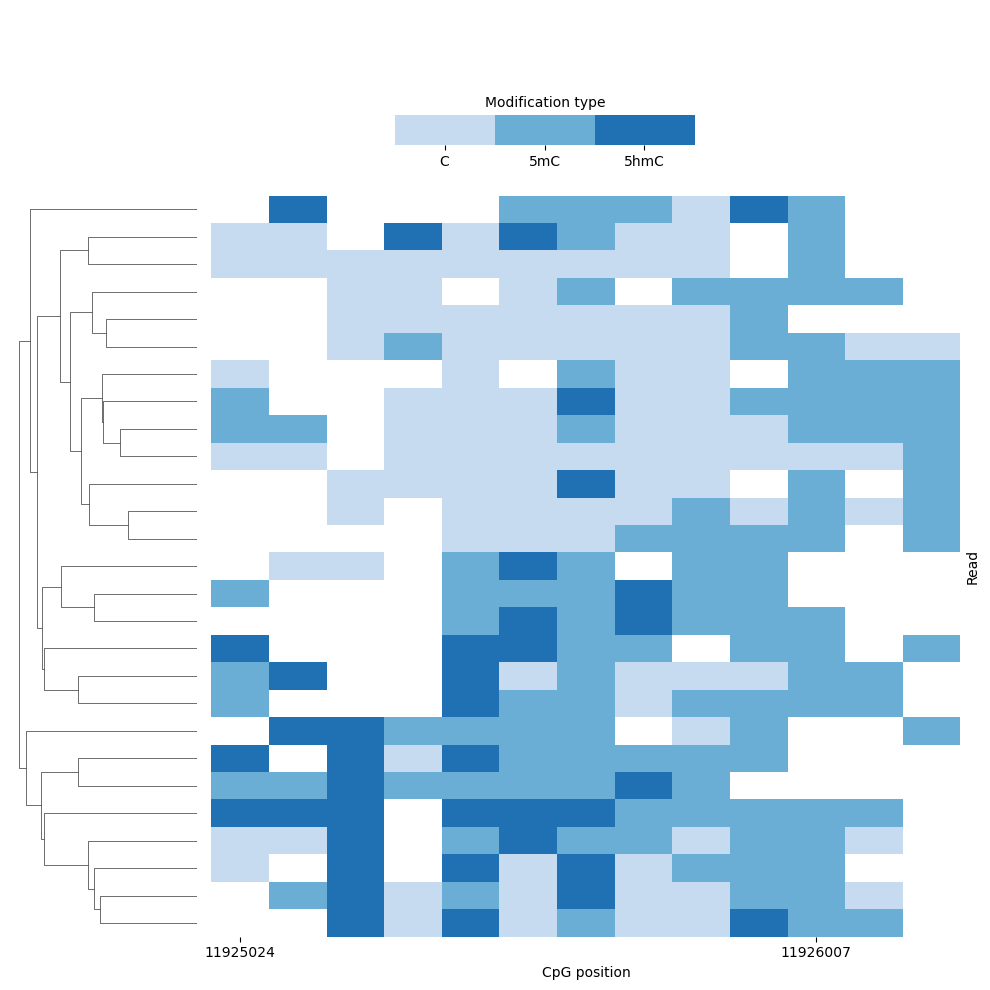

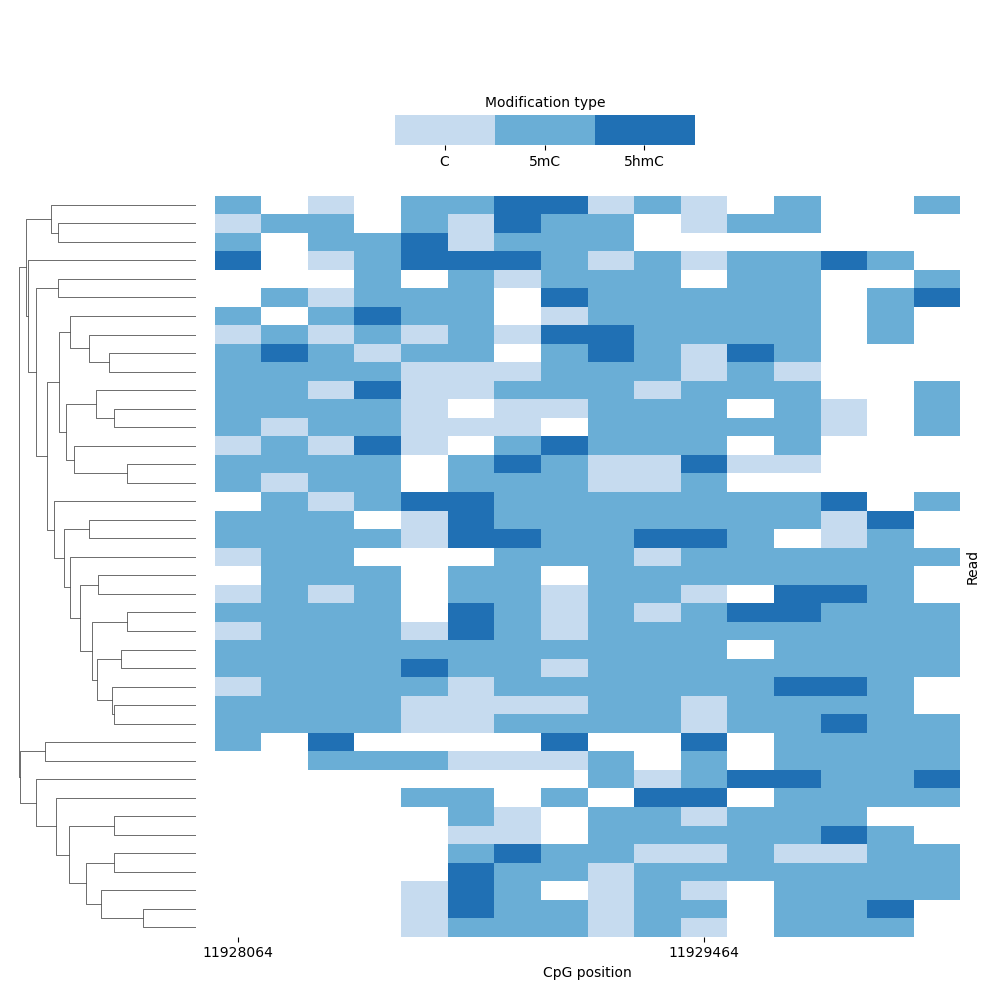

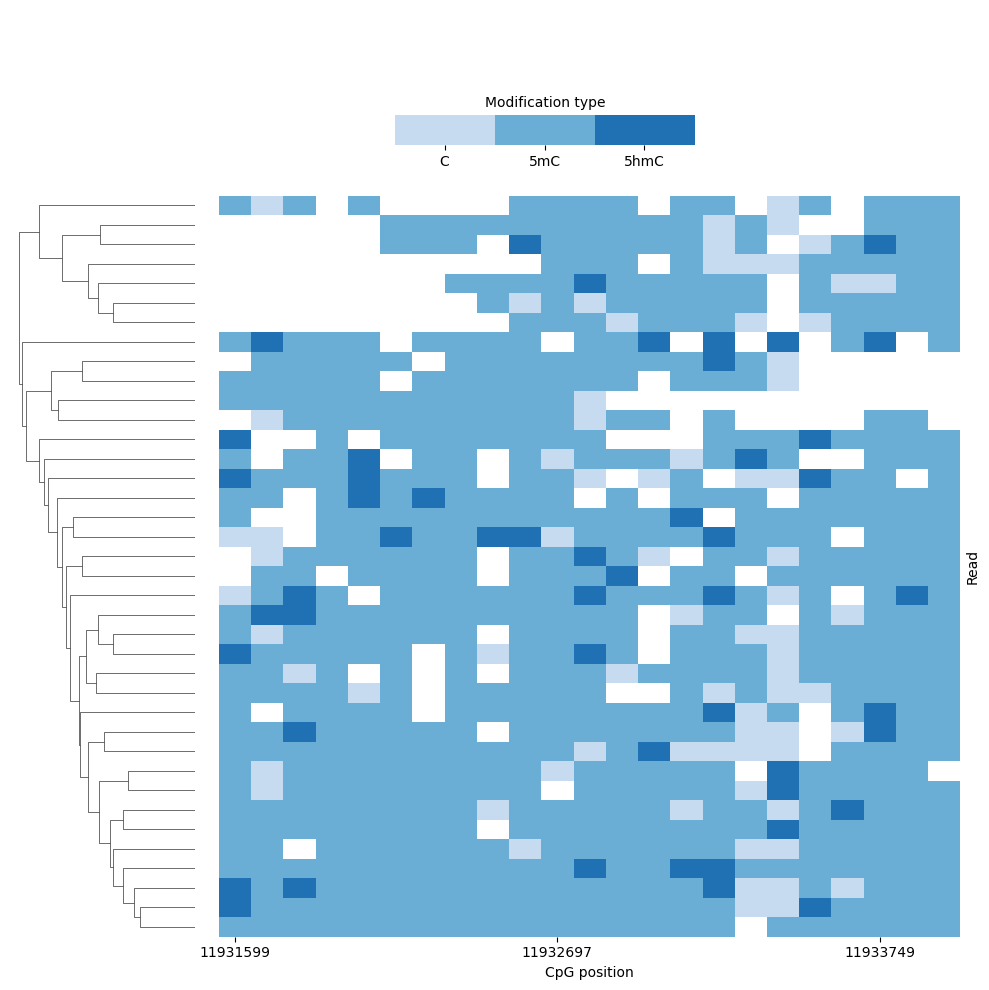

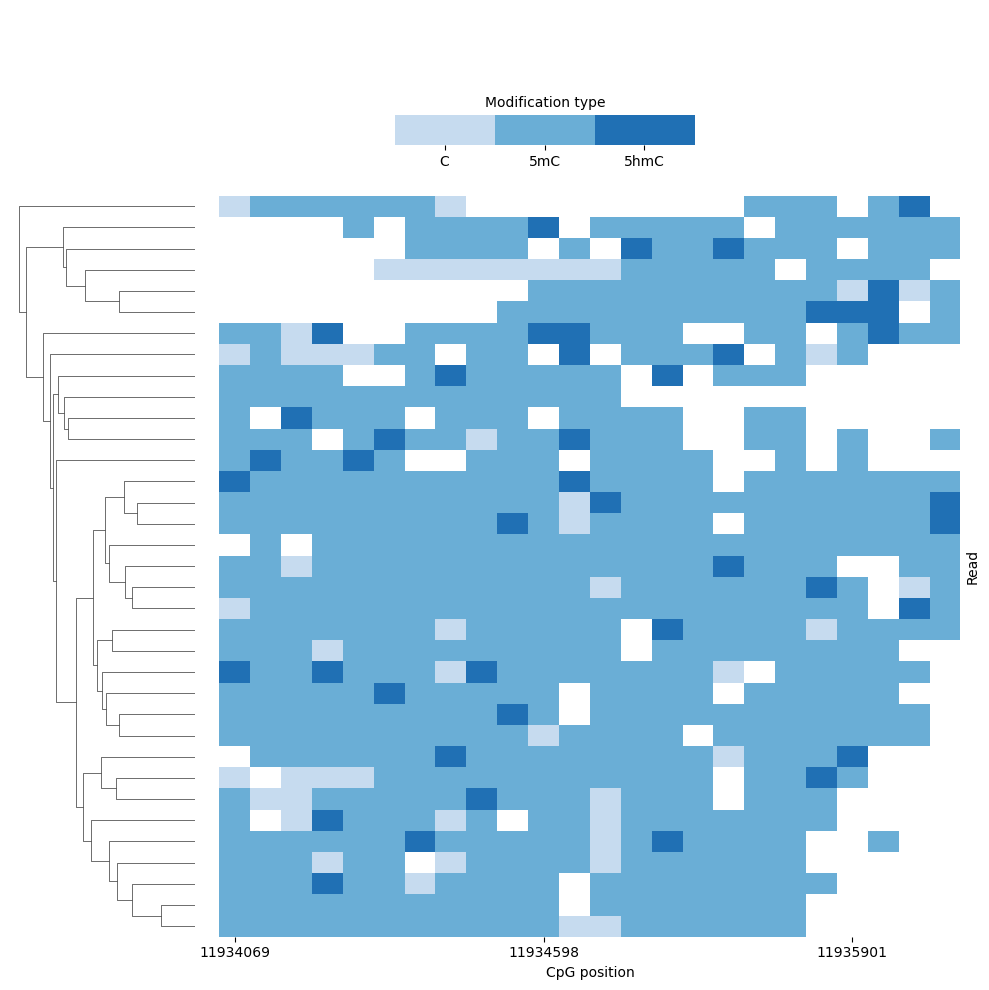

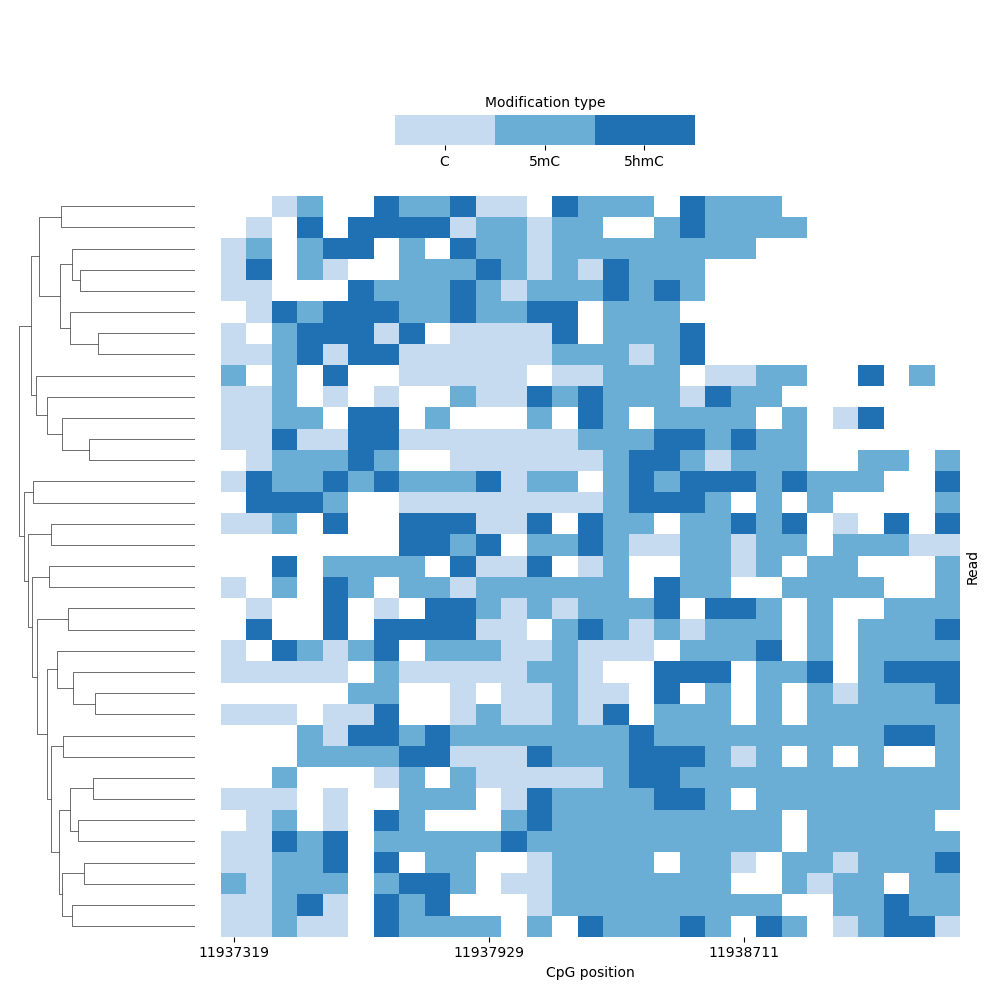

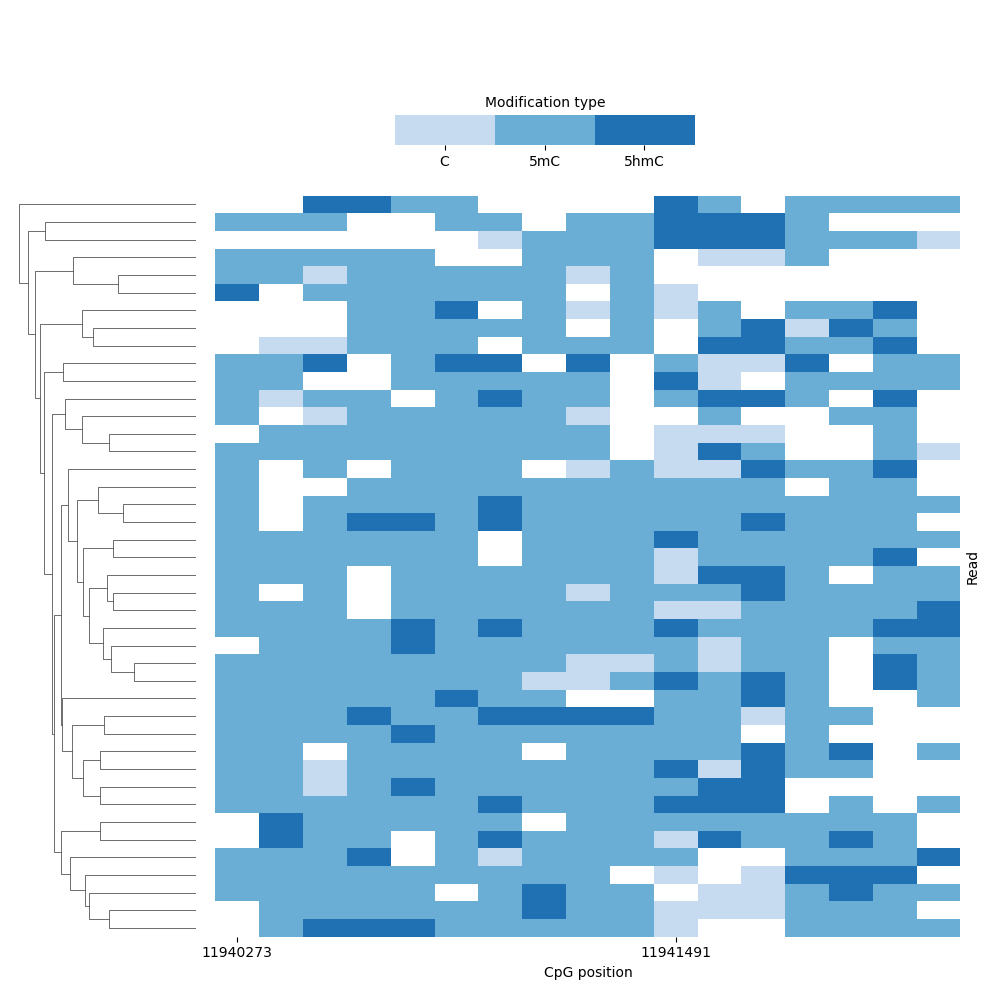

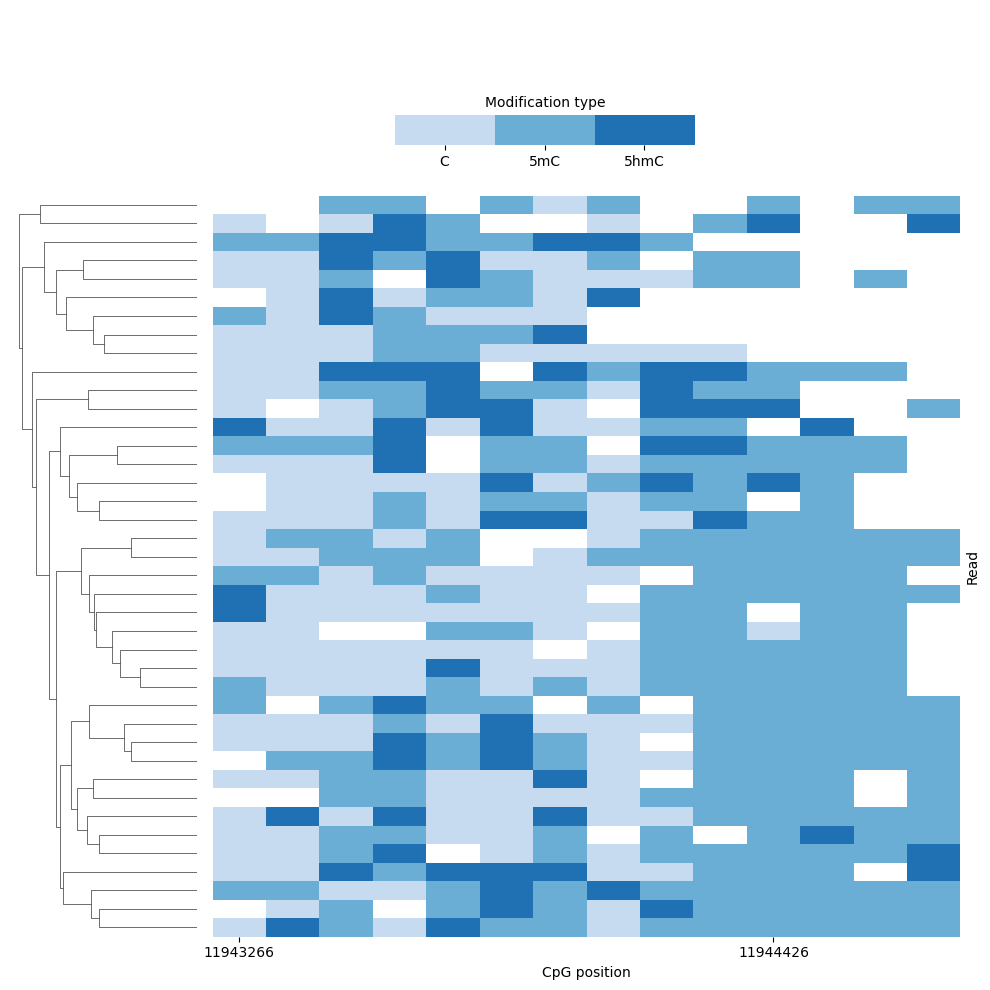

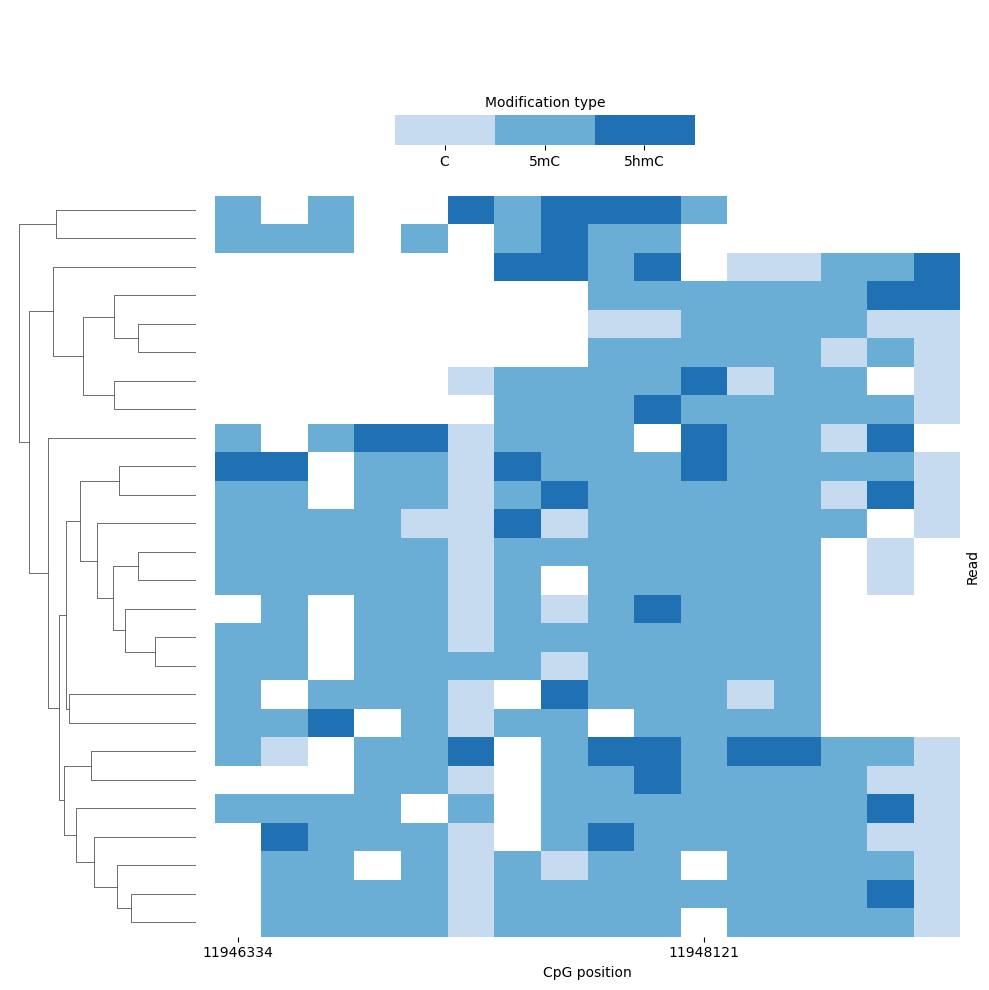

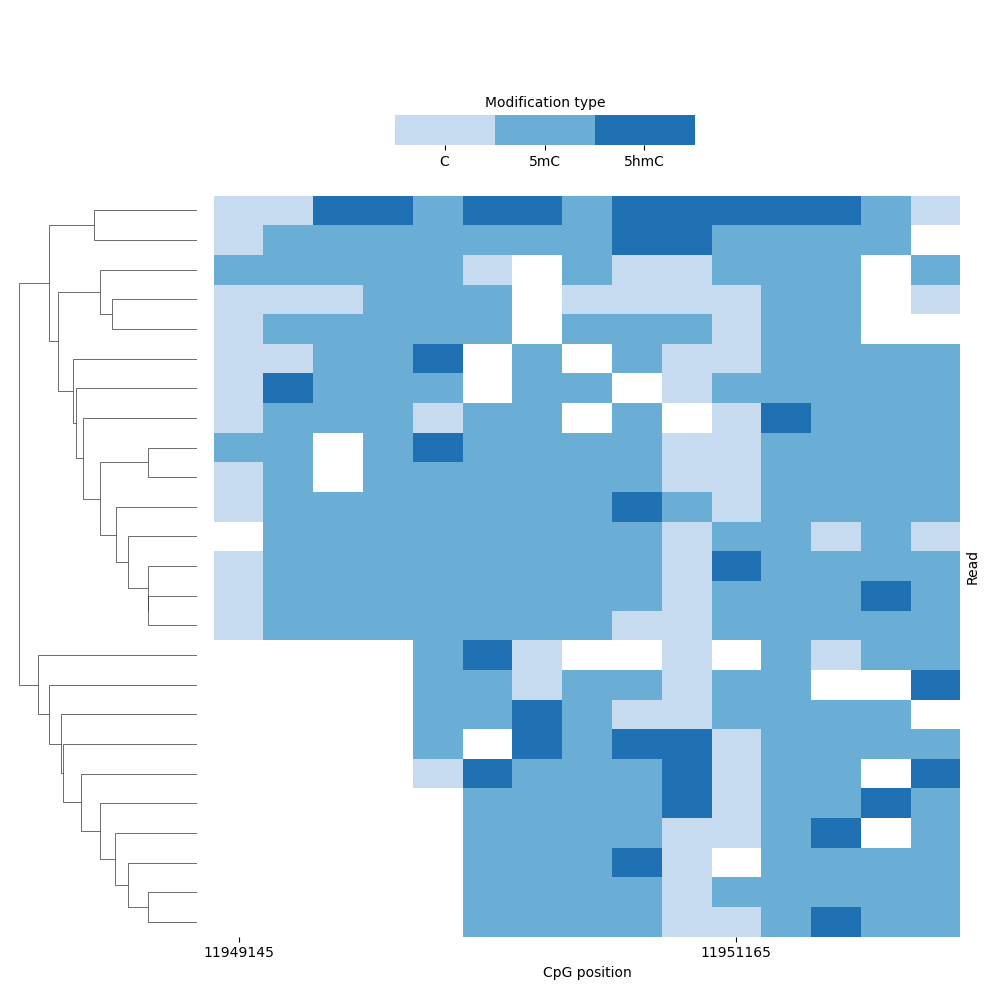

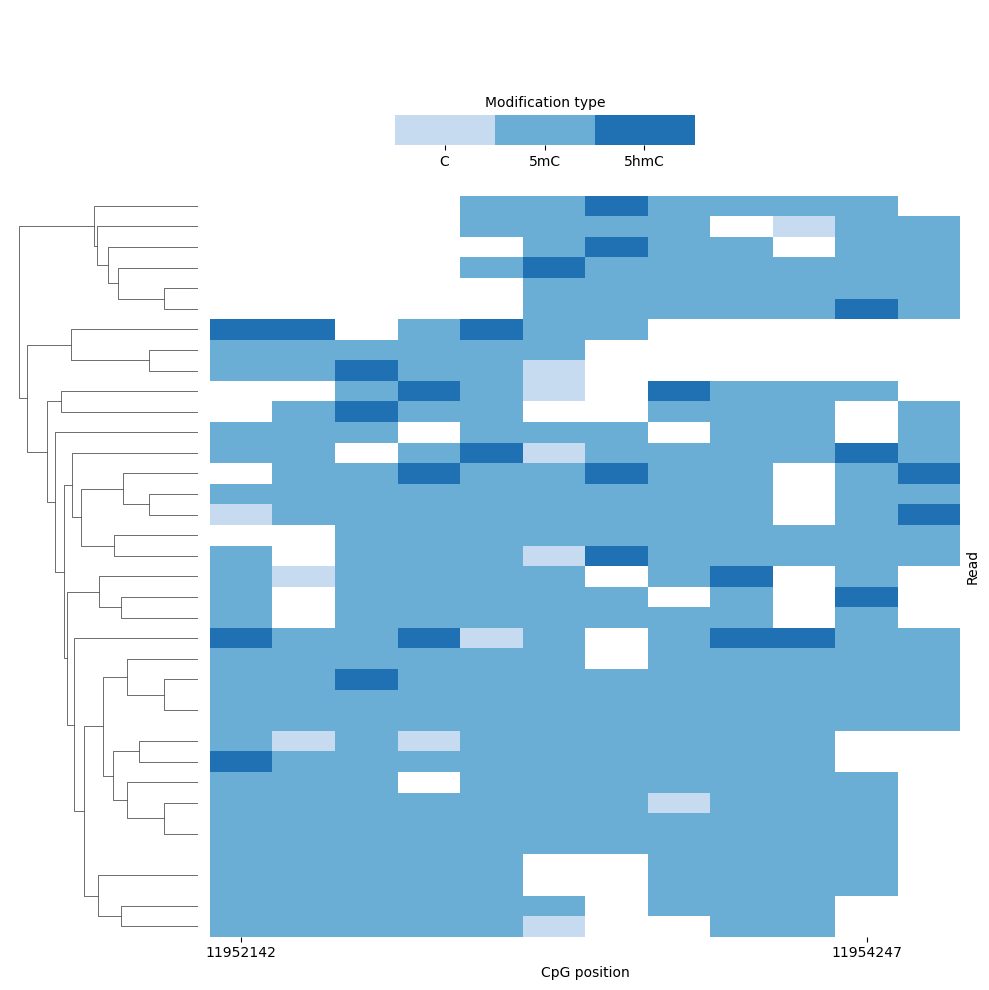

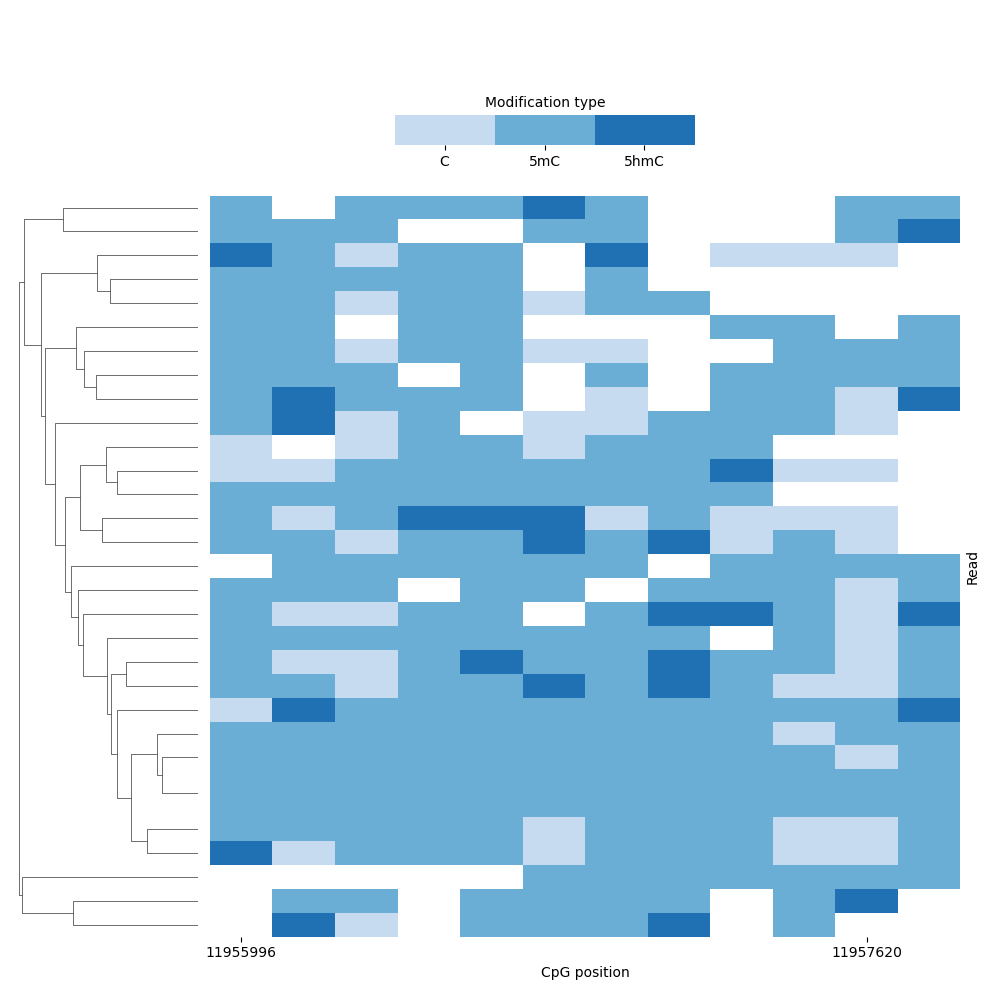

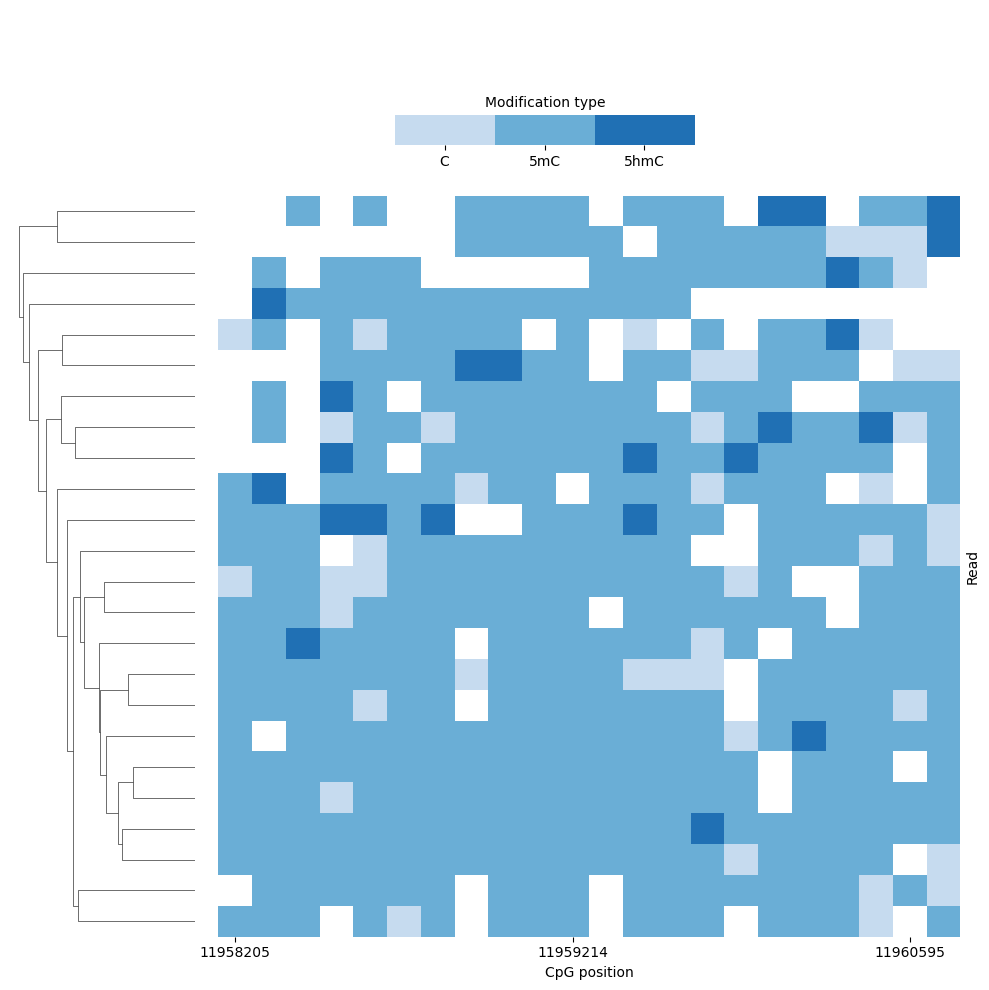

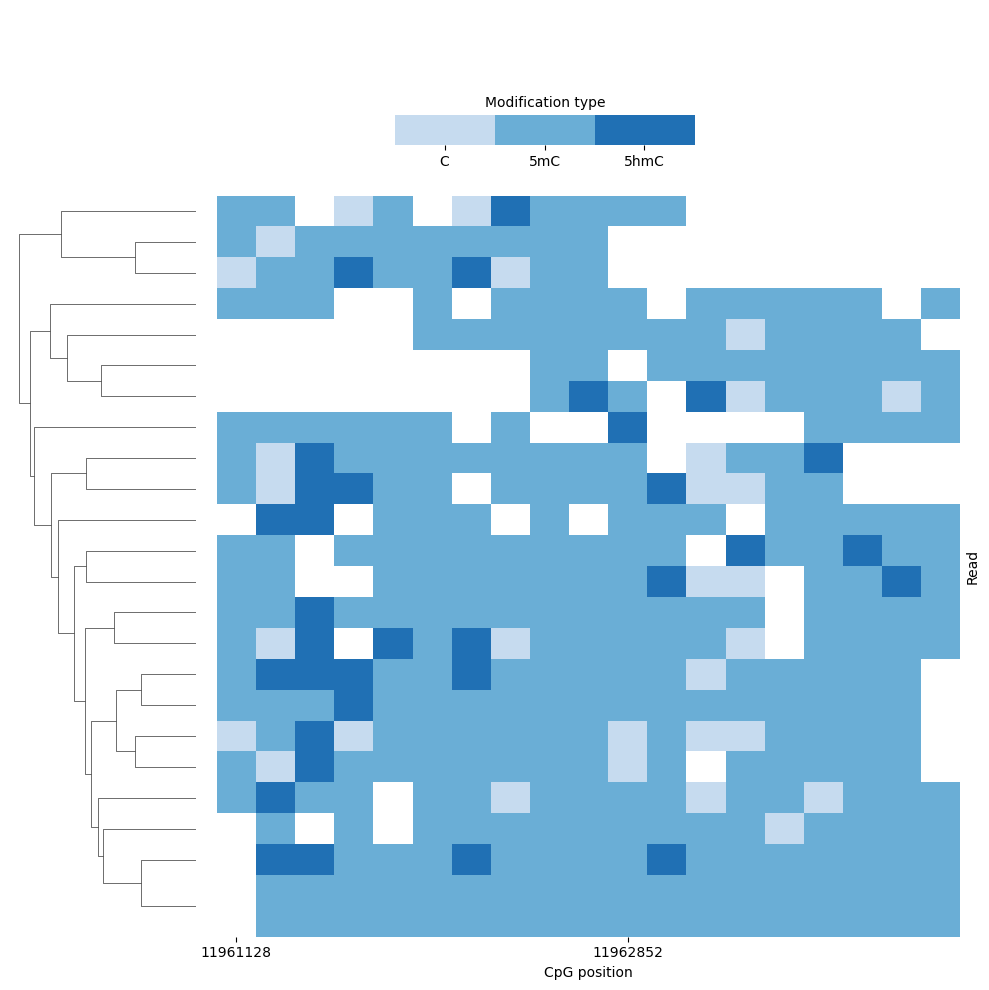

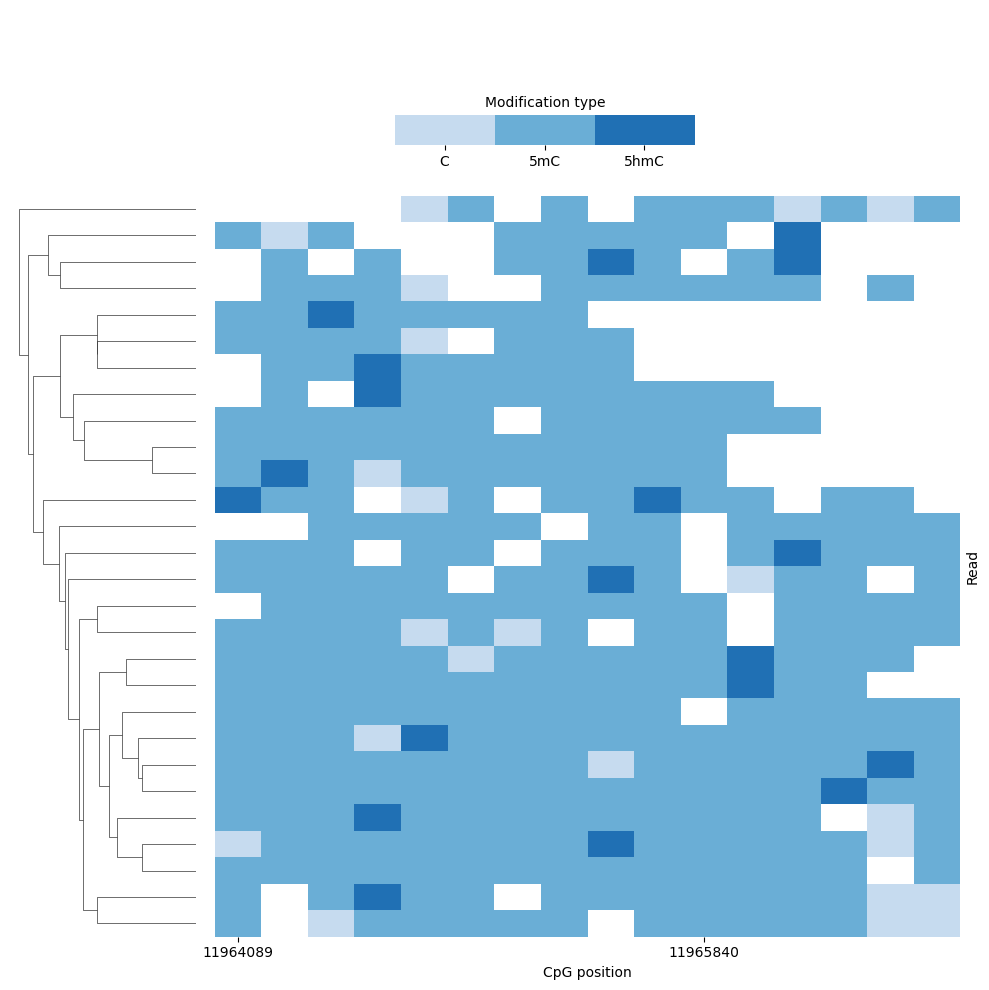

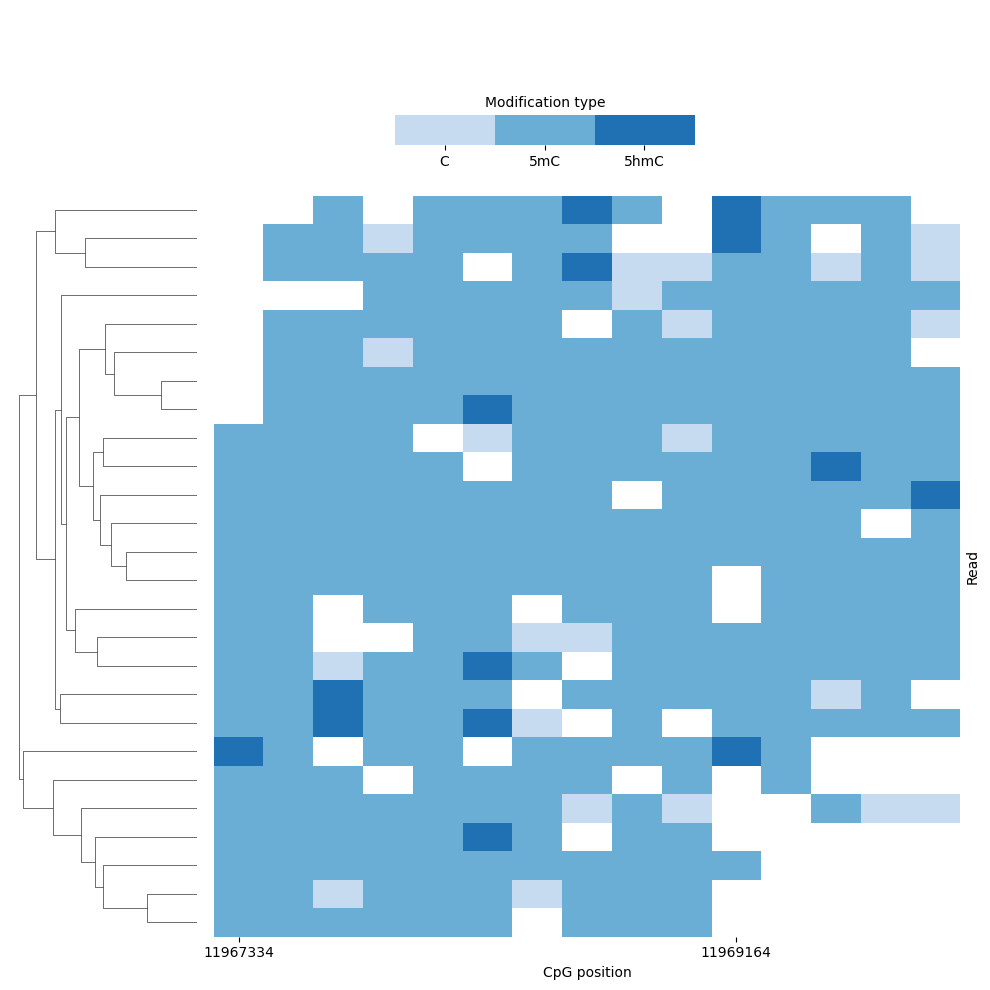

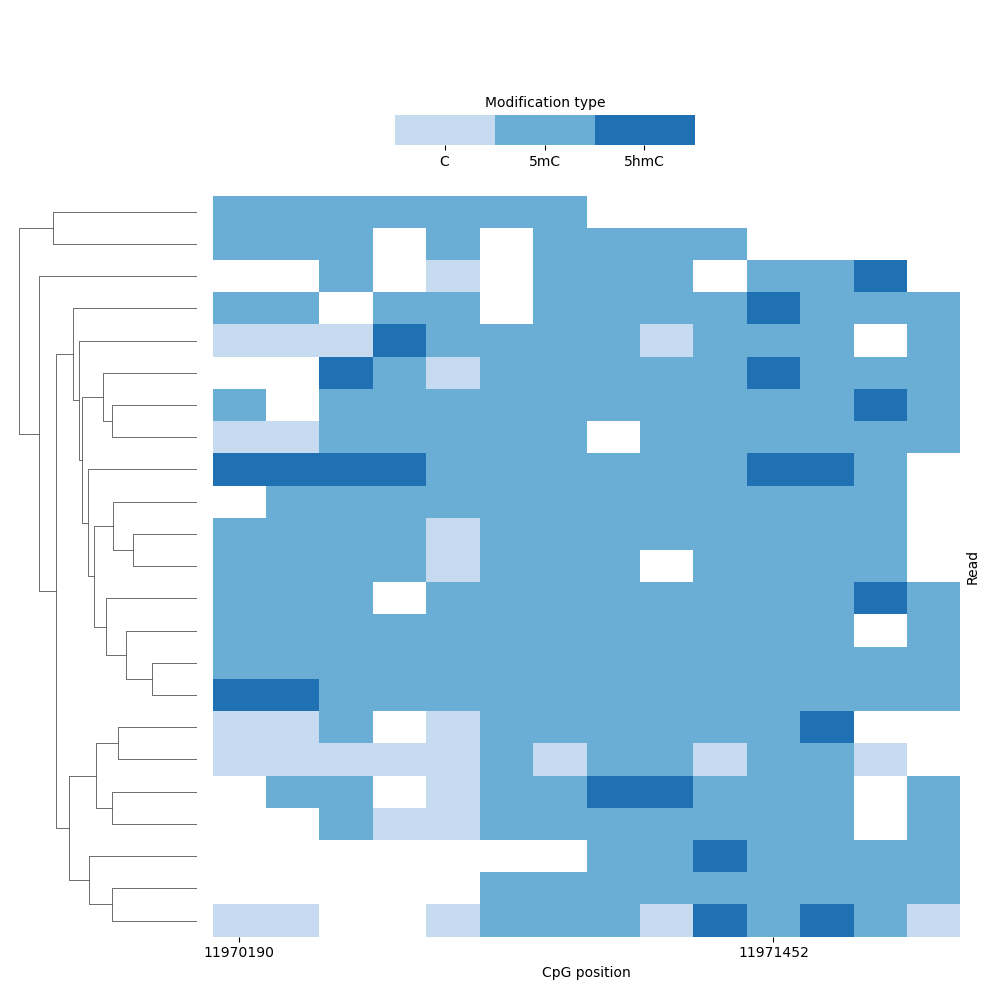

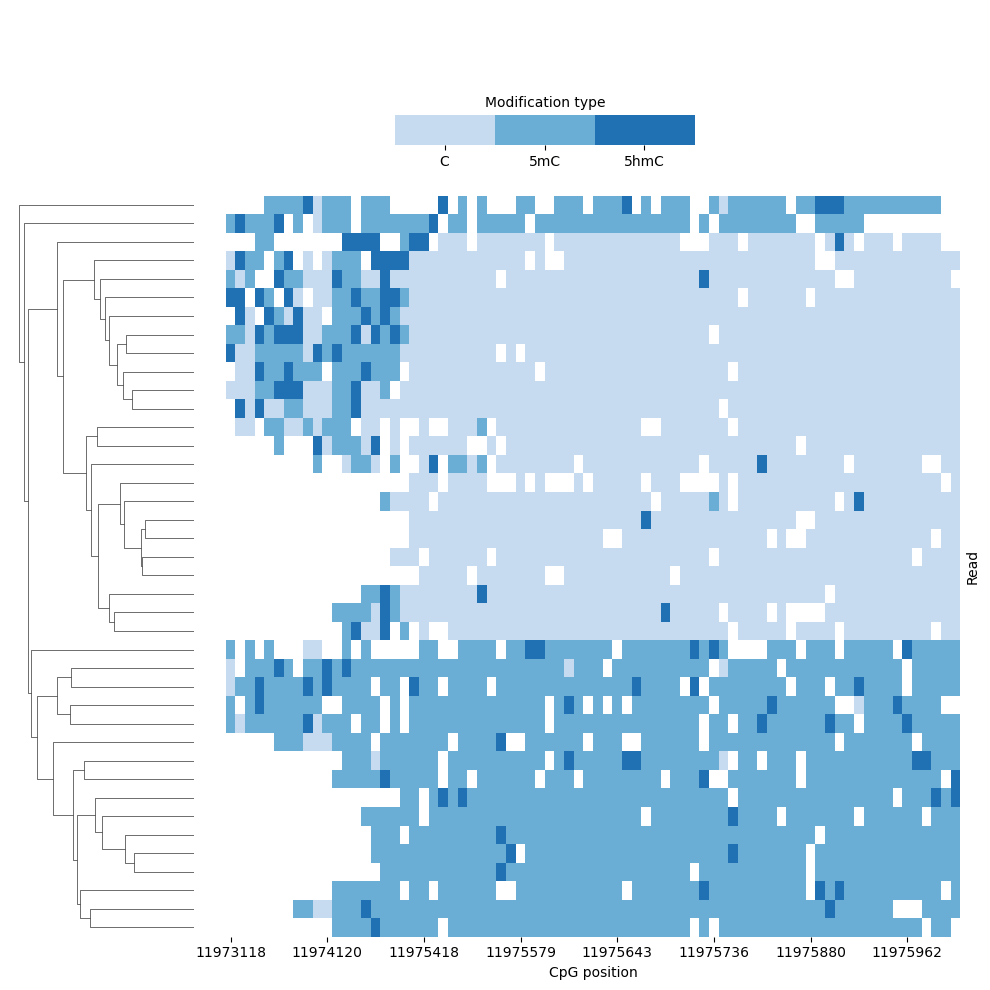

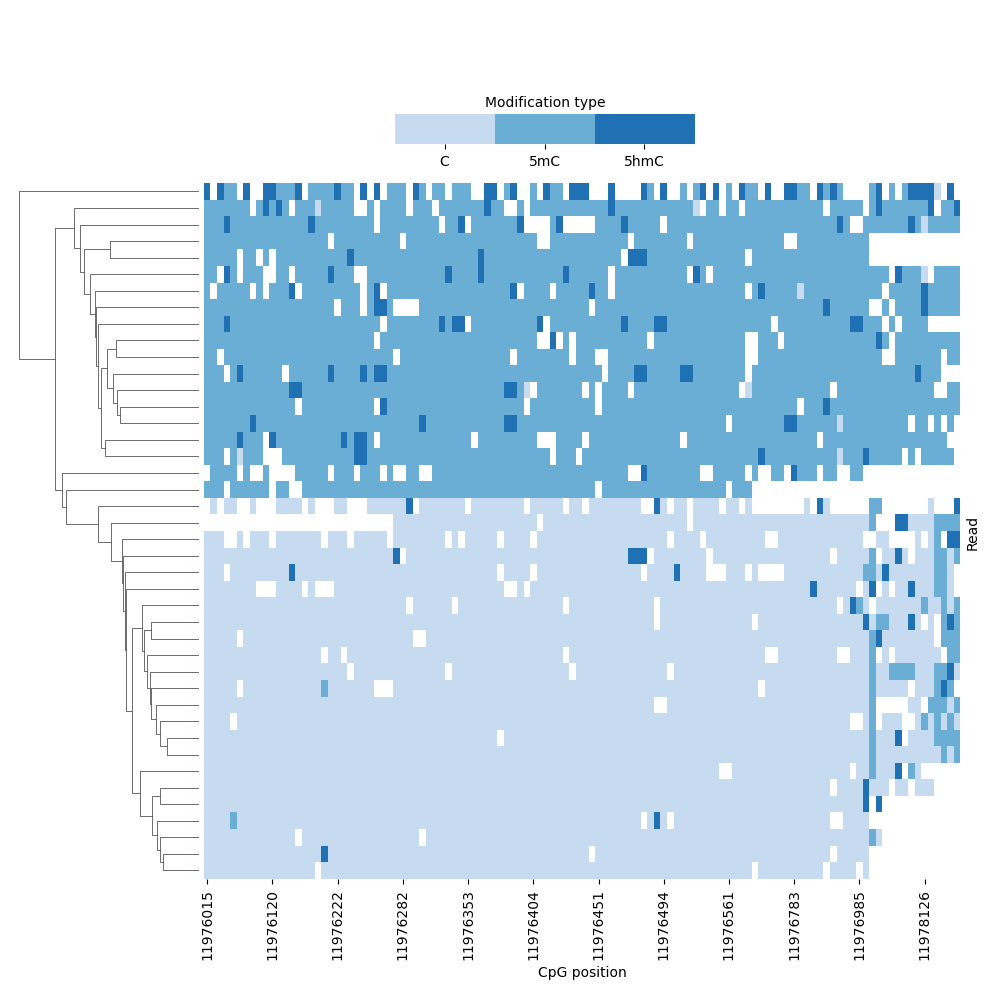

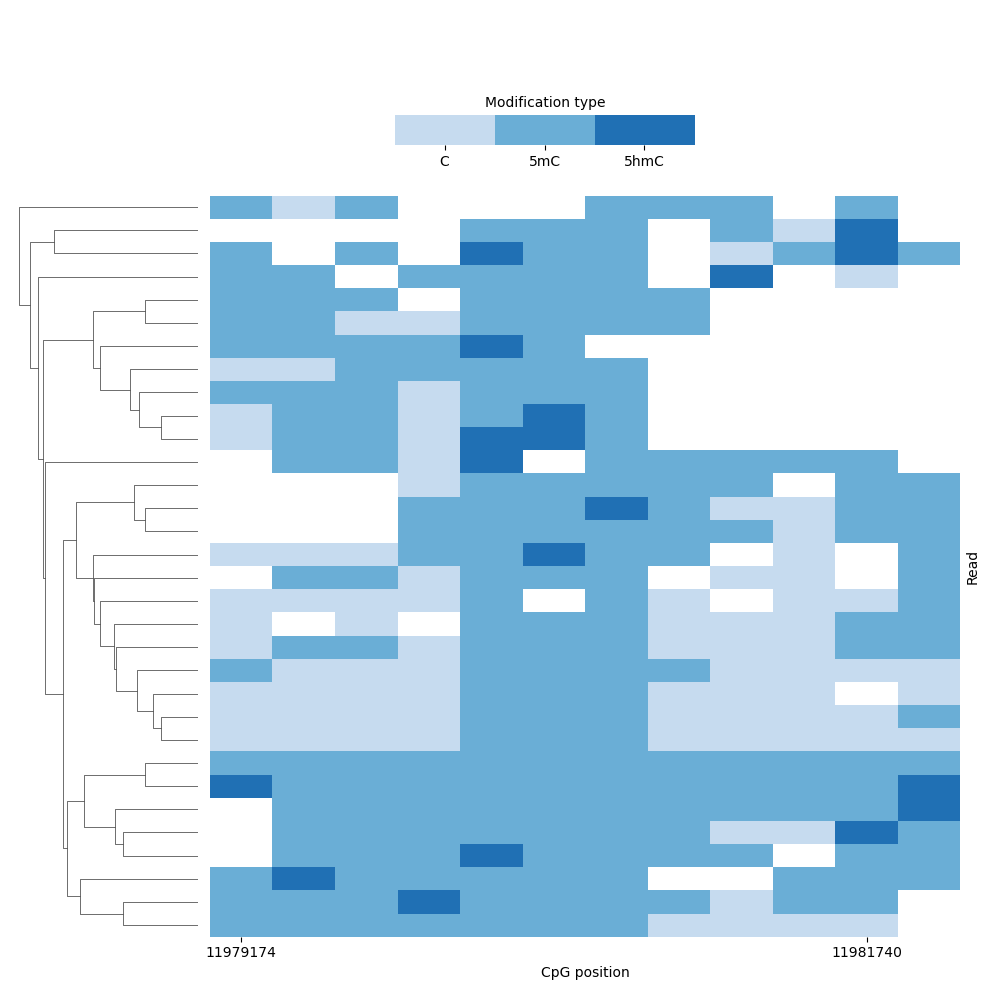

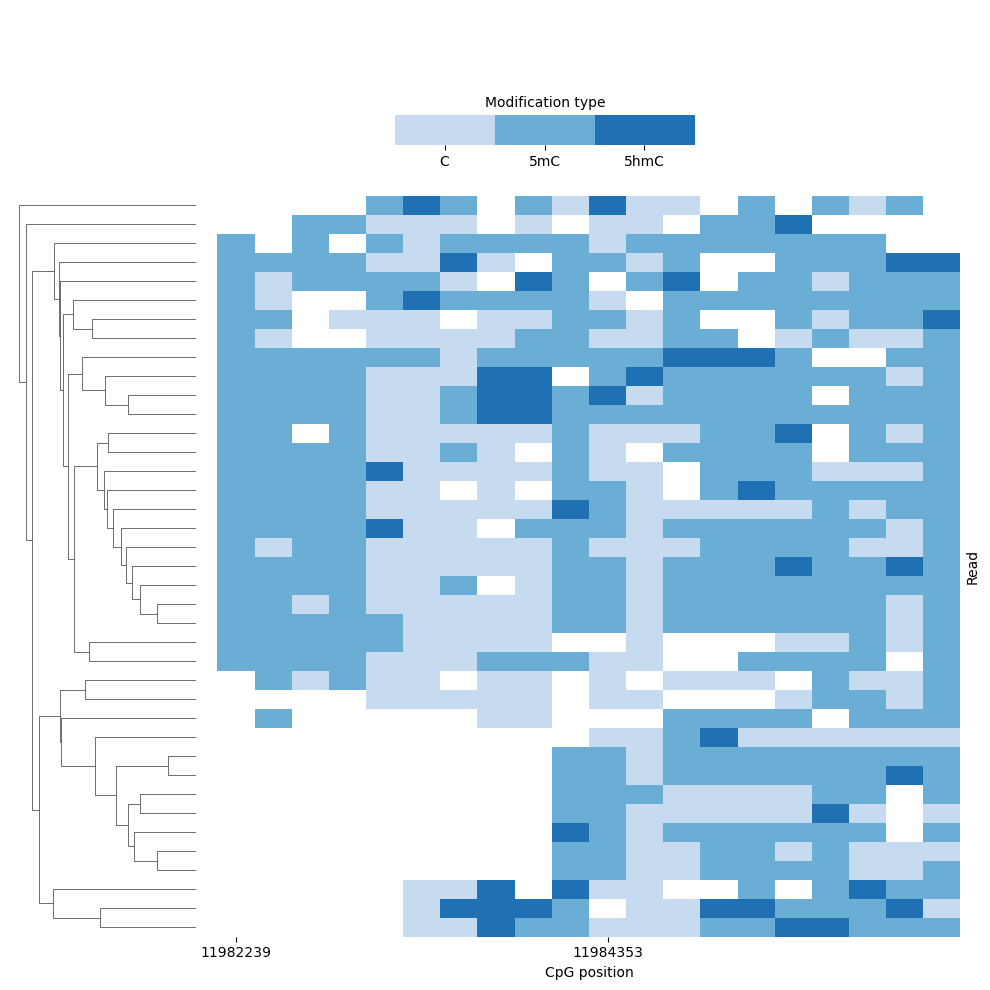

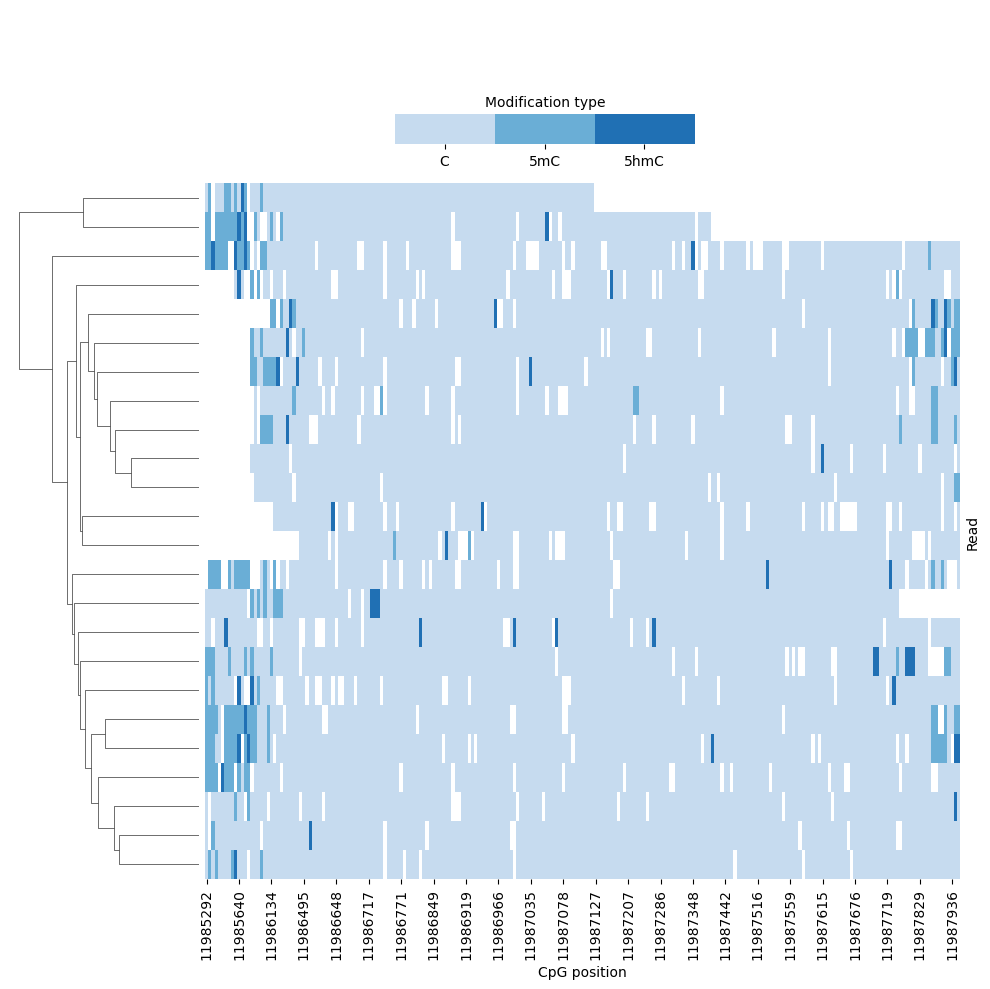

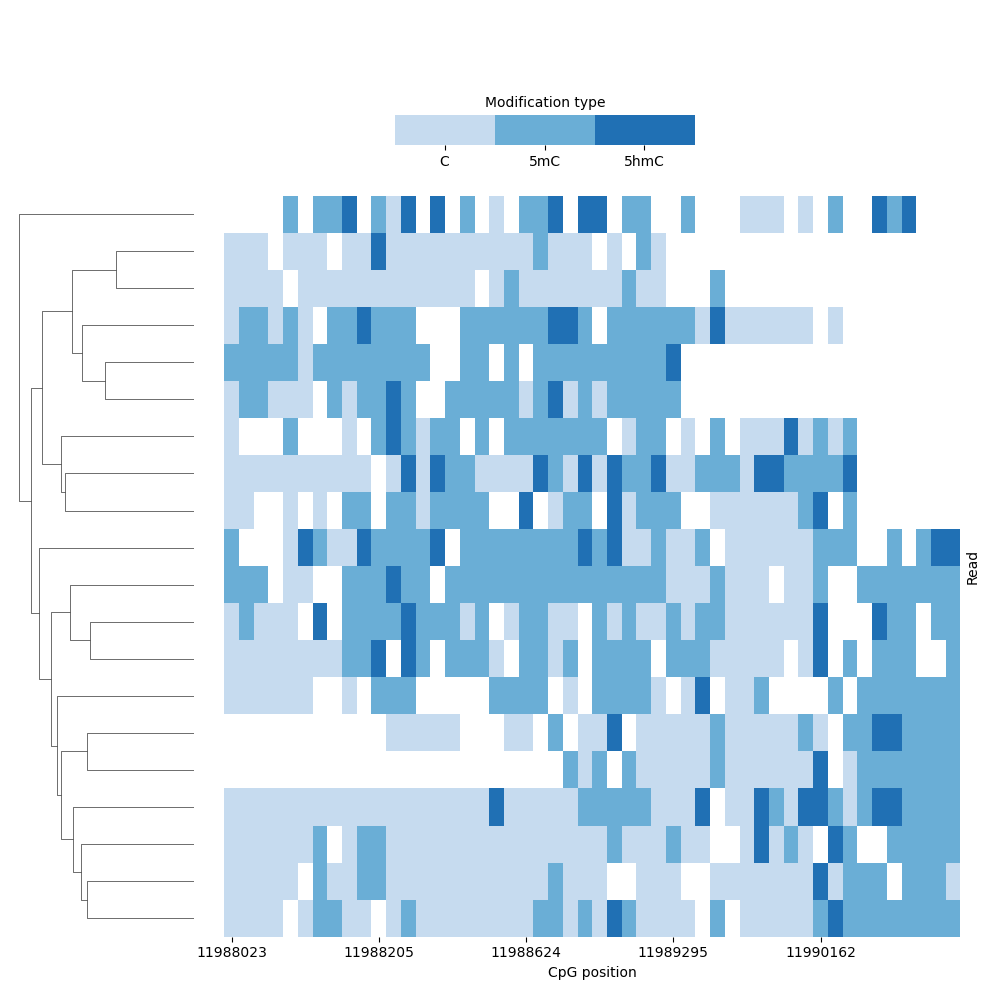

In [119]:
import numpy as np

for tile in np.arange(1, 39, 1):
    fig = makeHeatmap(tile)
    fig.savefig(f'./outputs/Grb10_heatmaps/tile_{tile}_heatmap.png', dpi=600)